In [215]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn
!pip install catboost
!pip install optuna

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import random

# 라이브러리 임포트
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, log_loss

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 변수 설명 및 받아오기

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [216]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220126(모의캐글 베이스 라인)/train.csv')
df

int_rate  annual_inc    dti  ...  fico_range_low  fico_range_high  depvar
0        0.0824     21000.0  29.19  ...             765              769       0
1        0.1299     80000.0   4.82  ...             665              669       0
2        0.1299     38000.0  23.66  ...             670              674       0
3        0.1367    100000.0  16.27  ...             680              684       1
4        0.1269     30000.0  25.28  ...             660              664       1
...         ...         ...    ...  ...             ...              ...     ...
99995    0.1757     65000.0  17.67  ...             660              664       1
99996    0.0890     65000.0   2.88  ...             765              769       0
99997    0.1349     46000.0  32.12  ...             665              669       0
99998    0.2115     31000.0   4.53  ...             710              714       1
99999    0.1599    125000.0  33.33  ...             690              694       0

[100000 rows x 76 columns]

# 2. EDA

In [ ]:
df.describe()

int_rate    annual_inc  ...  fico_range_high         depvar
count  100000.000000  1.000000e+05  ...    100000.000000  100000.000000
mean        0.130833  7.436061e+04  ...       696.630660       0.325690
std         0.044773  7.467409e+04  ...        29.668584       0.468634
min         0.053200  5.360000e+03  ...       664.000000       0.000000
25%         0.097500  4.500000e+04  ...       674.000000       0.000000
50%         0.127400  6.200000e+04  ...       689.000000       0.000000
75%         0.158000  9.000000e+04  ...       709.000000       1.000000
max         0.309900  8.300000e+06  ...       850.000000       1.000000

[8 rows x 76 columns]

In [ ]:
# 결측치 확인
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

int_rate  annual_inc  ...  fico_range_high  depvar
Non-Null Count         0           0  ...                0       0

[1 rows x 76 columns]

In [ ]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


In [ ]:
df.duplicated().sum()

0

In [ ]:
df[['pub_rec', 'tax_liens', 'depvar']].head(100)

pub_rec  tax_liens  depvar
0         0          0       0
1         1          0       0
2         0          0       0
3         0          0       1
4         2          0       1
..      ...        ...     ...
95        0          0       1
96        0          0       0
97        0          0       1
98        0          0       0
99        0          0       1

[100 rows x 3 columns]

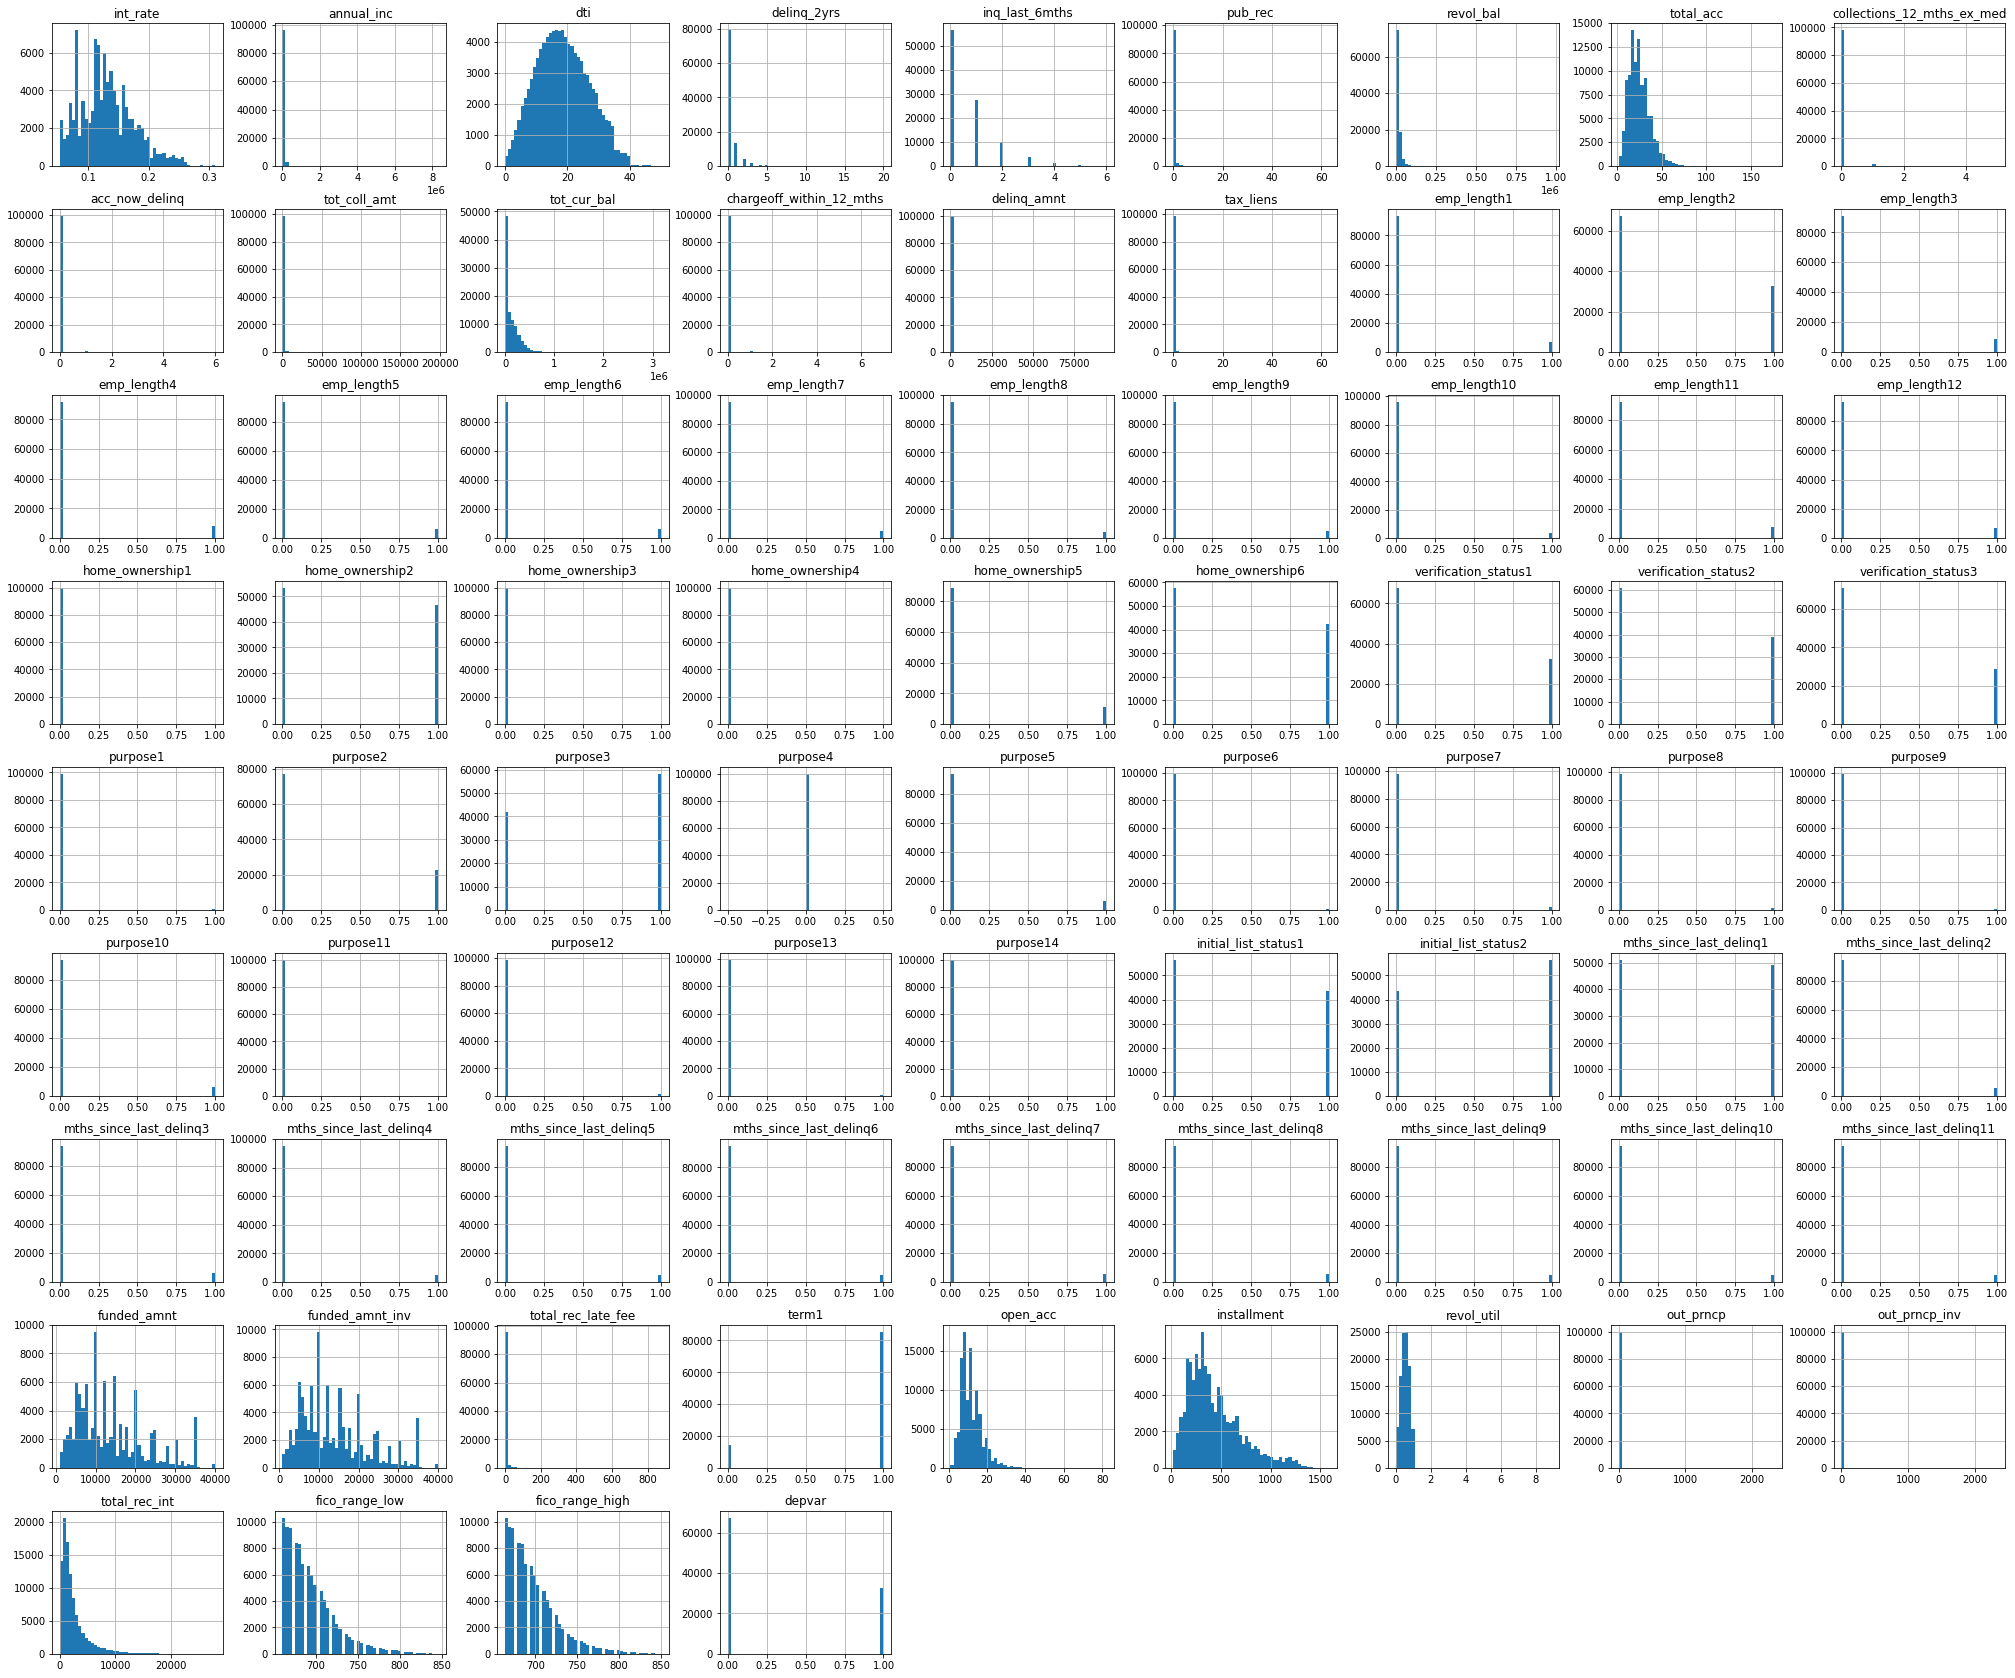

In [ ]:
df.hist(figsize = (35,30), bins = 50)
plt.show()

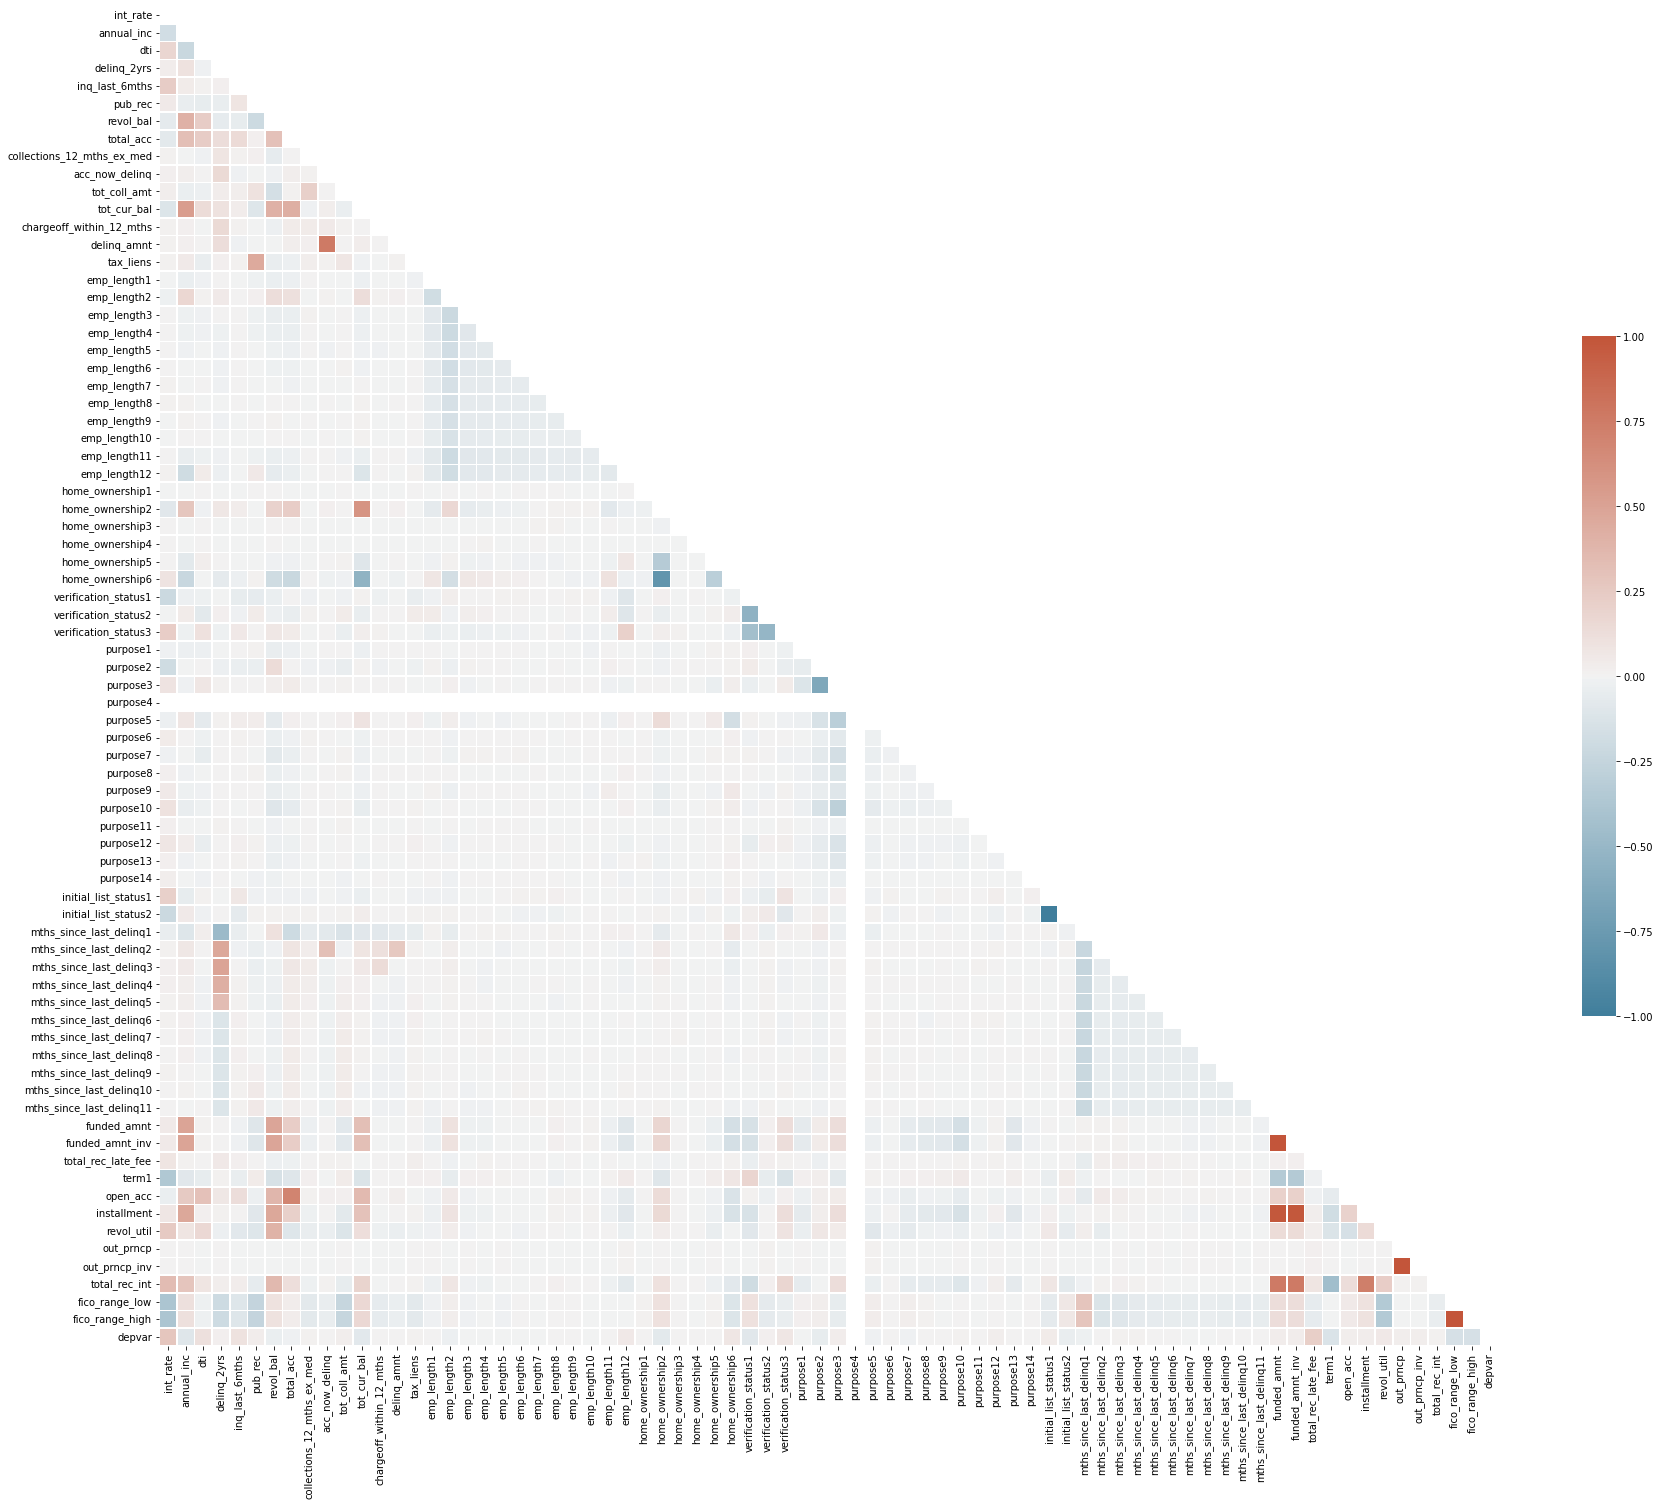

In [ ]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

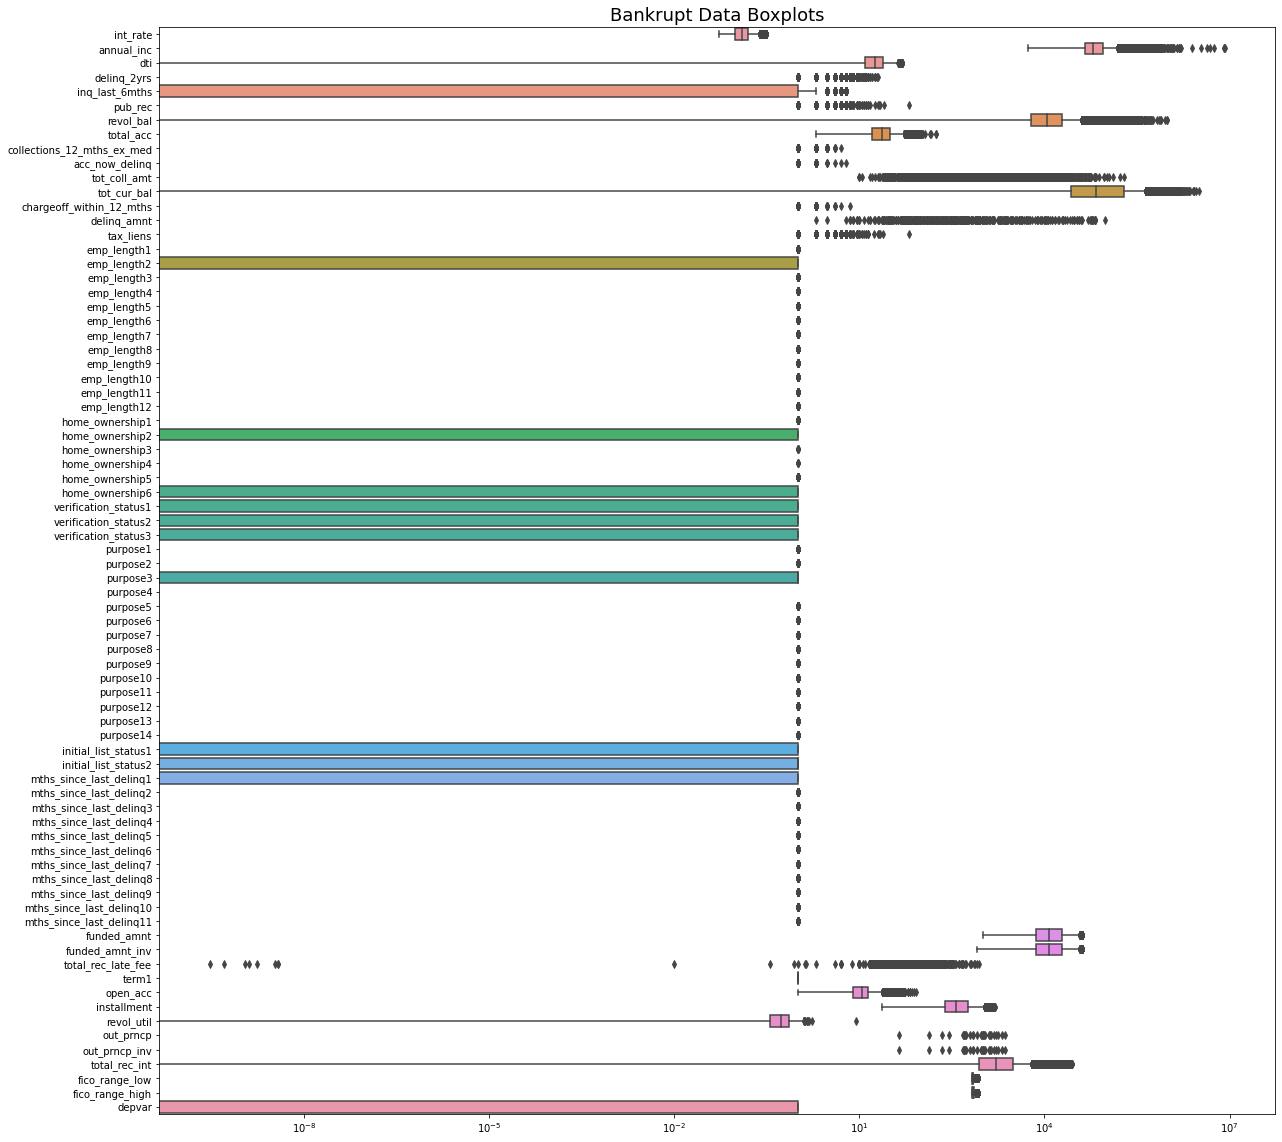

In [ ]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bankrupt Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [ ]:
# # Outliers removal

# def outliers_removal(feature,feature_name,dataset):
    
#     # Identify 25th & 75th quartiles

#     q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
#     print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
#     feat_iqr = q75 - q25
#     print('iqr: {}'.format(feat_iqr))
    
#     feat_cut_off = feat_iqr * 1.5
#     feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
#     print('Cut Off: {}'.format(feat_cut_off))
#     print(feature_name +' Lower: {}'.format(feat_lower))
#     print(feature_name +' Upper: {}'.format(feat_upper))
    
#     outliers = [x for x in feature if x < feat_lower or x > feat_upper]
#     print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
#     #print(feature_name + ' outliers:{}'.format(outliers))

#     dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index, axis=0, inplace=True)
#     print('-' * 65)
    
#     return dataset

# for col in ['annual_inc', 'revol_bal', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'delinq_amnt', 'total_rec_late_fee', 'revol_util']:
#     new_df = outliers_removal(df[col], str(col), df)

# new_df

## 2.1 각 Feature에 따른 depvar 비율 확인
단, Train, Valid 데이터로 나누지 않은 전체 데이터에 대해 진행함.

### 2.1.1 각 Featrue의 상관관계 및 박스플롯 시각화

In [ ]:
def inverse_encoding(dataframe, col_name, max_num):
    temp_f = lambda x: np.argmax(x) + 1
    col_list = [col_name + str(i) for i in range(1, max_num+1)]
    dataframe[col_name] = dataframe[col_list].apply(temp_f, axis='columns')
    dataframe = dataframe.drop(col_list, axis='columns')
    return dataframe
    

my_df = df.copy()
to_change_cols = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'mths_since_last_delinq']
to_change_nums = [12, 6, 3, 14, 2, 11]

for i in range(len(to_change_cols)):
    my_df = inverse_encoding(my_df, to_change_cols[i], to_change_nums[i])
    my_df[to_change_cols[i]] = my_df[to_change_cols[i]].astype('category')

my_df

int_rate  annual_inc  ...  initial_list_status  mths_since_last_delinq
0        0.0824     21000.0  ...                    2                       1
1        0.1299     80000.0  ...                    2                       1
2        0.1299     38000.0  ...                    2                      11
3        0.1367    100000.0  ...                    2                       5
4        0.1269     30000.0  ...                    2                       1
...         ...         ...  ...                  ...                     ...
99995    0.1757     65000.0  ...                    2                       1
99996    0.0890     65000.0  ...                    1                       1
99997    0.1349     46000.0  ...                    2                       1
99998    0.2115     31000.0  ...                    2                       1
99999    0.1599    125000.0  ...                    2                       1

[100000 rows x 34 columns]

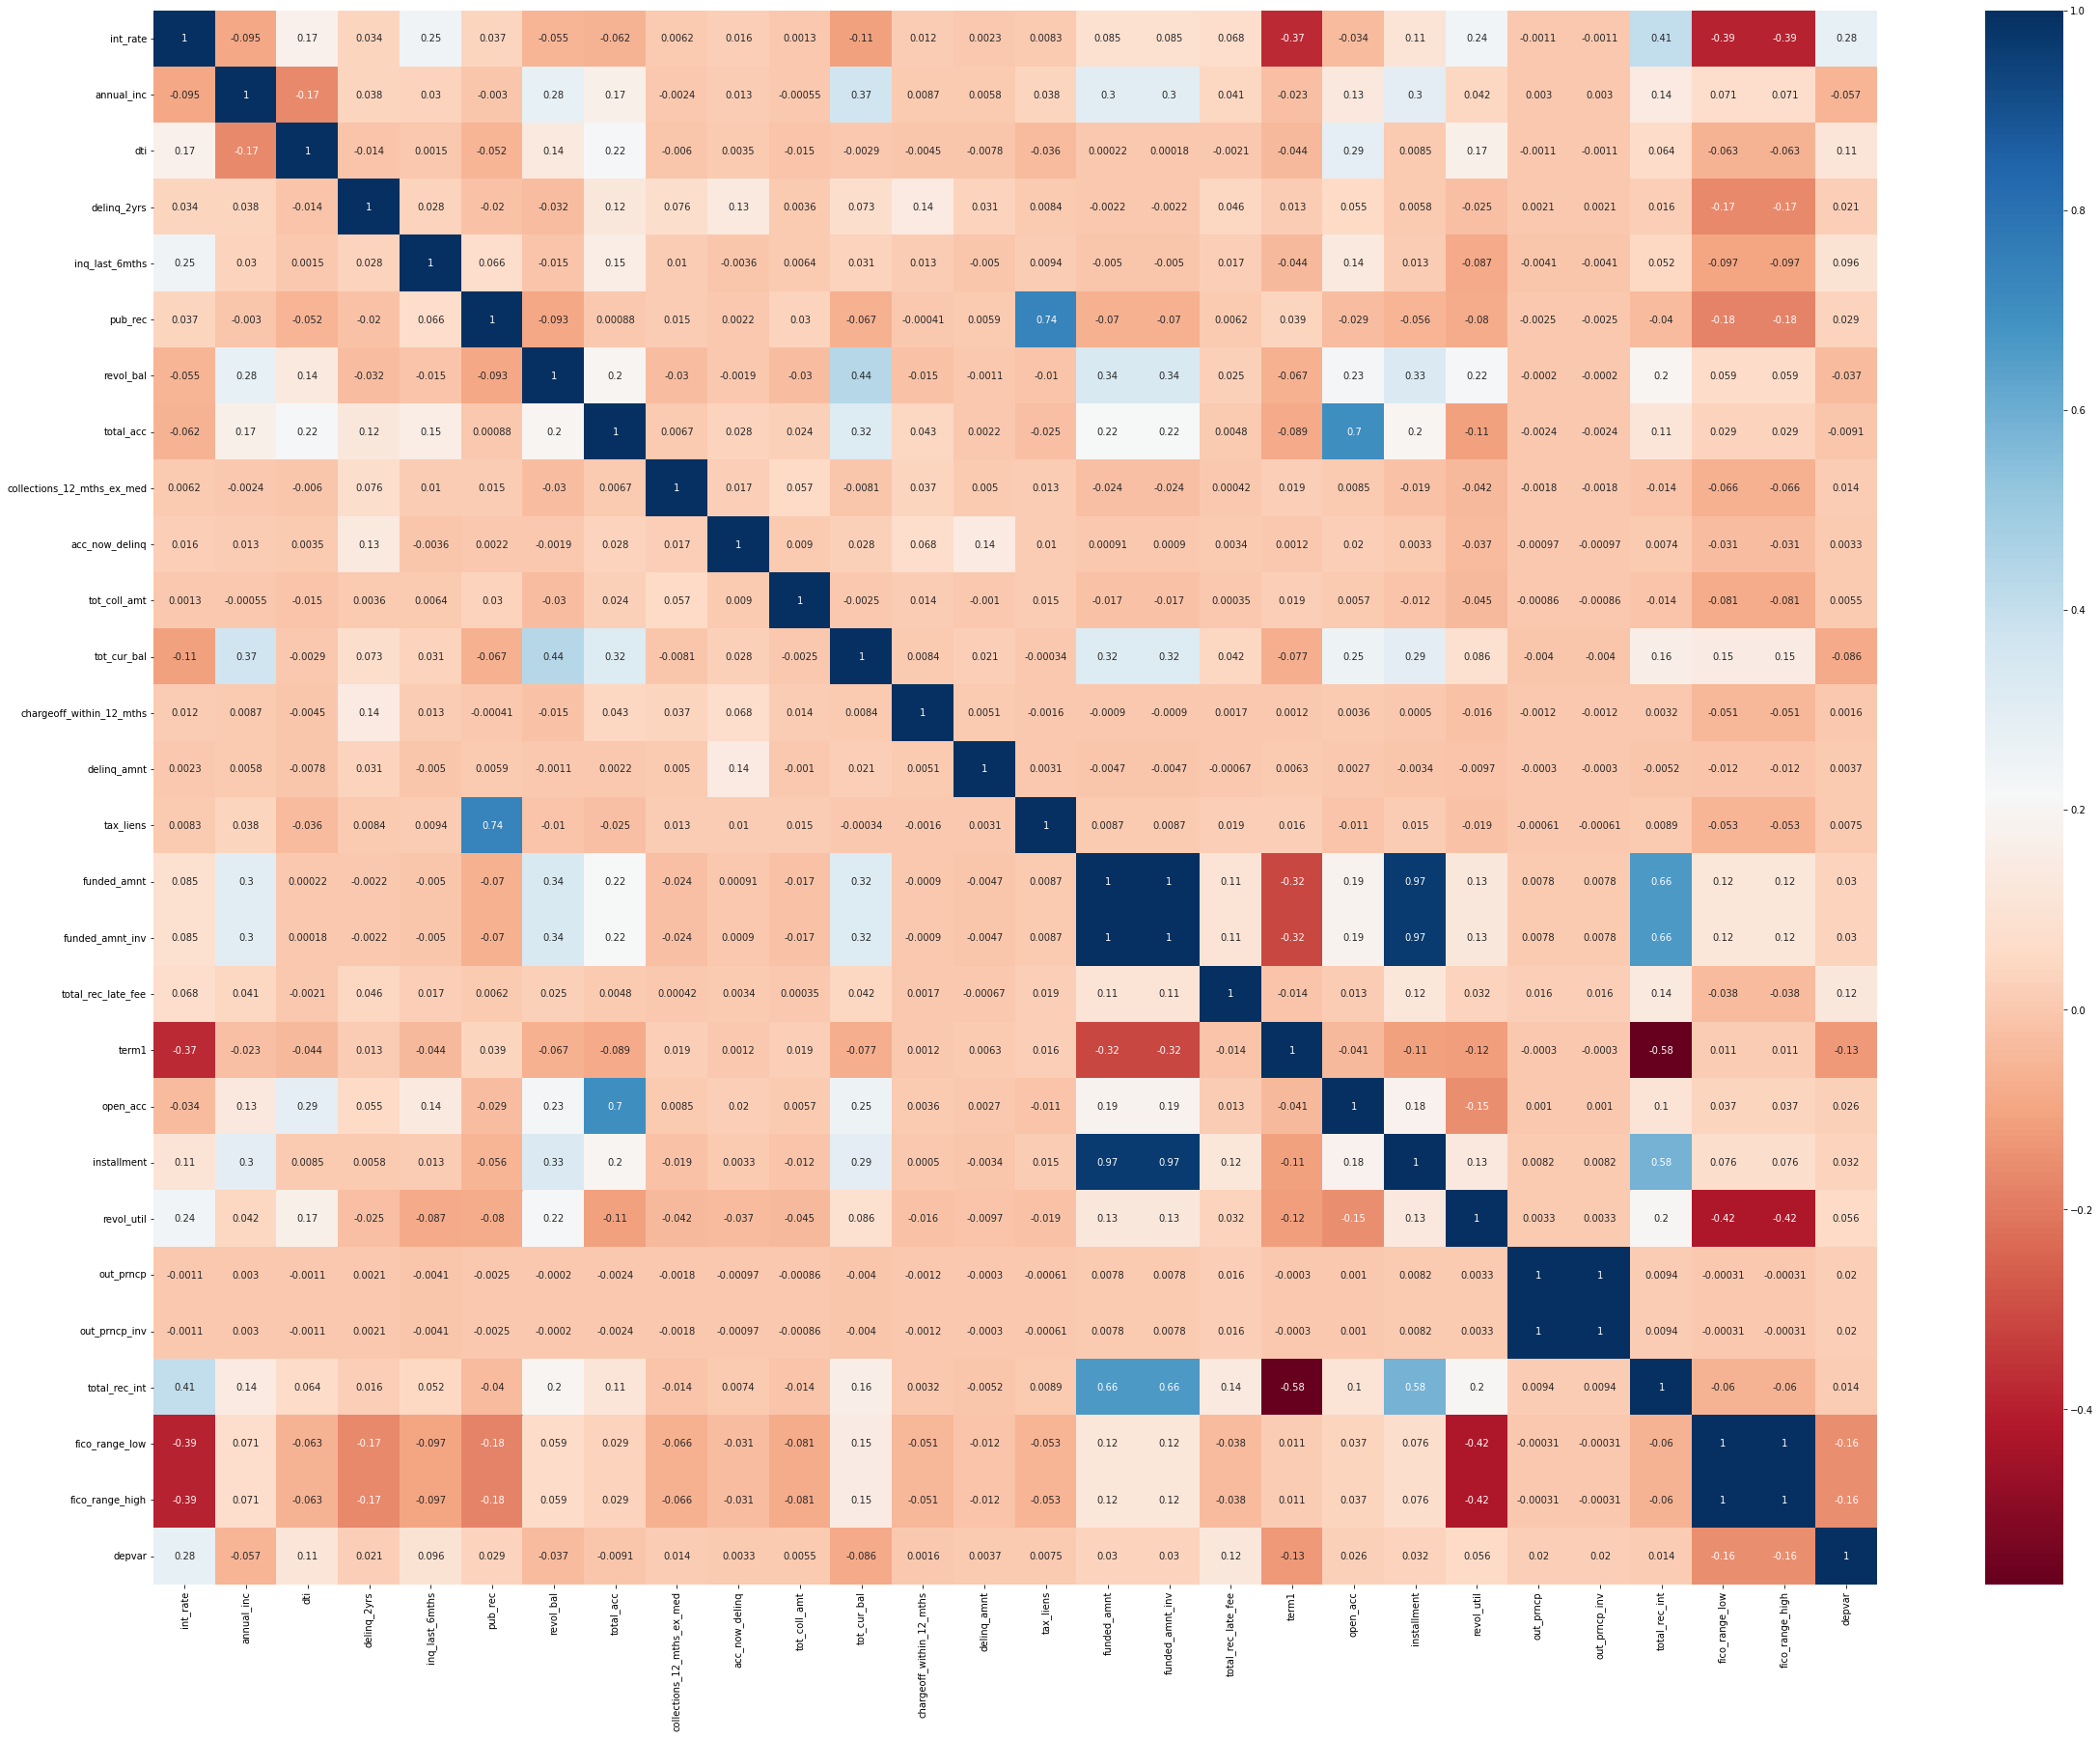

In [ ]:
plt.figure(figsize = (40, 30))
sns.heatmap(my_df.corr(), annot = True, cmap='RdBu')

int_rate, fico_range_low, fico_range_high 등의 feature에 대해 이상치 점검해볼 가치가 있음

In [ ]:
len(my_df.columns)

34

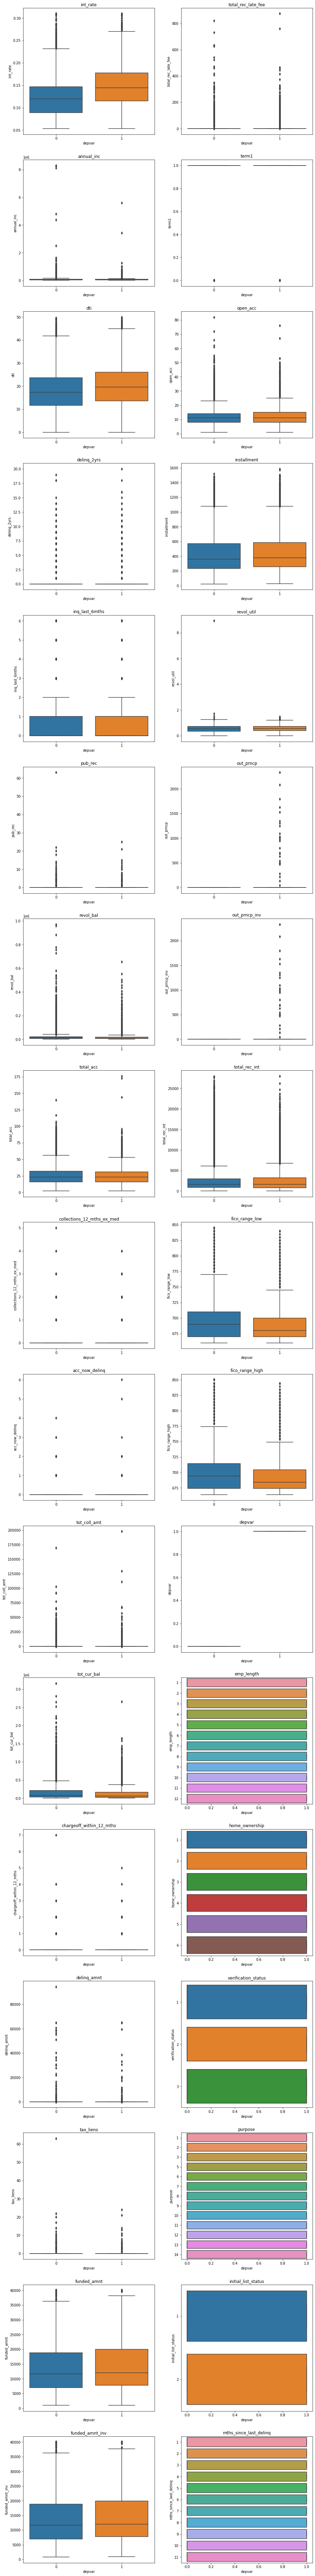

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=17, figsize=(15, 17*8))

for i in range(len(my_df.columns)):
    sns.boxplot(x='depvar', y=my_df.columns[i], data=my_df, ax=axes[i%17, i//17])
    axes[i%17, i//17].set_title(my_df.columns[i])

boxplot 기준
1. depvar에 크게 영향을 주지 않는 feature: delinq_2yrs, inq_last_6mths, collections_12_mths_ex_med, tot_coll_amt, chargeoff_within_12_mths, delinq_amnt, tax_liens, total_rec_late_fee

2. out_prncp, out_prncp_inv는 1 이상이면 1로 바이닝

In [ ]:
my_df.out_prncp_inv[my_df['depvar']==1].value_counts()

0.00       32542
508.00         1
1095.77        1
1527.69        1
800.80         1
1628.56        1
949.15         1
686.21         1
214.93         1
2081.26        1
1006.80        1
539.36         1
2330.97        1
43.26          1
1345.74        1
281.68         1
136.24         1
1305.93        1
492.07         1
499.52         1
628.43         1
1247.52        1
1002.31        1
1033.47        1
470.13         1
698.61         1
975.05         1
1796.48        1
Name: out_prncp_inv, dtype: int64

In [ ]:
my_df.out_prncp_inv[my_df['depvar']==0].max()

0.0

### 2.1.2 bar_chart

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    dataframe = dataframe.drop([0, 1, 2, 3], axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

                   0       1       2       3      4   ...   15   16   18   19   20
bankrupt      25541.0  4457.0  1473.0   545.0  240.0  ...  1.0  2.0  1.0  NaN  1.0
not_bankrupt  53942.0  8833.0  2690.0  1012.0  471.0  ...  1.0  NaN  2.0  1.0  NaN

[2 rows x 20 columns]


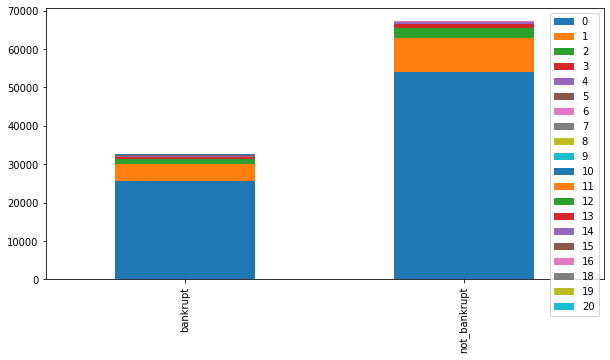

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    # dataframe = dataframe.drop(list(range(0, 13)), axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

bar_chart(df, 'delinq_2yrs')

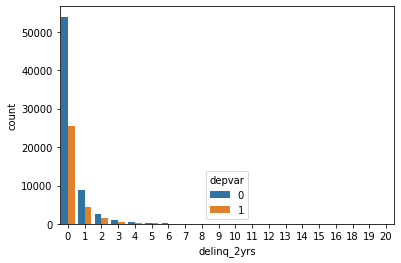

In [ ]:
sns.countplot(x="delinq_2yrs", hue="depvar", data=df)

                  0      1     2     3    4    5   6
bankrupt      16423   9648  4047  1707  518  202  24
not_bankrupt  40288  17839  6166  2248  609  238  43


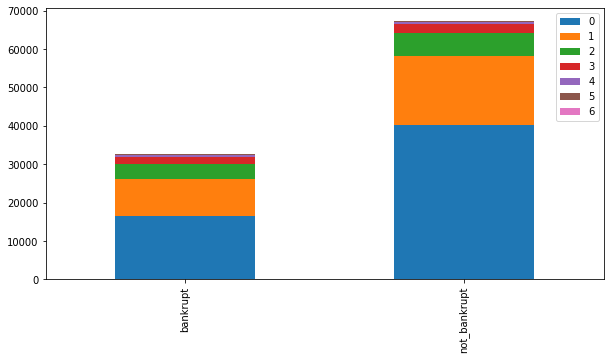

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    # dataframe = dataframe.drop(list(range(0, 2)), axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

bar_chart(df, 'inq_last_6mths')

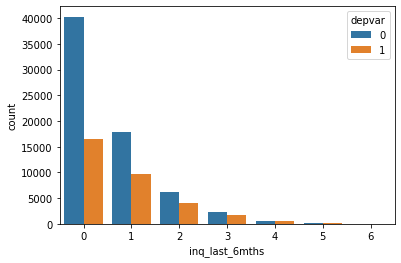

In [ ]:
sns.countplot(x="inq_last_6mths", hue="depvar", data=df)

                   0       1       2      3      4   ...   20   21   22   25   63
bankrupt      26002.0  5390.0   770.0  229.0   91.0  ...  NaN  1.0  NaN  1.0  NaN
not_bankrupt  55997.0  9332.0  1373.0  417.0  159.0  ...  1.0  NaN  1.0  NaN  1.0

[2 rows x 22 columns]


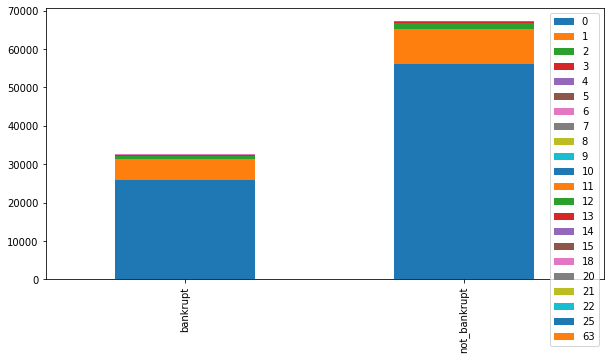

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    # dataframe = dataframe.drop(list(range(0, 8)), axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

bar_chart(df, 'pub_rec')

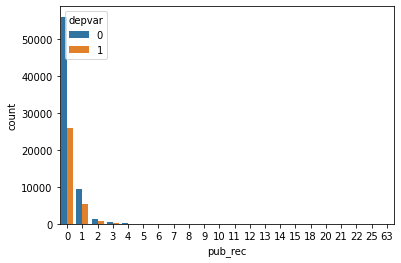

In [ ]:
sns.countplot(x="pub_rec", hue="depvar", data=df)

                    0      1     2    3    4    5
bankrupt      31924.0  589.0  45.0  9.0  2.0  NaN
not_bankrupt  66366.0  979.0  74.0  9.0  2.0  1.0


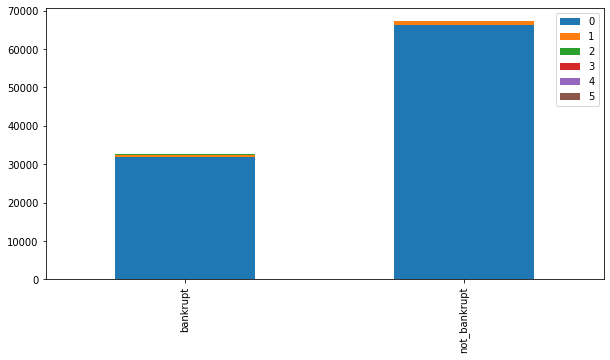

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    # dataframe = dataframe.drop(list(range(0, 3)), axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

bar_chart(df, 'collections_12_mths_ex_med')

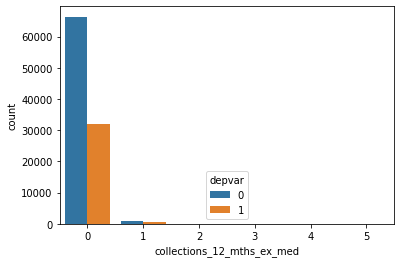

In [ ]:
sns.countplot(x="collections_12_mths_ex_med", hue="depvar", data=df)

                    0      1     2    3    4    5    6
bankrupt      32384.0  176.0   6.0  1.0  NaN  1.0  1.0
not_bankrupt  67075.0  338.0  15.0  2.0  1.0  NaN  NaN


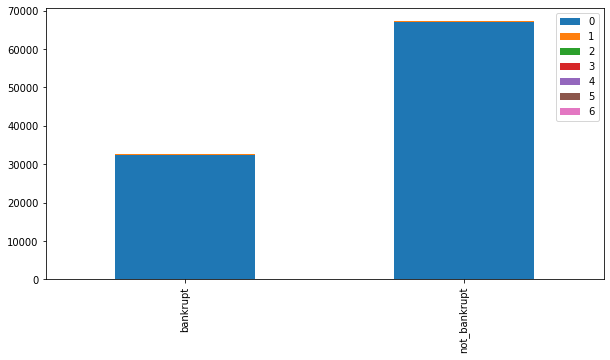

In [ ]:
bar_chart(df, 'acc_now_delinq')

                    0      1     2    3    4    5    7
bankrupt      32284.0  257.0  22.0  4.0  1.0  1.0  NaN
not_bankrupt  66845.0  543.0  37.0  3.0  2.0  NaN  1.0


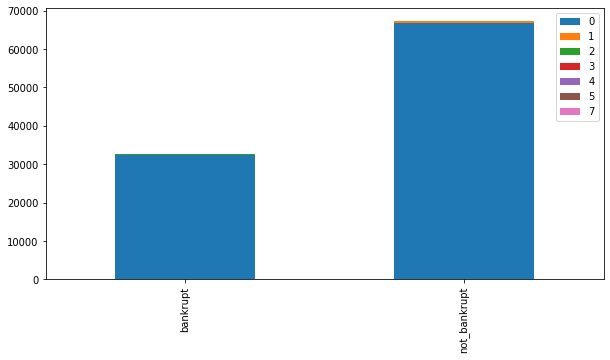

In [ ]:
bar_chart(df, 'chargeoff_within_12_mths')

                   0       1      2      3     4   ...   20   21   22   24   63
bankrupt      31199.0   926.0  263.0   87.0  44.0  ...  NaN  1.0  NaN  1.0  NaN
not_bankrupt  64923.0  1729.0  434.0  167.0  78.0  ...  1.0  NaN  1.0  NaN  1.0

[2 rows x 21 columns]


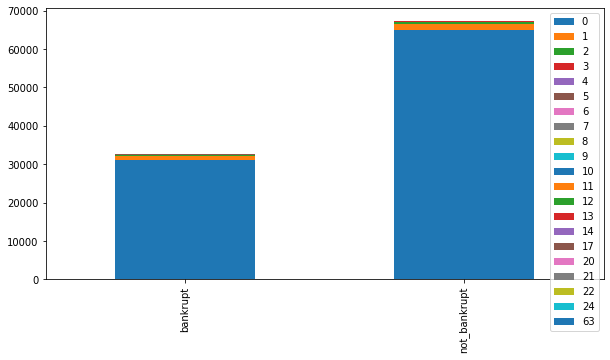

In [ ]:
bar_chart(df, 'tax_liens')

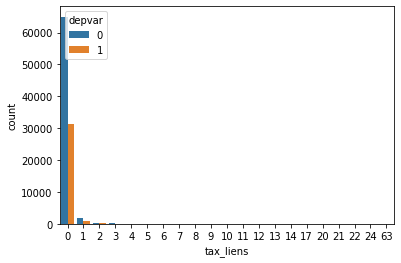

In [ ]:
sns.countplot(x="tax_liens", hue="depvar", data=df)

                  1     0
bankrupt      25734  6835
not_bankrupt  59858  7573


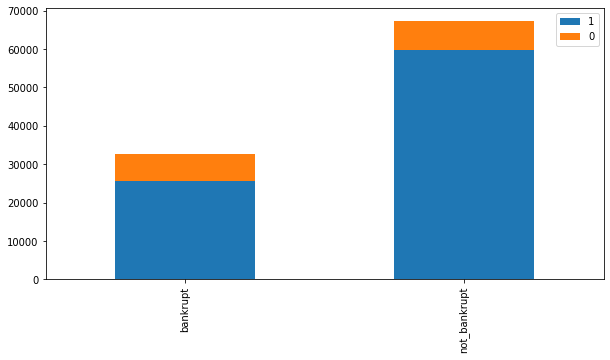

In [ ]:
bar_chart(df, 'term1')

                1      2      3       4       5   ...   66   67   72   76   82
bankrupt       4.0   84.0  316.0   803.0  1384.0  ...  NaN  1.0  NaN  1.0  NaN
not_bankrupt  15.0  214.0  784.0  1863.0  3214.0  ...  1.0  NaN  1.0  NaN  1.0

[2 rows x 62 columns]


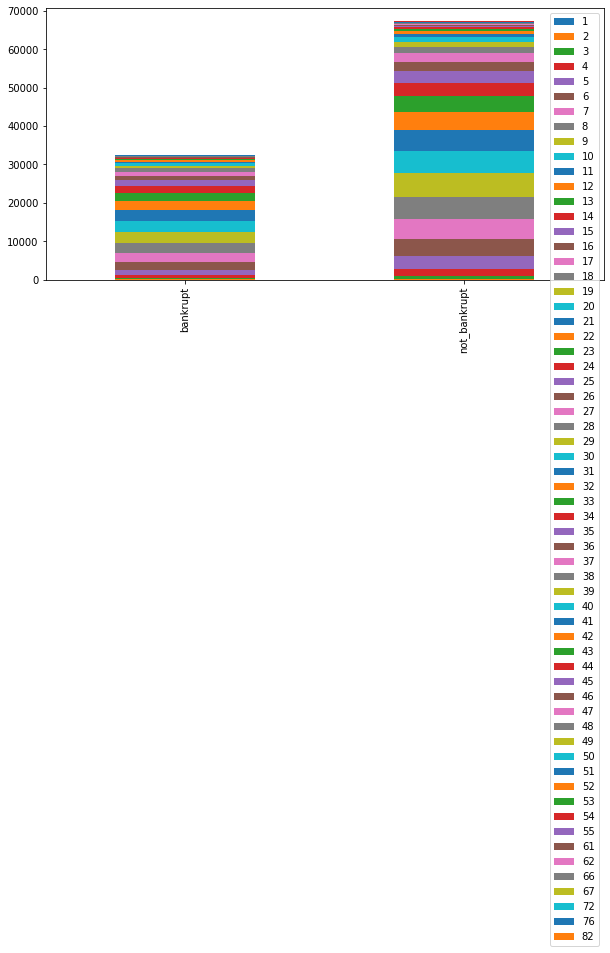

In [ ]:
def bar_chart(dataframe, feature):
    bankrupt = dataframe[dataframe['depvar']==1][feature].value_counts()
    not_bankrupt = dataframe[dataframe['depvar']==0][feature].value_counts()
    dataframe = pd.DataFrame([bankrupt, not_bankrupt])
    dataframe.index = ['bankrupt','not_bankrupt']
    print(dataframe)
    # dataframe = dataframe.drop(list(range(1, 17)), axis=1)
    dataframe.plot(kind='bar',stacked=True, figsize=(10,5))

bar_chart(df, 'open_acc')

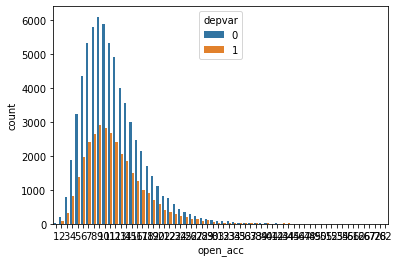

In [ ]:
sns.countplot(x="open_acc", hue="depvar", data=df)

delinq_2yrs, inq_last_6mths, pub_rec, collections_12_mths_ex_med, acc_now_delinq, chargeoff_within_12_mthschargeoff_within_12_mths, tax_liens, term1, open_acc

위 컬럼에 대한 bar_chart 결과, 대체로 부도 여부와 큰 연관성이 없는 것으로 보인다.(부도 여부에 따른 각 컬럼의 비율이 비슷하기 때문)

### 2.1.3 수치 범주형 라벨로 인코딩된 feature의 bar_chart

In [ ]:
def inverse_encoding(dataframe, col_name, max_num):
    temp_f = lambda x: np.argmax(x) + 1
    col_list = [col_name + str(i) for i in range(1, max_num+1)]
    dataframe[col_name] = dataframe[col_list].apply(temp_f, axis='columns')
    dataframe = dataframe.drop(col_list, axis='columns')
    return dataframe

In [ ]:
my_df = df.copy()
to_change_cols = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'mths_since_last_delinq']
to_change_nums = [12, 6, 3, 14, 2, 11]

for i in range(len(to_change_cols)):
    my_df = inverse_encoding(my_df, to_change_cols[i], to_change_nums[i])
    my_df[to_change_cols[i]] = my_df[to_change_cols[i]].astype('category')

my_df

int_rate  annual_inc  ...  initial_list_status  mths_since_last_delinq
0        0.0824     21000.0  ...                    2                       1
1        0.1299     80000.0  ...                    2                       1
2        0.1299     38000.0  ...                    2                      11
3        0.1367    100000.0  ...                    2                       5
4        0.1269     30000.0  ...                    2                       1
...         ...         ...  ...                  ...                     ...
99995    0.1757     65000.0  ...                    2                       1
99996    0.0890     65000.0  ...                    1                       1
99997    0.1349     46000.0  ...                    2                       1
99998    0.2115     31000.0  ...                    2                       1
99999    0.1599    125000.0  ...                    2                       1

[100000 rows x 34 columns]

                 1      2     3     4     5  ...     8     9    10    11    12
bankrupt      2203   9945  2863  2600  1923  ...  1493  1521  1252  2523  2827
not_bankrupt  4337  22679  6078  5458  4025  ...  3039  3048  2605  5032  3814

[2 rows x 12 columns]


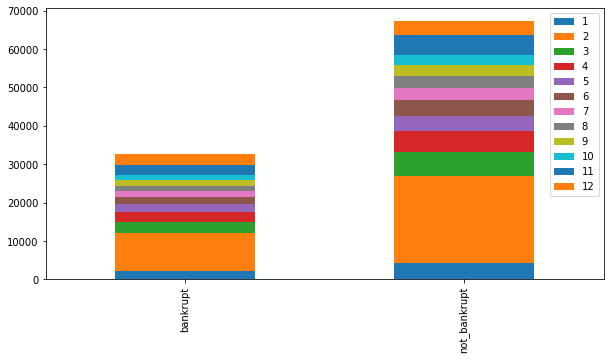

In [ ]:
bar_chart(my_df, 'emp_length')

               1      2  3  4     5      6
bankrupt      11  13424  3  2  3633  15496
not_bankrupt  22  33188  4  3  7455  26759


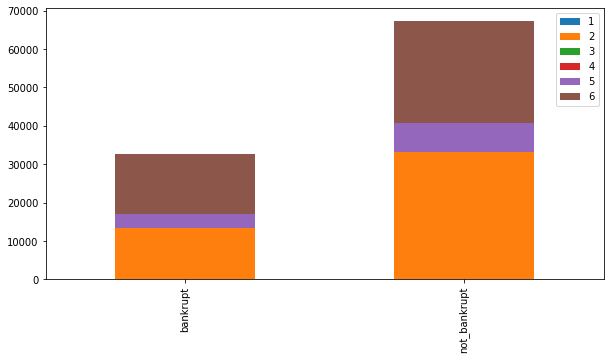

In [ ]:
bar_chart(my_df, 'home_ownership')

                  1      2      3
bankrupt       8527  13160  10882
not_bankrupt  23653  25860  17918


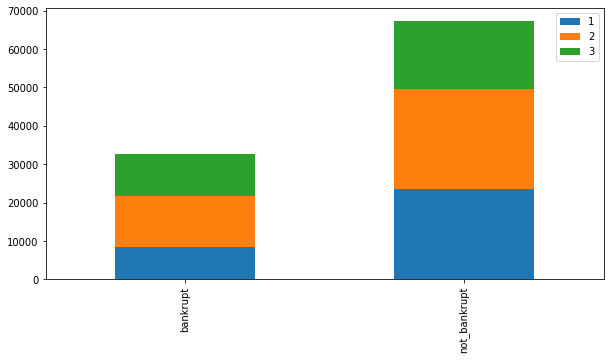

In [ ]:
bar_chart(my_df, 'verification_status')

                1      2      3     5    6     7  ...    9    10  11   12   13  14
bankrupt      287   6402  19877  1834  158   581  ...  257  1988  23  494  250  29
not_bankrupt  675  16270  38404  4206  267  1402  ...  474  3832  42  631  457  59

[2 rows x 13 columns]


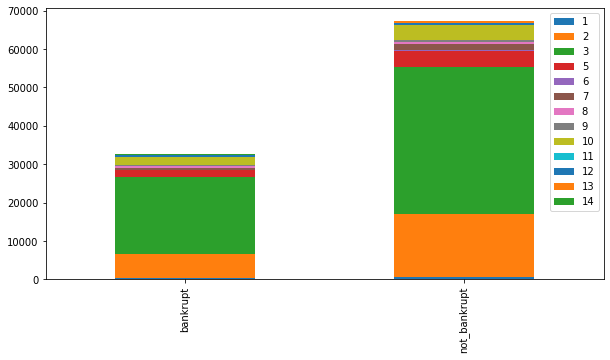

In [ ]:
bar_chart(my_df, 'purpose')

                  2      1
bankrupt      17386  15183
not_bankrupt  39171  28260


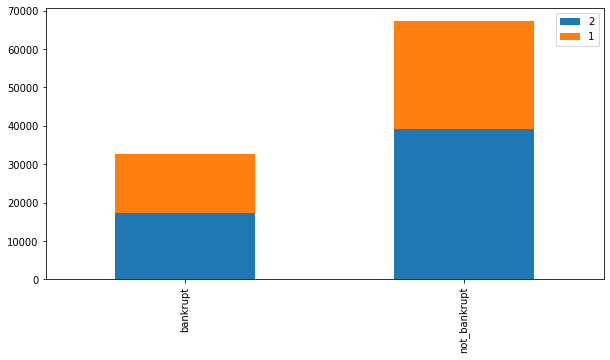

In [ ]:
bar_chart(my_df, 'initial_list_status')

                  1     2     3     4     5     6     7     8     9    10    11
bankrupt      15517  1766  2052  1616  1686  1631  1633  1718  1637  1683  1630
not_bankrupt  33415  3470  3957  2954  3389  3225  3501  3625  3259  3320  3316


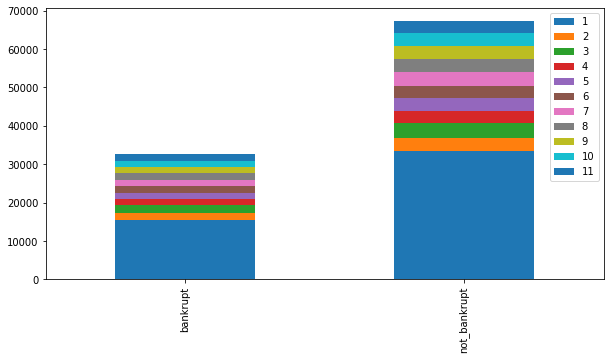

In [ ]:
bar_chart(my_df, 'mths_since_last_delinq')

### 2.1.4 FacetGrid 및 Distplot

#### int_rate

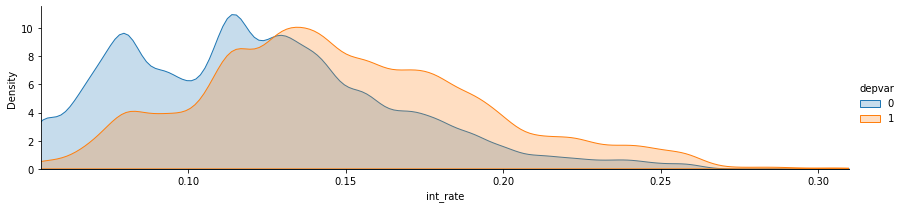

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'int_rate',shade= True)
facet.set(xlim=(df['int_rate'].min(), df['int_rate'].max()))
facet.add_legend()
 
plt.show() 

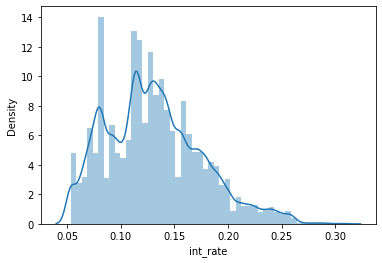

In [ ]:
sns.distplot(df['int_rate'])

#### annual_inc

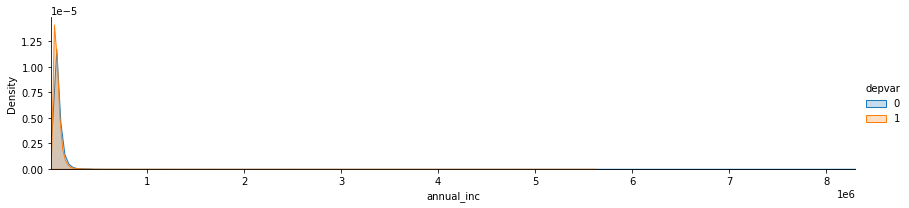

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'annual_inc',shade= True)
facet.set(xlim=(df['annual_inc'].min(), df['annual_inc'].max()))
facet.add_legend()

(0.0, 300000.0)

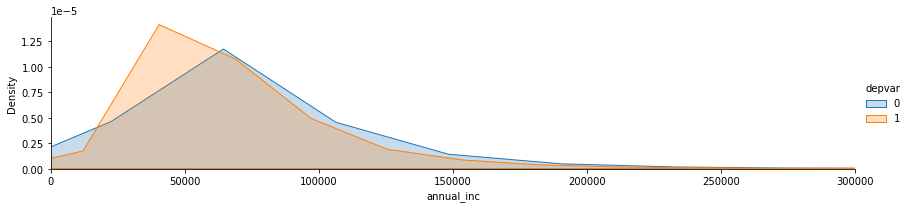

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'annual_inc',shade= True)
facet.set(xlim=(df['annual_inc'].min(), df['annual_inc'].max()))
facet.add_legend()

plt.xlim(0, 0.3e6)

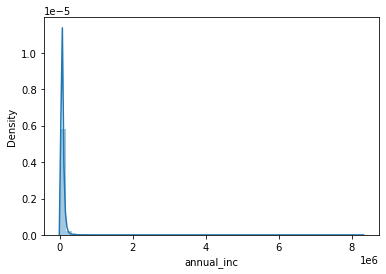

In [ ]:
sns.distplot(df['annual_inc'])

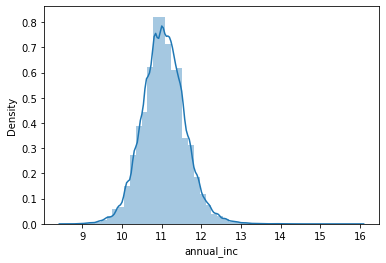

In [ ]:
sns.distplot(np.log1p(df['annual_inc']))

#### dti

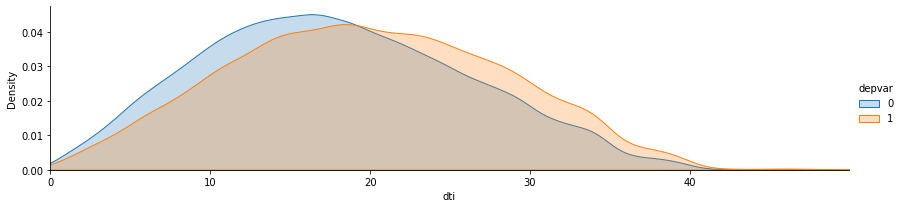

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'dti',shade= True)
facet.set(xlim=(df['dti'].min(), df['dti'].max()))
facet.add_legend()

#### revol_bal

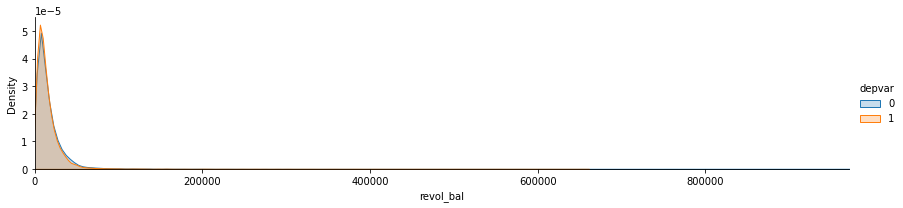

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'revol_bal',shade= True)
facet.set(xlim=(df['revol_bal'].min(), df['revol_bal'].max()))
facet.add_legend()

(0.0, 100000.0)

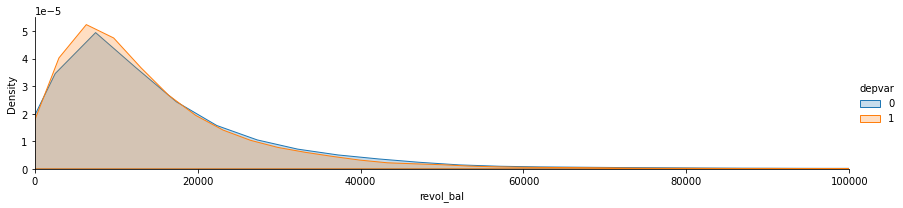

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'revol_bal',shade= True)
facet.set(xlim=(df['revol_bal'].min(), df['revol_bal'].max()))
facet.add_legend()

plt.xlim(df['revol_bal'].min(), 100000)

(40000.0, 971736.0)

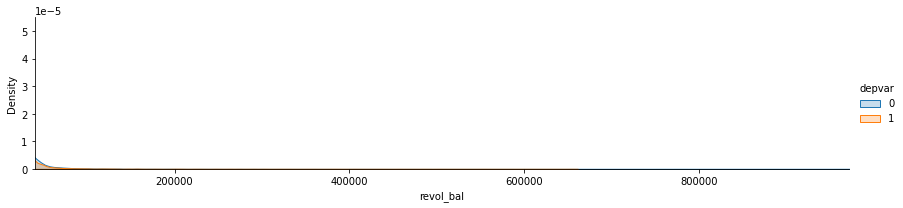

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'revol_bal',shade= True)
facet.set(xlim=(df['revol_bal'].min(), df['revol_bal'].max()))
facet.add_legend()

plt.xlim(40000, df['revol_bal'].max())

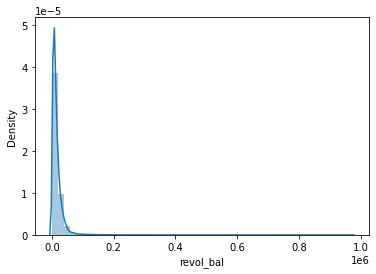

In [ ]:
sns.distplot(df['revol_bal'])

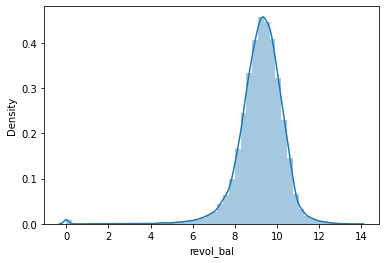

In [ ]:
sns.distplot(np.log1p(df['revol_bal']))

#### total_acc

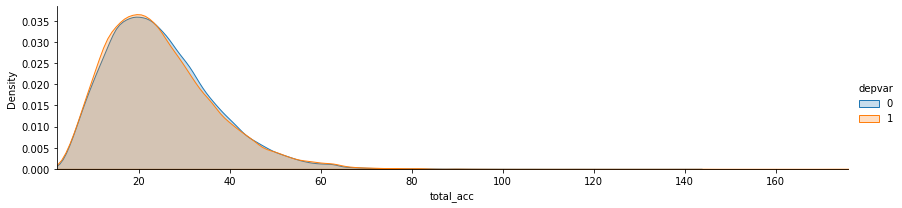

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_acc',shade= True)
facet.set(xlim=(df['total_acc'].min(), df['total_acc'].max()))
facet.add_legend()

(0.0, 80.0)

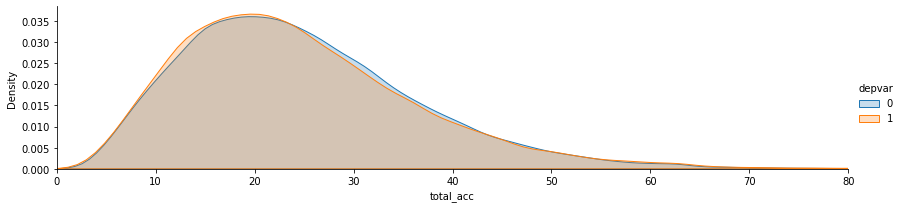

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_acc',shade= True)
facet.set(xlim=(df['total_acc'].min(), df['total_acc'].max()))
facet.add_legend()

plt.xlim(0, 80)

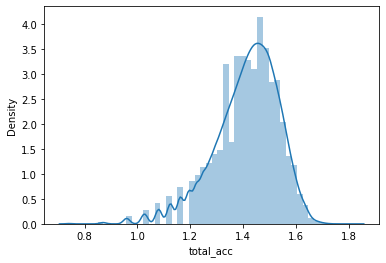

In [ ]:
sns.distplot(np.log1p(df['total_acc']))

#### tot_coll_amt

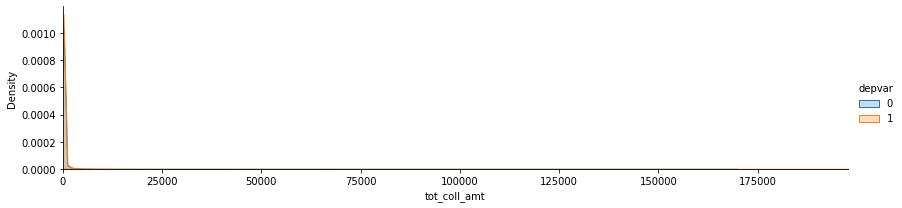

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'tot_coll_amt',shade= True)
facet.set(xlim=(df['tot_coll_amt'].min(), df['tot_coll_amt'].max()))
facet.add_legend()

(0.0, 3000.0)

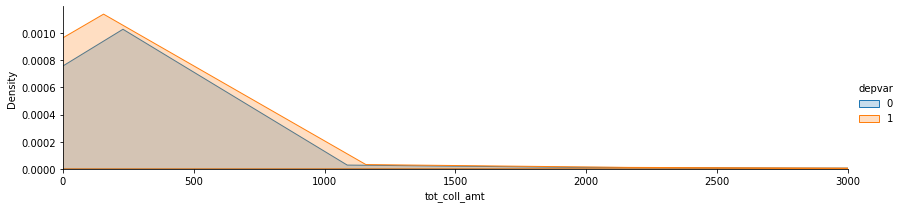

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'tot_coll_amt',shade= True)
facet.set(xlim=(df['tot_coll_amt'].min(), df['tot_coll_amt'].max()))
facet.add_legend()

plt.xlim(0, 3000)

(1000.0, 197765.0)

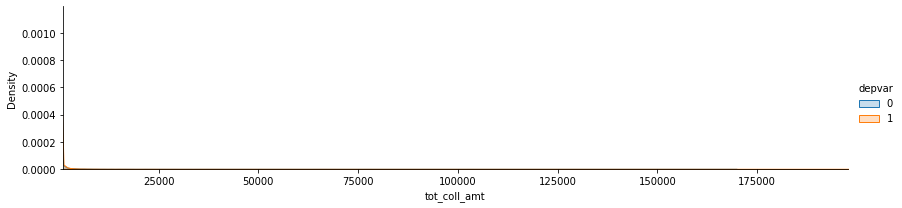

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'tot_coll_amt',shade= True)
facet.set(xlim=(df['tot_coll_amt'].min(), df['tot_coll_amt'].max()))
facet.add_legend()

plt.xlim(1000, df['tot_coll_amt'].max())

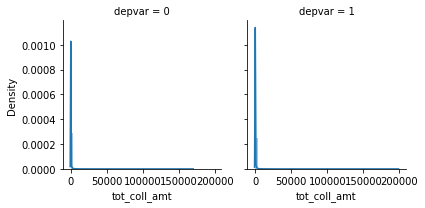

In [ ]:
sns.FacetGrid(df, col = 'depvar').map(sns.distplot, 'tot_coll_amt')

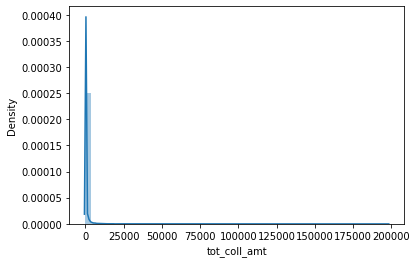

In [ ]:
sns.distplot(df['tot_coll_amt'])

(0.0, 10000.0)

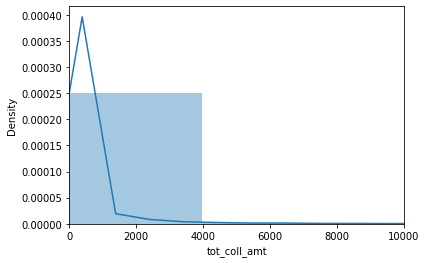

In [ ]:
sns.distplot(df['tot_coll_amt'])
plt.xlim(df['tot_coll_amt'].min(), 10000)

In [ ]:
df[df['tot_coll_amt']<4000].count()

int_rate           98688
annual_inc         98688
dti                98688
delinq_2yrs        98688
inq_last_6mths     98688
                   ...  
out_prncp_inv      98688
total_rec_int      98688
fico_range_low     98688
fico_range_high    98688
depvar             98688
Length: 76, dtype: int64

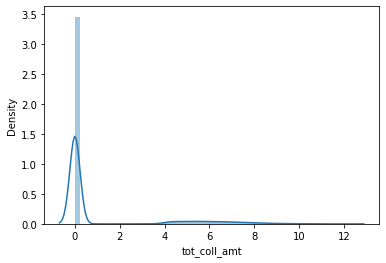

In [ ]:
sns.distplot(np.log1p(df['tot_coll_amt']))

#### tot_cur_bal

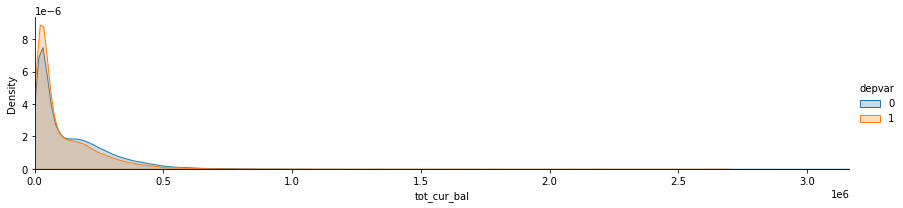

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'tot_cur_bal',shade= True)
facet.set(xlim=(df['tot_cur_bal'].min(), df['tot_cur_bal'].max()))
facet.add_legend()

(0.0, 700000.0)

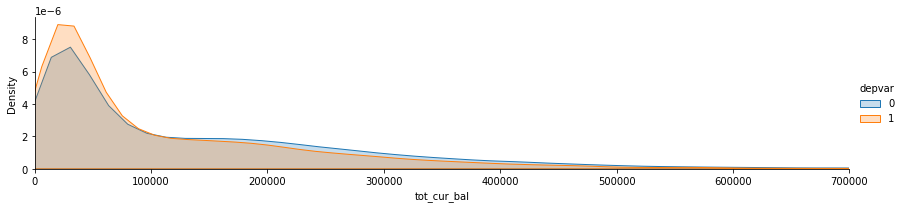

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'tot_cur_bal',shade= True)
facet.set(xlim=(df['tot_cur_bal'].min(), df['tot_cur_bal'].max()))
facet.add_legend()

plt.xlim(0, 0.7e6)

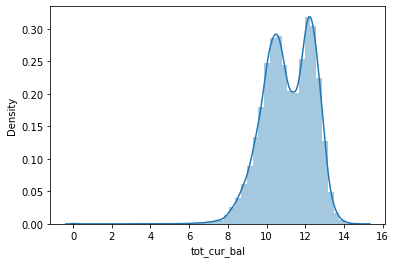

In [ ]:
sns.distplot(np.log1p(df['tot_cur_bal']))

#### delinq_amnt

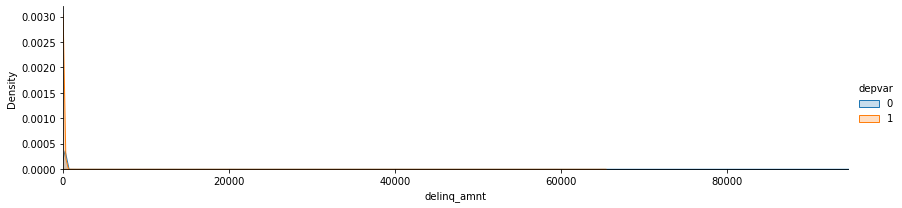

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'delinq_amnt',shade= True)
facet.set(xlim=(df['delinq_amnt'].min(), df['delinq_amnt'].max()))
facet.add_legend()

(0.0, 700.0)

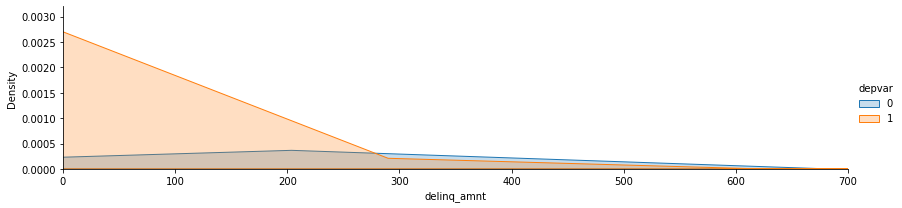

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'delinq_amnt',shade= True)
facet.set(xlim=(df['delinq_amnt'].min(), df['delinq_amnt'].max()))
facet.add_legend()

plt.xlim(0, 700)

(0.0, 280.0)

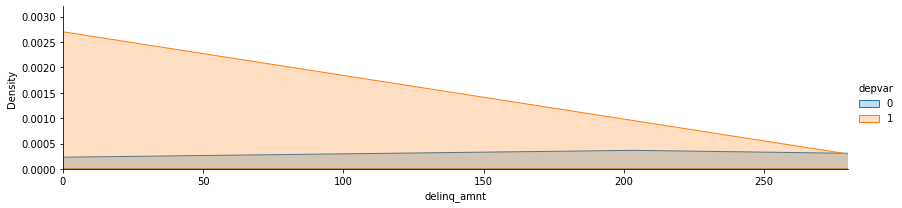

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'delinq_amnt',shade= True)
facet.set(xlim=(df['delinq_amnt'].min(), df['delinq_amnt'].max()))
facet.add_legend()

plt.xlim(0, 280)

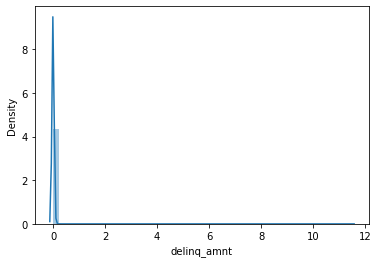

In [ ]:
sns.distplot(np.log1p(df['delinq_amnt']))

#### funded_amnt

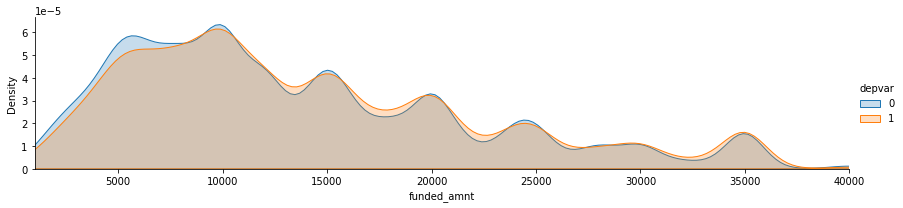

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'funded_amnt',shade= True)
facet.set(xlim=(df['funded_amnt'].min(), df['funded_amnt'].max()))
facet.add_legend()

#### funded_amnt_inv

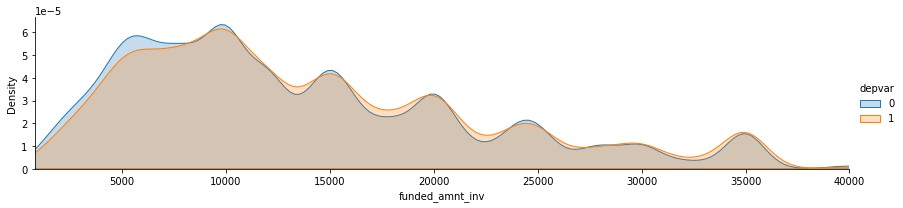

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'funded_amnt_inv',shade= True)
facet.set(xlim=(df['funded_amnt_inv'].min(), df['funded_amnt_inv'].max()))
facet.add_legend()

#### total_rec_late_fee

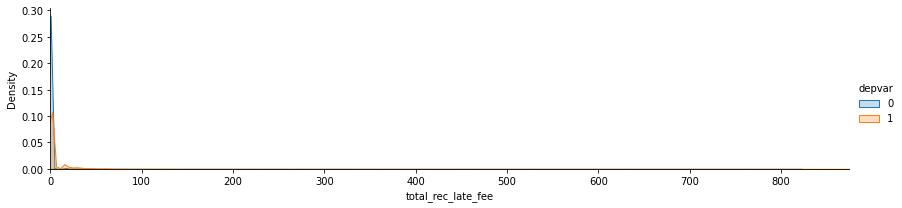

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

(0.0, 50.0)

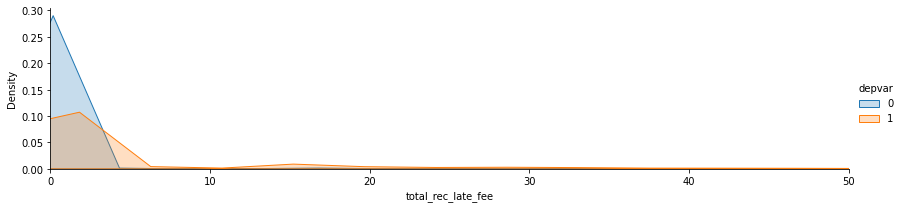

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(0, 50)

(-2e-09, 1.6)

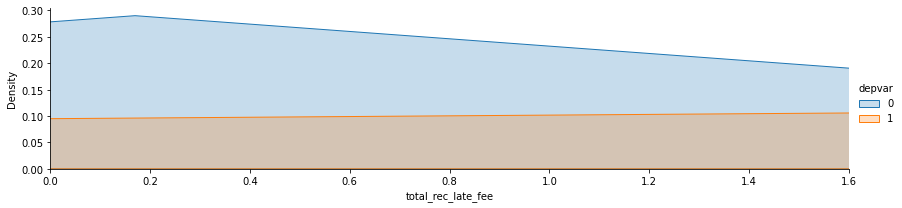

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(df['total_rec_late_fee'].min(), 3.2/2)

(1.6, 3.2)

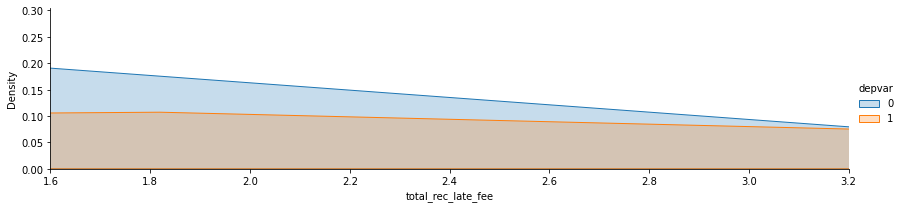

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(3.2/2, 3.2)

(3.2, 7.0)

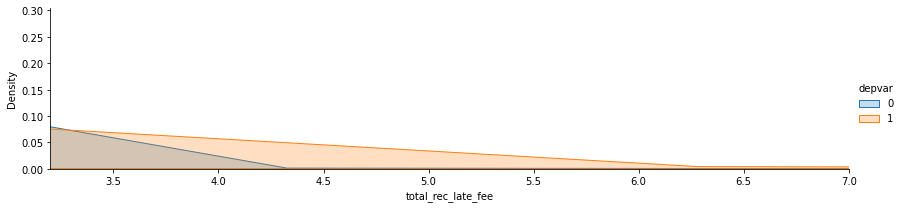

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(3.2, 7)

(7.0, 50.0)

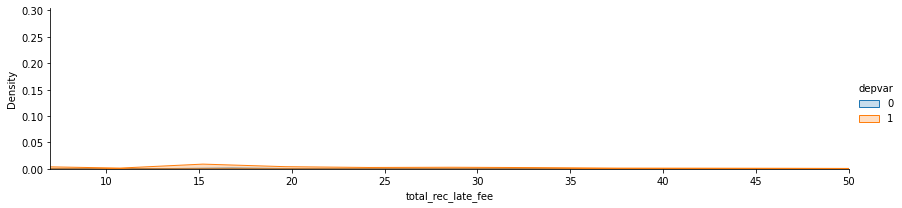

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(7, 50)

(50.0, 1000.0)

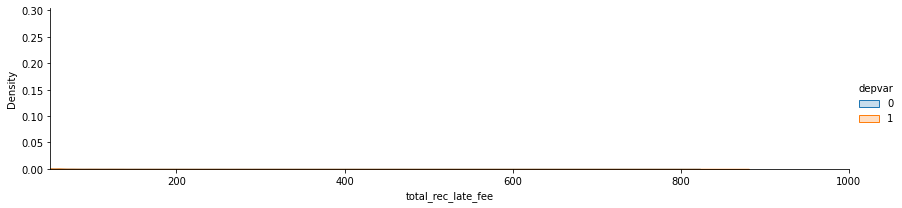

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_late_fee',shade= True)
facet.set(xlim=(df['total_rec_late_fee'].min(), df['total_rec_late_fee'].max()))
facet.add_legend()

plt.xlim(50, 1000)

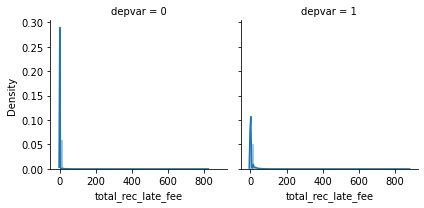

In [ ]:
sns.FacetGrid(df, col = 'depvar').map(sns.distplot, 'total_rec_late_fee')

874.17

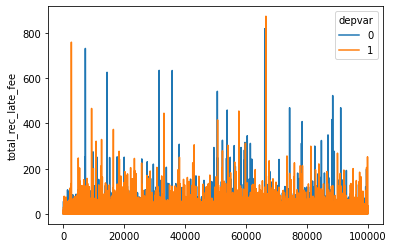

In [ ]:
sns.lineplot(x=range(len(df)), y=df['total_rec_late_fee'], data=df, hue='depvar')
df['total_rec_late_fee'].max()

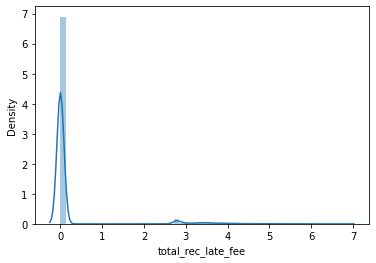

In [ ]:
sns.distplot(np.log1p(df['total_rec_late_fee']))

installment

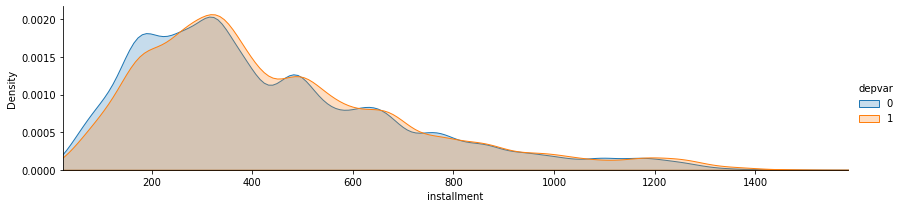

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'installment',shade= True)
facet.set(xlim=(df['installment'].min(), df['installment'].max()))
facet.add_legend()

(1400.0, 1584.9)

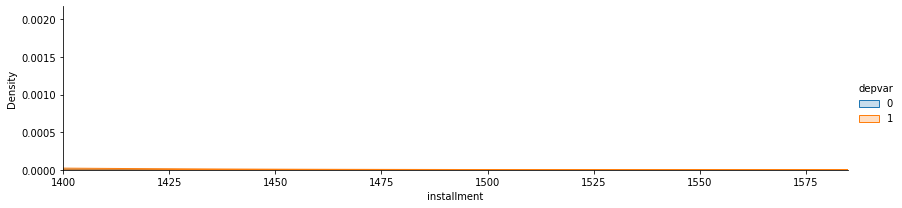

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'installment',shade= True)
facet.set(xlim=(df['installment'].min(), df['installment'].max()))
facet.add_legend()

plt.xlim(1400, df['installment'].max())

revol_util

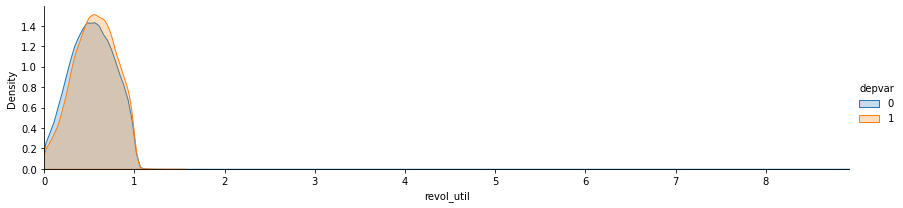

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'revol_util',shade= True)
facet.set(xlim=(df['revol_util'].min(), df['revol_util'].max()))
facet.add_legend()

In [ ]:
df.depvar[df['revol_util']>1.5].value_counts()

0    3
Name: depvar, dtype: int64

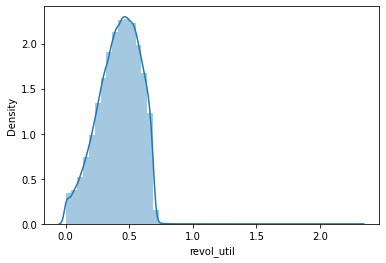

In [ ]:
sns.distplot(np.log1p(df['revol_util']))

out_prncp

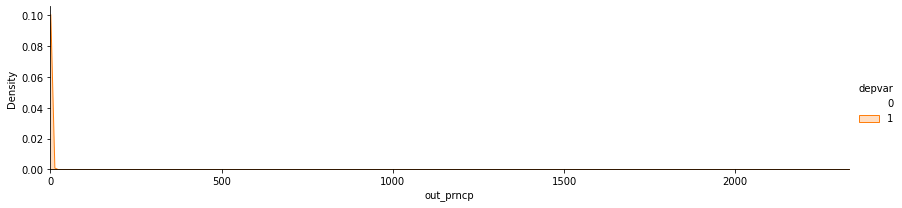

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'out_prncp',shade= True)
facet.set(xlim=(df['out_prncp'].min(), df['out_prncp'].max()))
facet.add_legend()

out_prncp_inv

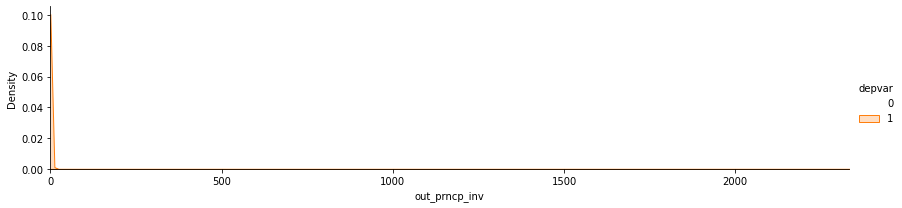

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'out_prncp_inv',shade= True)
facet.set(xlim=(df['out_prncp_inv'].min(), df['out_prncp_inv'].max()))
facet.add_legend()

(0.0, 100.0)

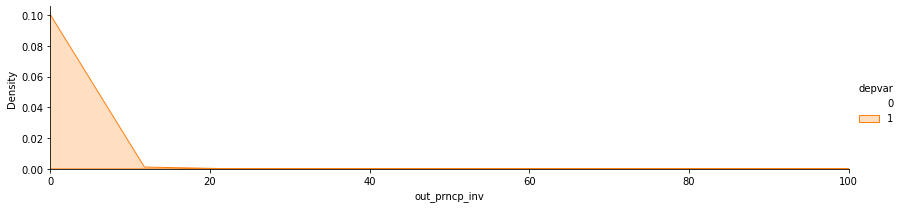

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'out_prncp_inv',shade= True)
facet.set(xlim=(df['out_prncp_inv'].min(), df['out_prncp_inv'].max()))
facet.add_legend()

plt.xlim(0, 100)

total_rec_int

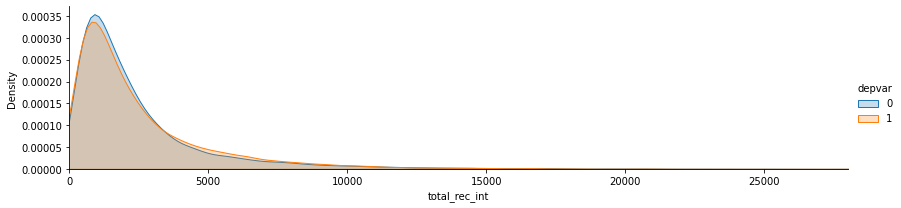

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'total_rec_int',shade= True)
facet.set(xlim=(df['total_rec_int'].min(), df['total_rec_int'].max()))
facet.add_legend()

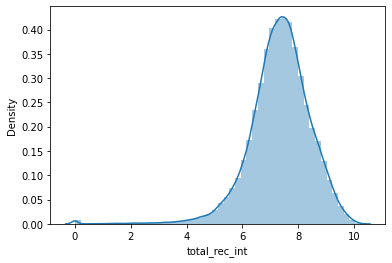

In [ ]:
sns.distplot(np.log1p(df['total_rec_int']))

fico_range_low

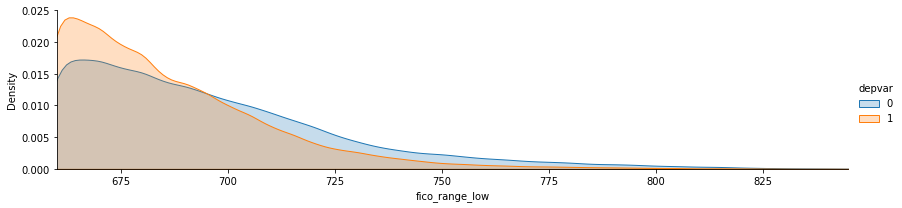

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'fico_range_low',shade= True)
facet.set(xlim=(df['fico_range_low'].min(), df['fico_range_low'].max()))
facet.add_legend()

fico_range_high

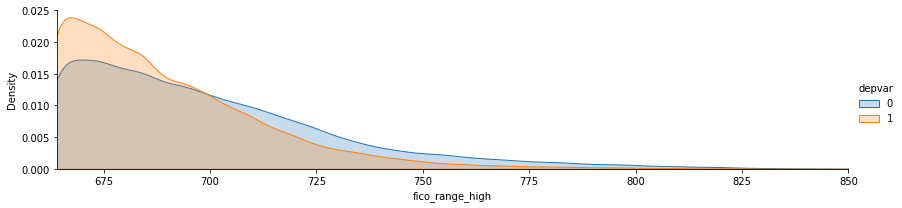

In [ ]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'fico_range_high',shade= True)
facet.set(xlim=(df['fico_range_high'].min(), df['fico_range_high'].max()))
facet.add_legend()

inq_last_6mths, term1, home_ownership, verification_status, purpose, int_rate, annual_inc, dti, tot_coll_amt, tot_cur_bal, delinq_amnt, funded_amnt, total_rec_late_fee, installment, revol_util, out_prncp, fico_range_low, fico_range_high

=> 그래프를 봤을 때, 시각적으로 부도 여부에 차이를 보이는 컬럼들

In [ ]:
df['fico_range_high'].value_counts

<bound method IndexOpsMixin.value_counts of 0        769
1        669
2        674
3        684
4        664
        ... 
99995    664
99996    769
99997    669
99998    714
99999    694
Name: fico_range_high, Length: 100000, dtype: int64>

## 2.2 시각화 결과에 따른 Feature 처리

In [217]:
# 이상치가 포함된 feature에 대해 데이터 바이닝을 진행할 함수(구간 5개로 나눔.)
def data_binning(df, feature, ref_num):
    df.loc[ df[feature] <= ref_num*1/4, feature] = 1
    df.loc[(df[feature] > ref_num*1/4) & (df[feature] <= ref_num*2/4), feature] = 2
    df.loc[(df[feature] > ref_num*2/4) & (df[feature] <= ref_num*3/4), feature] = 3
    df.loc[(df[feature] > ref_num*3/4) & (df[feature] <= ref_num*4/4), feature] = 4
    df.loc[ df[feature] > ref_num*4/4, feature] = 5

    return df[feature]

### 2.2.1 annual_inc

In [218]:
# log값으로 변환하여 데이터의 심한 분포 왜곡을 개선
df['annual_inc'] = np.log1p(df['annual_inc'])

In [219]:
# 임의의 기준값 이상은 일정한 최대값으로 설정
# df.annual_inc[df['annual_inc'] > 3.0e5] = 3.0e5

In [220]:
# 직접 작성한 함수로 데이터 바이닝 수행
# df['annual_inc'] = data_binning(df, 'annual_inc', 0.2e6)
# df['annual_inc']

(array([1.3700e+02, 2.6570e+03, 2.7545e+04, 5.2654e+04, 1.5233e+04,
        1.5740e+03, 1.6300e+02, 2.9000e+01, 2.0000e+00, 6.0000e+00]),
 array([ 8.5869058 ,  9.32139184, 10.05587788, 10.79036392, 11.52484996,
        12.259336  , 12.99382204, 13.72830808, 14.46279412, 15.19728015,
        15.93176619]),
 <a list of 10 Patch objects>)

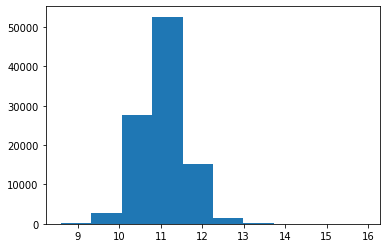

In [221]:
plt.hist(df['annual_inc'])

### 2.2.2 revol_bal

In [222]:
# log값으로 변환하여 데이터의 심한 분포 왜곡을 개선
df['revol_bal'] = np.log1p(df['revol_bal'])

In [223]:
# df.revol_bal[df['revol_bal'] > 100000] = 100000

In [224]:
# df['revol_bal'] = data_binning(df, 'revol_bal', 40000)
# df['revol_bal']

### 2.2.3 total_acc

In [225]:
# log값으로 변환하여 데이터의 심한 분포 왜곡을 개선
df['total_acc'] = np.log1p(df['total_acc'])

In [226]:
# df.total_acc[df['total_acc'] > 80] = 80

In [227]:
# df['total_acc'] = data_binning(df, 'total_acc', 60)
# df['total_acc']

### 2.2.4 tot_coll_amt

(array([9.9817e+04, 1.4600e+02, 2.4000e+01, 6.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([     0. ,  19776.5,  39553. ,  59329.5,  79106. ,  98882.5,
        118659. , 138435.5, 158212. , 177988.5, 197765. ]),
 <a list of 10 Patch objects>)

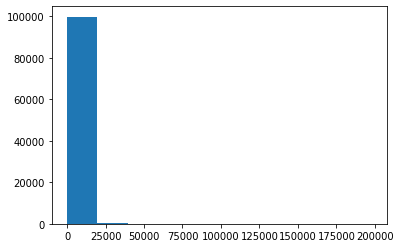

In [228]:
plt.hist(df['tot_coll_amt'])

In [229]:
# df.tot_coll_amt[df['tot_coll_amt'] > 60000] = 60000

(array([9.9568e+04, 3.1900e+02, 7.0000e+01, 2.4000e+01, 4.0000e+00,
        7.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-2.00000e-09,  8.74170e+01,  1.74834e+02,  2.62251e+02,
         3.49668e+02,  4.37085e+02,  5.24502e+02,  6.11919e+02,
         6.99336e+02,  7.86753e+02,  8.74170e+02]),
 <a list of 10 Patch objects>)

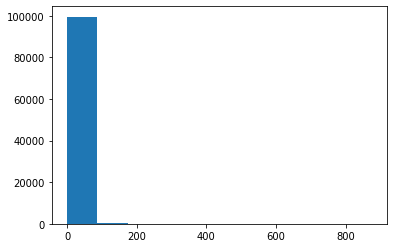

In [230]:
# df['tot_coll_amt'] = data_binning(df, 'tot_coll_amt', 1000)
# df['tot_coll_amt']
# df.loc[ df['tot_coll_amt'] <= 3.2/2, 'tot_coll_amt'] = 1
# df.loc[(df['tot_coll_amt'] > 3.2/2) & (df['tot_coll_amt'] <= 3.2), 'tot_coll_amt'] = 2
# df.loc[(df['tot_coll_amt'] > 3.2) & (df['tot_coll_amt'] <= 7), 'tot_coll_amt'] = 3
# df.loc[(df['tot_coll_amt'] > 7) & (df['tot_coll_amt'] <= 50), 'tot_coll_amt'] = 4
# df.loc[ df['tot_coll_amt'] > 50, 'tot_coll_amt'] = 5

# print(df['total_rec_late_fee'])
plt.hist(df['total_rec_late_fee'])

(array([9.9817e+04, 1.4600e+02, 2.4000e+01, 6.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([     0. ,  19776.5,  39553. ,  59329.5,  79106. ,  98882.5,
        118659. , 138435.5, 158212. , 177988.5, 197765. ]),
 <a list of 10 Patch objects>)

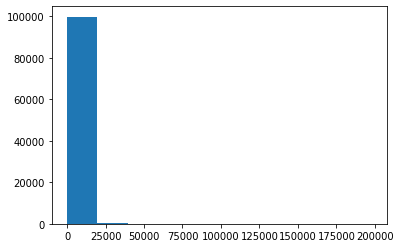

In [231]:
plt.hist(df.tot_coll_amt)

In [232]:
df.depvar[df['tot_coll_amt']==60000].value_counts()

Series([], Name: depvar, dtype: int64)

### 2.2.5 tot_cur_bal

In [233]:
# log값으로 변환하여 데이터의 심한 분포 왜곡을 개선
df['tot_cur_bal'] = np.log1p(df['tot_cur_bal'])

In [234]:
# df.tot_cur_bal[df['tot_cur_bal'] > 0.7e6] = 0.7e6

In [235]:
# df['tot_cur_bal'] = data_binning(df, 'tot_cur_bal', 0.5e6)
# print(df['tot_cur_bal'])
# plt.hist(df['tot_cur_bal'])

### 2.2.6 delinq_amnt

(array([9.9953e+04, 1.5000e+01, 8.0000e+00, 7.0000e+00, 2.0000e+00,
        2.0000e+00, 1.2000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  9452.1, 18904.2, 28356.3, 37808.4, 47260.5, 56712.6,
        66164.7, 75616.8, 85068.9, 94521. ]),
 <a list of 10 Patch objects>)

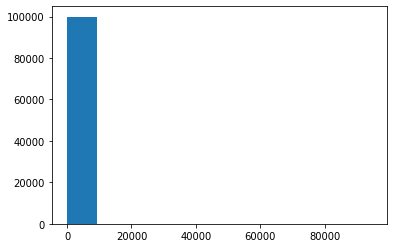

In [236]:
plt.hist(df['delinq_amnt'])

In [237]:
df.delinq_amnt[df['delinq_amnt'] > 700] = 700

(array([9.9686e+04, 4.7000e+01, 3.3000e+01, 2.4000e+01, 1.9000e+01,
        1.5000e+01, 1.5000e+01, 9.0000e+00, 6.0000e+00, 1.4600e+02]),
 array([  0.,  70., 140., 210., 280., 350., 420., 490., 560., 630., 700.]),
 <a list of 10 Patch objects>)

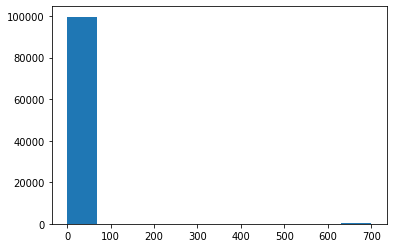

In [238]:
# df['delinq_amnt'] = data_binning(df, 'delinq_amnt', 280)
# print(df['delinq_amnt'])
plt.hist(df['delinq_amnt'])

(0.0, 70.0)

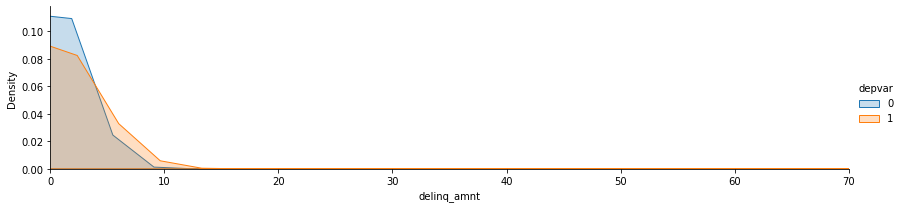

In [239]:
facet = sns.FacetGrid(df, hue="depvar",aspect=4)
facet.map(sns.kdeplot,'delinq_amnt',shade= True)
facet.set(xlim=(df['delinq_amnt'].min(), df['delinq_amnt'].max()))
facet.add_legend()
plt.xlim(0, 70)

### 2.2.7 total_rec_late_fee

(array([9.9568e+04, 3.1900e+02, 7.0000e+01, 2.4000e+01, 4.0000e+00,
        7.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-2.00000e-09,  8.74170e+01,  1.74834e+02,  2.62251e+02,
         3.49668e+02,  4.37085e+02,  5.24502e+02,  6.11919e+02,
         6.99336e+02,  7.86753e+02,  8.74170e+02]),
 <a list of 10 Patch objects>)

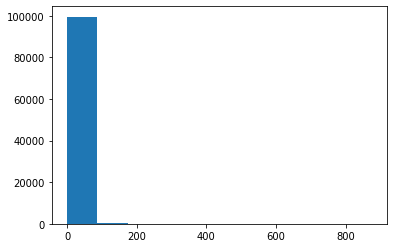

In [240]:
plt.hist(df['total_rec_late_fee'])

In [241]:
df.total_rec_late_fee[df['total_rec_late_fee'] > 50] = 50

(array([9.3451e+04, 5.0000e+00, 3.1000e+01, 2.7180e+03, 5.3200e+02,
        4.7100e+02, 7.9800e+02, 2.8300e+02, 2.4700e+02, 1.4640e+03]),
 array([-2.0e-09,  5.0e+00,  1.0e+01,  1.5e+01,  2.0e+01,  2.5e+01,
         3.0e+01,  3.5e+01,  4.0e+01,  4.5e+01,  5.0e+01]),
 <a list of 10 Patch objects>)

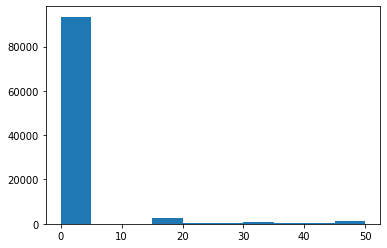

In [242]:
# df.loc[ df['total_rec_late_fee'] <= 3.2, 'total_rec_late_fee'] = 1
# df.loc[(df['total_rec_late_fee'] > 3.2) & (df['total_rec_late_fee'] <= 7), 'total_rec_late_fee'] = 2
# df.loc[(df['total_rec_late_fee'] > 7) & (df['total_rec_late_fee'] <= 50), 'total_rec_late_fee'] = 3
# df.loc[ df['total_rec_late_fee'] > 50, 'total_rec_late_fee'] = 4

# print(df['total_rec_late_fee'])
plt.hist(df['total_rec_late_fee'])

In [243]:
df.depvar[df['total_rec_late_fee']<50].value_counts()

0    67042
1    31793
Name: depvar, dtype: int64

In [244]:
df.depvar[df['total_rec_late_fee']==50].value_counts()

1    776
0    389
Name: depvar, dtype: int64

### 2.2.8 revol_util

In [245]:
# plt.hist(df['revol_util'])

(array([5.8420e+03, 1.1921e+04, 1.8967e+04, 2.1802e+04, 2.0069e+04,
        1.4831e+04, 6.5000e+03, 5.4000e+01, 8.0000e+00, 6.0000e+00]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ]),
 <a list of 10 Patch objects>)

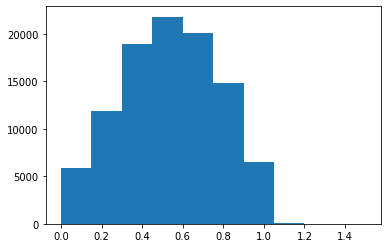

In [246]:
df.revol_util[df['revol_util'] > 1.5] = 1.5
plt.hist(df['revol_util'])

### 2.2.9 out_prncp & out_prncp_inv

(array([9.9976e+04, 1.0000e+00, 8.0000e+00, 1.0000e+00, 6.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   0.   ,  233.097,  466.194,  699.291,  932.388, 1165.485,
        1398.582, 1631.679, 1864.776, 2097.873, 2330.97 ]),
 <a list of 10 Patch objects>)

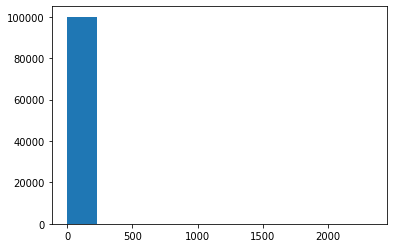

In [247]:
plt.hist(df['out_prncp'])

(array([9.9973e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

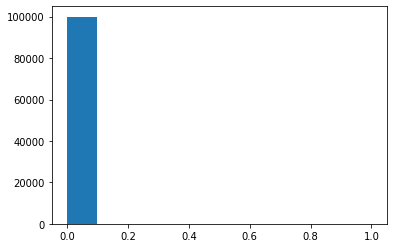

In [248]:
df.out_prncp[df['out_prncp'] > 0] = 1
df.out_prncp[df['out_prncp_inv'] > 0] = 1
plt.hist(df['out_prncp'])

### 2.2.10 일부 원핫인코딩 Feature를 수치형으로 수정

In [249]:
def inverse_encoding(dataframe, col_name, max_num):
    temp_f = lambda x: np.argmax(x) + 1
    col_list = [col_name + str(i) for i in range(1, max_num+1)]
    dataframe[col_name] = dataframe[col_list].apply(temp_f, axis='columns')
    dataframe = dataframe.drop(col_list, axis='columns')
    return dataframe
    
to_change_cols = ['emp_length', 'mths_since_last_delinq']
to_change_length = [12, 11]

for i in range(len(to_change_cols)):
    df = inverse_encoding(df, to_change_cols[i], to_change_length[i])

df

int_rate  annual_inc    dti  ...  depvar  emp_length  mths_since_last_delinq
0        0.0824    9.952325  29.19  ...       0           1                       1
1        0.1299   11.289794   4.82  ...       0           2                       1
2        0.1299   10.545368  23.66  ...       0           4                      11
3        0.1367   11.512935  16.27  ...       1           3                       5
4        0.1269   10.308986  25.28  ...       1           4                       1
...         ...         ...    ...  ...     ...         ...                     ...
99995    0.1757   11.082158  17.67  ...       1           7                       1
99996    0.0890   11.082158   2.88  ...       0          11                       1
99997    0.1349   10.736418  32.12  ...       0           4                       1
99998    0.2115   10.341775   4.53  ...       1          12                       1
99999    0.1599   11.736077  33.33  ...       0           5                       1

[100000 rows x 55 columns]

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  float64
 7   total_acc                   100000 non-null  float64
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  float64
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

## 2.3 이상치 및 필요 없다고 판단되는 feature 제거

이상치 제거할 feature: int_rate, fico_range_low, fico_range_high

큰 영향이 없다고 판단되는 feature: delinq_2yrs, inq_last_6mths, collections_12_mths_ex_med, tot_coll_amt, chargeoff_within_12_mths, delinq_amnt, tax_liens, total_rec_late_fee

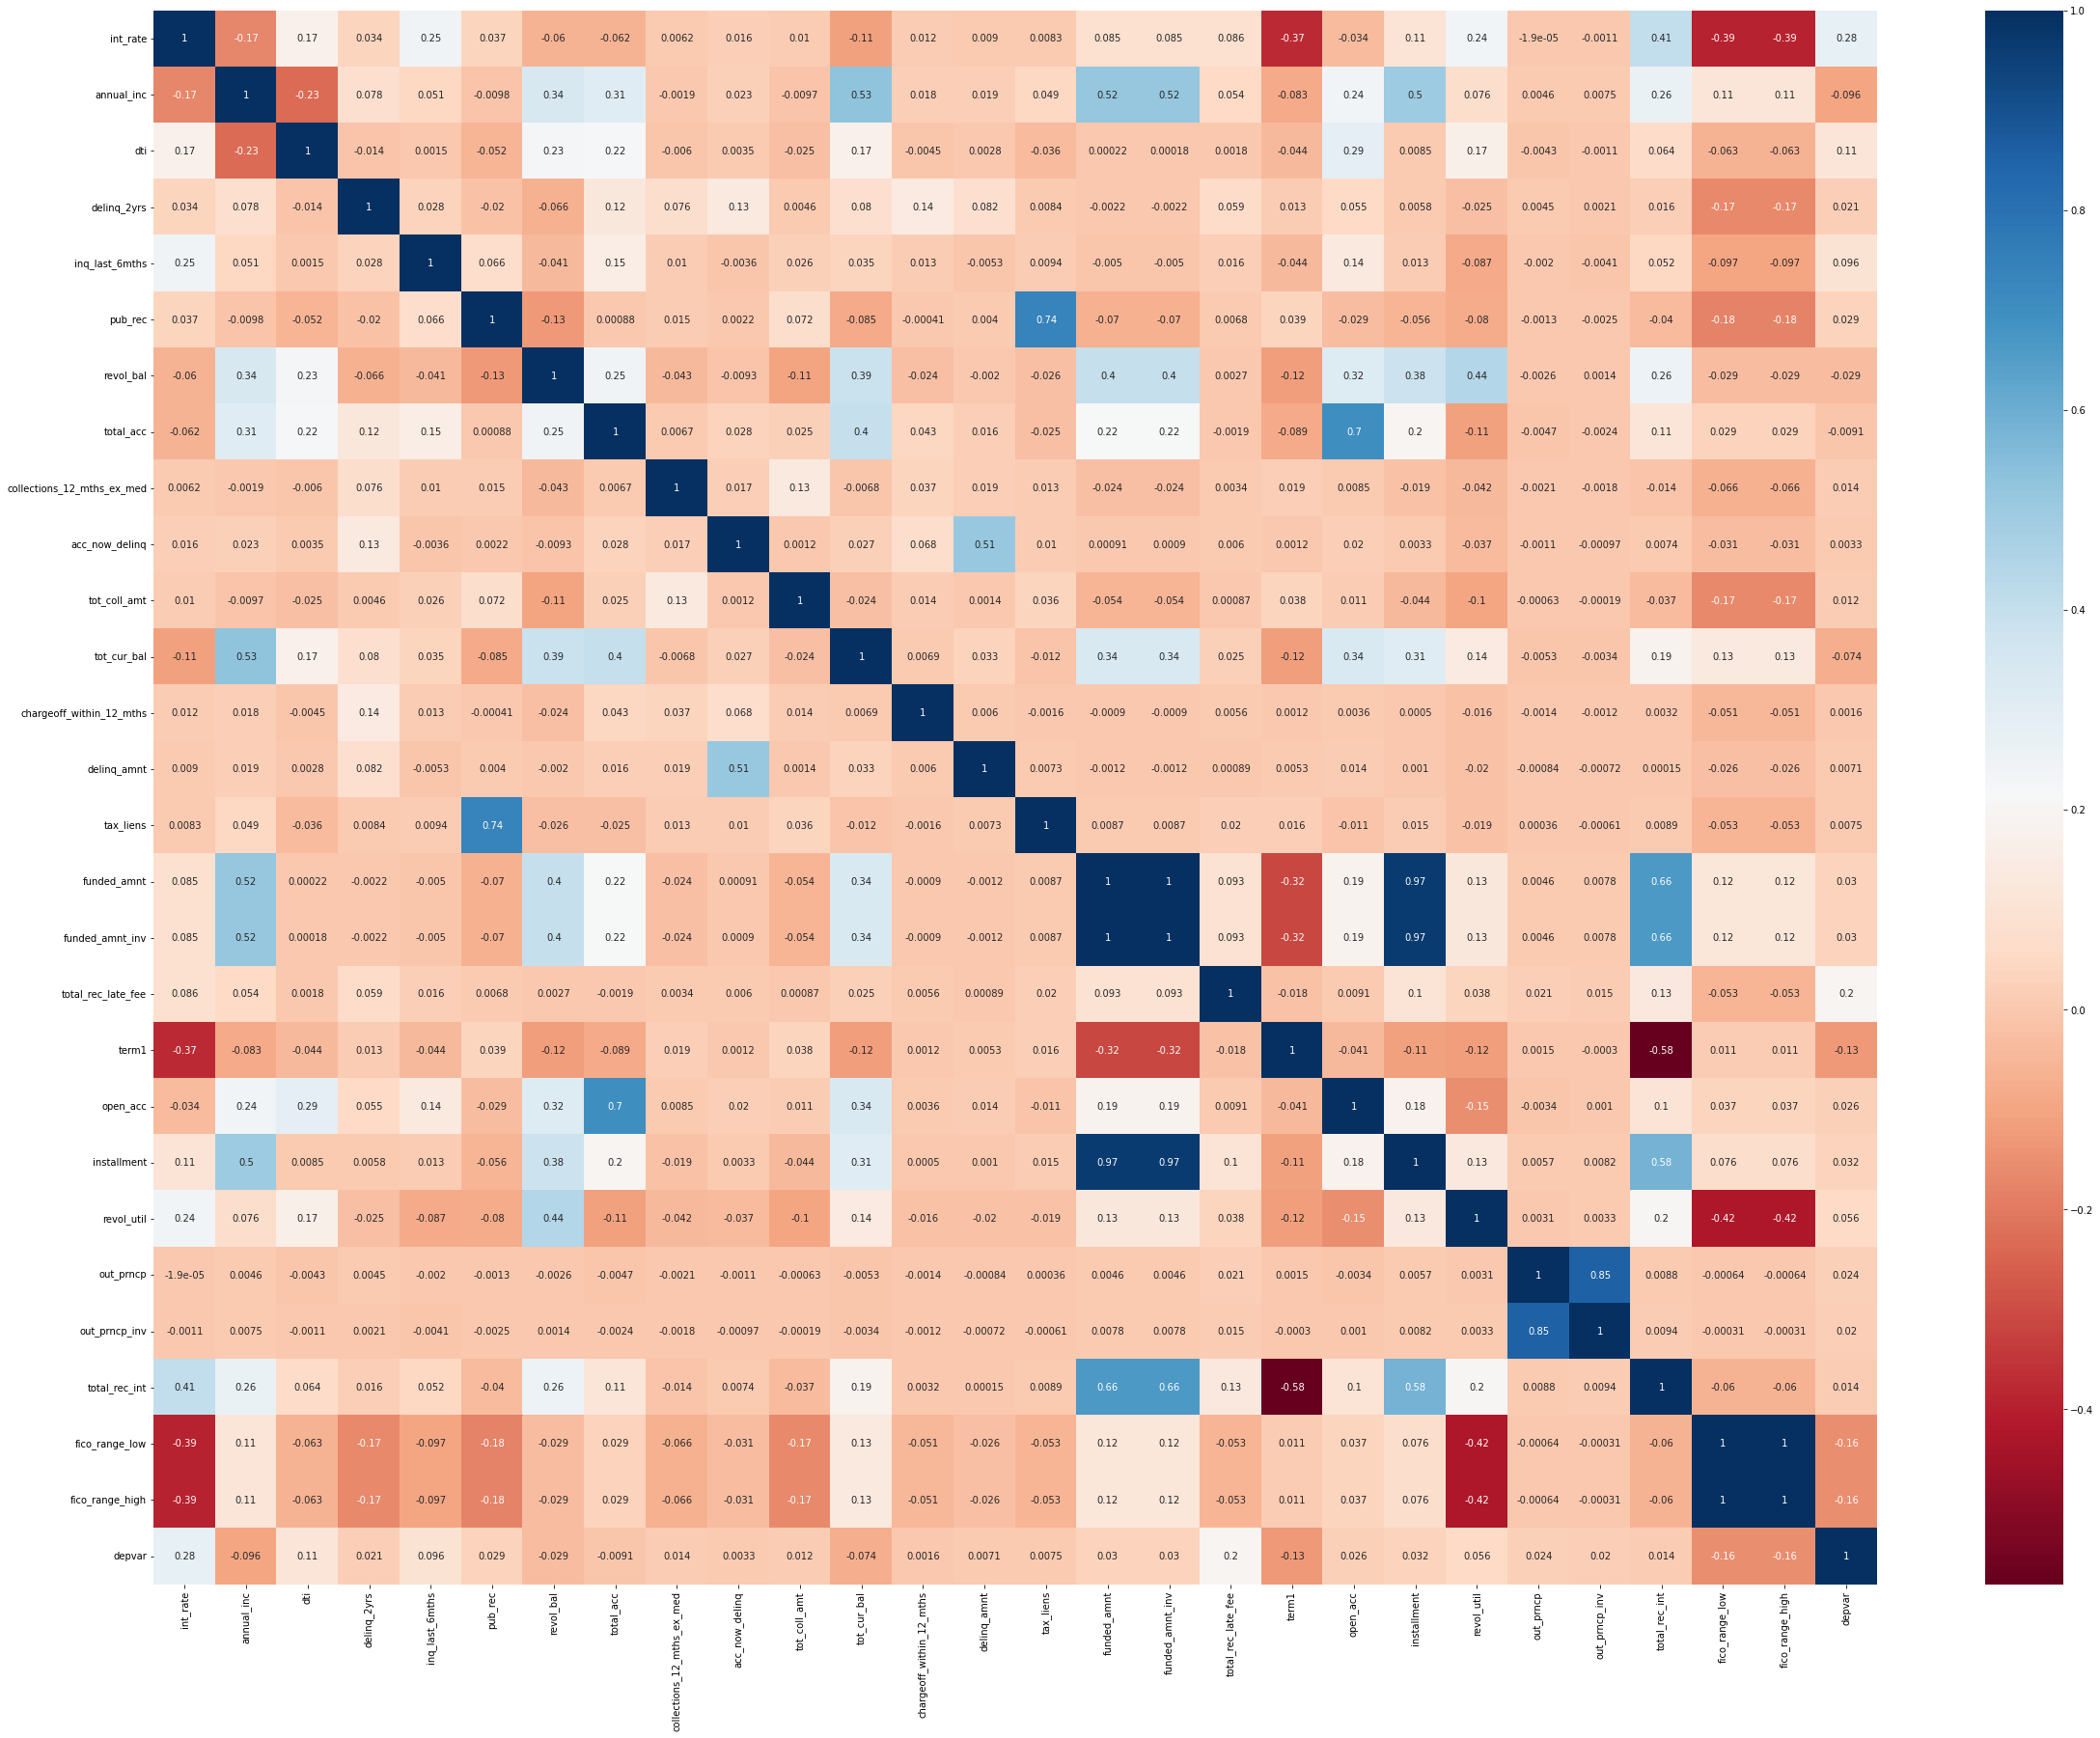

In [ ]:
# 로그 변환 및 Feature 처리 후, 상관관계 재확인
def inverse_encoding(dataframe, col_name, max_num):
    temp_f = lambda x: np.argmax(x) + 1
    col_list = [col_name + str(i) for i in range(1, max_num+1)]
    dataframe[col_name] = dataframe[col_list].apply(temp_f, axis='columns')
    dataframe = dataframe.drop(col_list, axis='columns')
    return dataframe
    

my_df = df.copy()
to_change_cols = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'mths_since_last_delinq']
to_change_nums = [12, 6, 3, 14, 2, 11]

for i in range(len(to_change_cols)):
    my_df = inverse_encoding(my_df, to_change_cols[i], to_change_nums[i])
    my_df[to_change_cols[i]] = my_df[to_change_cols[i]].astype('category')

plt.figure(figsize = (40, 30))
sns.heatmap(my_df.corr(), annot = True, cmap='RdBu')

### 2.3.1 이상치 제거 -> 최종 결과엔 적용 X

In [ ]:
# IQR을 이용한 이상치 제거
# depvar의 값이 1일 때
def remove_outlier_1(dataframe, columns):
    for col in columns:
        fraud_df = dataframe[dataframe['depvar'] == 1]
        fraud = fraud_df[col]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)

        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * 1.5

        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight

        outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
        print(col, '이상치 데이터 인덱스:', outlier_index)
        
        dataframe.drop(outlier_index, axis=0, inplace=True)
        print('df shape: ', dataframe.shape)

    return dataframe

df = remove_outlier_1(df, ['int_rate',  'fico_range_low', 'fico_range_high'])

int_rate 이상치 데이터 인덱스: Int64Index([  178,  2698,  2885,  3243,  3278,  4767,  5815,  7088,  7109,
             7563,
            ...
            92844, 95286, 95288, 95558, 97509, 97716, 97731, 97901, 98173,
            98943],
           dtype='int64', length=121)
df shape:  (99879, 76)
fico_range_low 이상치 데이터 인덱스: Int64Index([  127,   252,   306,   345,   365,   414,   417,   700,   820,
              915,
            ...
            98664, 98768, 98773, 98881, 98884, 99082, 99148, 99292, 99605,
            99723],
           dtype='int64', length=843)
df shape:  (99036, 76)
fico_range_high 이상치 데이터 인덱스: Int64Index([   16,   146,   243,   860,  2496,  2595,  3336,  4079,  4289,
             4896,
            ...
            95712, 97323, 97533, 97779, 98024, 98077, 98222, 98649, 99118,
            99930],
           dtype='int64', length=203)
df shape:  (98833, 76)


In [ ]:
# IQR을 이용한 이상치 제거
# depvar의 값이 0일 때
def remove_outlier_0(dataframe, columns):
    for col in columns:
        fraud_df = dataframe[dataframe['depvar'] == 0]
        fraud = fraud_df[col]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)

        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * 1.5

        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight

        outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
        print(col, '이상치 데이터 인덱스:', outlier_index)
        
        dataframe.drop(outlier_index, axis=0, inplace=True)
        print('df shape: ', dataframe.shape)

    return dataframe

df = remove_outlier_0(df, ['int_rate',  'fico_range_low', 'fico_range_high'])

int_rate 이상치 데이터 인덱스: Int64Index([   39,    68,   162,   273,   341,   363,   435,   441,   556,
              571,
            ...
            99185, 99227, 99297, 99387, 99546, 99569, 99673, 99883, 99928,
            99981],
           dtype='int64', length=1158)
df shape:  (97675, 76)
fico_range_low 이상치 데이터 인덱스: Int64Index([   20,    26,   116,   217,   292,   303,   340,   448,   457,
              491,
            ...
            99681, 99689, 99710, 99711, 99741, 99771, 99806, 99841, 99862,
            99952],
           dtype='int64', length=2172)
df shape:  (95503, 76)
fico_range_high 이상치 데이터 인덱스: Int64Index([], dtype='int64')
df shape:  (95503, 76)


### 2.3.2 필요 없다고 판단되는 feature 제거

In [ ]:
# df.drop(['delinq_2yrs', 'inq_last_6mths', 'collections_12_mths_ex_med', 'tot_coll_amt', 
#          'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'total_rec_late_fee'], axis=1, inplace=True)

In [251]:
df.drop(['purpose4', 'home_ownership4', 'purpose14', 'purpose11', 'home_ownership1', 'acc_now_delinq', 'home_ownership3', 'purpose1'],
        axis = 1, inplace=True)

## 2.4 Features 정규화 -> 최종 결과엔 적용 X

In [252]:
X = df.drop(['depvar'], axis=1)
y = df['depvar']

X, y

(       int_rate  annual_inc  ...  emp_length  mths_since_last_delinq
 0        0.0824    9.952325  ...           1                       1
 1        0.1299   11.289794  ...           2                       1
 2        0.1299   10.545368  ...           4                      11
 3        0.1367   11.512935  ...           3                       5
 4        0.1269   10.308986  ...           4                       1
 ...         ...         ...  ...         ...                     ...
 99995    0.1757   11.082158  ...           7                       1
 99996    0.0890   11.082158  ...          11                       1
 99997    0.1349   10.736418  ...           4                       1
 99998    0.2115   10.341775  ...          12                       1
 99999    0.1599   11.736077  ...           5                       1
 
 [100000 rows x 46 columns], 0        0
 1        0
 2        0
 3        1
 4        1
         ..
 99995    1
 99996    0
 99997    0
 99998    1
 99999    

### 2.4.1 Min-Max 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled_minmax = minmax_scaler.fit_transform(X)

round(pd.DataFrame(X_scaled_minmax), 2)

0     1     2    3     4     5   ...    69   70   71    72    73    74
0      0.11  0.19  0.58  0.0  0.17  0.00  ...  0.05  0.0  0.0  0.01  0.57  0.56
1      0.30  0.37  0.10  0.0  0.17  0.02  ...  0.30  0.0  0.0  0.06  0.03  0.03
2      0.30  0.27  0.47  0.0  0.50  0.00  ...  0.59  0.0  0.0  0.04  0.05  0.05
3      0.33  0.40  0.33  0.2  0.33  0.00  ...  0.30  0.0  0.0  0.04  0.11  0.11
4      0.29  0.23  0.51  0.0  0.17  0.03  ...  0.28  0.0  0.0  0.03  0.00  0.00
...     ...   ...   ...  ...   ...   ...  ...   ...  ...  ...   ...   ...   ...
99995  0.48  0.34  0.35  0.0  0.50  0.02  ...  0.52  0.0  0.0  0.19  0.00  0.00
99996  0.14  0.34  0.06  0.0  0.00  0.00  ...  0.08  0.0  0.0  0.03  0.57  0.56
99997  0.32  0.29  0.64  0.0  0.17  0.00  ...  0.43  0.0  0.0  0.05  0.03  0.03
99998  0.62  0.24  0.09  0.0  0.17  0.00  ...  0.49  0.0  0.0  0.05  0.27  0.27
99999  0.42  0.43  0.67  0.0  0.00  0.00  ...  0.33  0.0  0.0  0.32  0.16  0.16

[100000 rows x 75 columns]

### 2.4.2 Z-Score 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_scaled_std = std_scaler.fit_transform(X)

round(pd.DataFrame(X_scaled_std), 2)

0     1     2     3     4     5   ...    69    70    71    72    73    74
0     -1.08 -2.03  1.27 -0.38  0.35 -0.36  ... -1.94 -0.02 -0.01 -0.86  2.44  2.44
1     -0.02  0.43 -1.63 -0.38  0.35  1.16  ... -0.38 -0.02 -0.01 -0.29 -0.93 -0.93
2     -0.02 -0.94  0.61 -0.38  2.45 -0.36  ...  1.44 -0.02 -0.01 -0.53 -0.76 -0.76
3      0.13  0.84 -0.27  4.04  1.40 -0.36  ... -0.34 -0.02 -0.01 -0.46 -0.43 -0.43
4     -0.09 -1.38  0.80 -0.38  0.35  2.67  ... -0.51 -0.02 -0.01 -0.60 -1.10 -1.10
...     ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
99995  1.00  0.05 -0.10 -0.38  2.45  1.16  ...  1.02 -0.02 -0.01  1.06 -1.10 -1.10
99996 -0.93  0.05 -1.86 -0.38 -0.70 -0.36  ... -1.75 -0.02 -0.01 -0.61  2.44  2.44
99997  0.09 -0.59  1.62 -0.38  0.35 -0.36  ...  0.44 -0.02 -0.01 -0.45 -0.93 -0.93
99998  1.80 -1.32 -1.66 -0.38  0.35 -0.36  ...  0.81 -0.02 -0.01 -0.42  0.59  0.59
99999  0.65  1.25  1.76 -0.38 -0.70 -0.36  ... -0.16 -0.02 -0.01  2.36 -0.09 -0.09

[100000 rows x 75 columns]

In [ ]:
df_scaled = pd.DataFrame(data=X_scaled_std, columns=X.columns)
df_scaled

int_rate  annual_inc  ...  fico_range_low  fico_range_high
0     -1.081759   -0.714584  ...        2.439321         2.439270
1     -0.020849    0.075520  ...       -0.931329        -0.931315
2     -0.020849   -0.486927  ...       -0.762797        -0.762786
3      0.131028    0.343352  ...       -0.425732        -0.425727
4     -0.087854   -0.594059  ...       -1.099862        -1.099844
...         ...         ...  ...             ...              ...
99995  1.002092   -0.125353  ...       -1.099862        -1.099844
99996 -0.934349   -0.125353  ...        2.439321         2.439270
99997  0.090826   -0.379794  ...       -0.931329        -0.931315
99998  1.801683   -0.580668  ...        0.585463         0.585448
99999  0.649199    0.678142  ...       -0.088667        -0.088669

[100000 rows x 75 columns]

In [ ]:
# import scipy as sp

# df_Zscore = pd.DataFrame()
# outlier_dict = {}
# outlier_idx_list = []

# for one_col in df_scaled.columns:
#     print("Check",one_col)
#     df_Zscore[f'{one_col}_Zscore'] = sp.stats.zscore(df_scaled[one_col])
#     outlier_dict[one_col] = df_Zscore[f'{one_col}_Zscore'][(df_Zscore[f'{one_col}_Zscore']>2)|(df_Zscore[f'{one_col}_Zscore']<-2)]
#     outlier_idx_list.append(list(outlier_dict[one_col].index))
#     if len(outlier_dict[one_col]):
#         print(one_col,'Has outliers\n', outlier_dict[one_col])
#     else:
#         print(one_col,"Has Not outlier")
#     print()


# print("Before", df_scaled.shape)
# all_outlier_idx = sum(outlier_idx_list,[])
# df_scaled = df_scaled.drop(all_outlier_idx)
# print("After (drop outlier)", df_scaled.shape)

Check int_rate
int_rate Has outliers
 39       2.623609
64       2.156809
68       2.277417
97       2.092037
133      2.435996
           ...   
99883    2.310920
99902    2.078636
99928    2.549904
99941    2.840258
99981    2.456097
Name: int_rate_Zscore, Length: 4056, dtype: float64

Check annual_inc
annual_inc Has outliers
 181      2.954713
193      2.686881
372      2.151217
418      3.356461
464      4.427788
           ...   
99576    3.021671
99638    2.352091
99780    5.030410
99956    2.151217
99986    2.686881
Name: annual_inc_Zscore, Length: 1562, dtype: float64

Check dti
dti Has outliers
 11       2.451619
178      2.129499
262      2.133065
294      2.110481
306     -2.012896
           ...   
99864    2.078388
99887    2.099783
99918    2.299474
99920   -2.200700
99978    2.098595
Name: dti_Zscore, Length: 2862, dtype: float64

Check delinq_2yrs
delinq_2yrs Has outliers
 3        4.040097
5        7.355004
7        2.935129
30       2.935129
77       4.040097
        

In [ ]:
print('feature 들의 평균 값')
print(df_scaled.mean())
print('\nfeature 들의 분산 값')
print(df_scaled.var())

feature 들의 평균 값
int_rate          -3.344902e-16
annual_inc        -7.862266e-17
dti                3.685474e-16
delinq_2yrs       -1.584487e-15
inq_last_6mths     4.298284e-16
                       ...     
out_prncp          1.957053e-15
out_prncp_inv      5.475308e-16
total_rec_int     -1.374234e-16
fico_range_low     7.097309e-16
fico_range_high   -1.653233e-15
Length: 75, dtype: float64

feature 들의 분산 값
int_rate           1.00001
annual_inc         1.00001
dti                1.00001
delinq_2yrs        1.00001
inq_last_6mths     1.00001
                    ...   
out_prncp          1.00001
out_prncp_inv      1.00001
total_rec_int      1.00001
fico_range_low     1.00001
fico_range_high    1.00001
Length: 75, dtype: float64


In [ ]:
print('feature들의 최소 값')
print(df_scaled.min())
print('\nfeature들의 최대 값')
print(df_scaled.max())

feature들의 최소 값
int_rate          -1.733940
annual_inc        -0.924028
dti               -2.200700
delinq_2yrs       -0.379778
inq_last_6mths    -0.702576
                     ...   
out_prncp         -0.014032
out_prncp_inv     -0.014030
total_rec_int     -0.920567
fico_range_low    -1.099862
fico_range_high   -1.099844
Length: 75, dtype: float64

feature들의 최대 값
int_rate             3.999442
annual_inc         110.154414
dti                  3.734157
delinq_2yrs         21.719598
inq_last_6mths       5.599683
                      ...    
out_prncp          129.102691
out_prncp_inv      129.113738
total_rec_int        9.428061
fico_range_low       5.135841
fico_range_high      5.169445
Length: 75, dtype: float64


### 2.4.3 Z-Score + Min-Max 정규화



In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
X_scaled_std = std_scaler.fit_transform(X)

minmax_scaler = MinMaxScaler()
X_scaled_minmax = minmax_scaler.fit_transform(X_scaled_std)

# 3. 각 모델 테스트

## 3.1 Train Valid Split

In [253]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_scaled_minmax, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_scaled_std, y, test_size=0.2, random_state=42)

# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

training set length : 80000
validation set length : 20000


0.32255

## 3.2 SMOTE Over-sampling -> 최종 결과엔 적용 X

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)

print('SMOTE 적용 후 레이블 값 분포:')
print(y_train_over.value_counts())

ValueError: ignored

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
X_under, y_under = RandomUnderSampler().fit_resample(X, y)
print('RandomUnderSampler Done')

from imblearn.under_sampling import TomekLinks 
X_Tomek, y_Tomek = TomekLinks().fit_resample(X_train, y_train)
print('TomekLinks Done')

from imblearn.under_sampling import OneSidedSelection 
X_oss, y_oss = OneSidedSelection(random_state=0).fit_resample(X_train, y_train)
print('OneSidedSelection Done')

from imblearn.under_sampling import EditedNearestNeighbours 
X_enn, y_enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=2).fit_resample(X_train, y_train)
print('EditedNearestNeighbours Done')

from imblearn.under_sampling import NeighbourhoodCleaningRule 
X_ncr, y_ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=2).fit_resample(X_train, y_train)
print('NeighbourhoodCleaningRule Done')

from imblearn.over_sampling import ADASYN 
X_ADASYN, y_ADASYN = ADASYN().fit_resample(X_train, y_train)
print('ADASYN Done')

from imblearn.over_sampling import SMOTE
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train, y_train)
print('SMOTE Done')

from imblearn.combine import SMOTEENN
X_SMOTEENN, y_SMOTEENN = SMOTEENN().fit_resample(X_train, y_train)
print('SMOTEENN Done')

from imblearn.combine import SMOTETomek
X_SMOTETomek, y_SMOTETomek = SMOTETomek().fit_resample(X_train, y_train)
print('SMOTETomek Done')

In [ ]:
score_dict = {}

def calc_selected_set_score(model, name, X_input, y_input, set_name):
#     X, y = X_input, y_input
    m = model.fit(X_input, y_input)
    count = 10
    cvs = cross_val_score(m, X_input, y_input, cv=count, scoring = 'f1')
    score_dict[name + ' ' + set_name] = [sum(cvs) / count, m]
    
#     score_dict[name + ' ' + set_name] = [get_clf_eval(y_valid, m.predict(X_valid)), m]

def best_train_set(model, name):
    print(name,'start')
    
    calc_selected_set_score(model, name, X_train, y_train, 'normal')
    print('normal done')
    
    calc_selected_set_score(model, name, X_under, y_under, 'under')
    print('under done')
    
    calc_selected_set_score(model, name, X_Tomek, y_Tomek, 'Tomek')
    print('Tomek done')
    
    calc_selected_set_score(model, name, X_oss, y_oss, 'oss')
    print('oss done')
    
    calc_selected_set_score(model, name, X_enn, y_enn, 'enn')
    print('enn done')
    
    calc_selected_set_score(model, name, X_ncr, y_ncr, 'ncr')
    print('ncr done')
    
    calc_selected_set_score(model, name, X_ADASYN, y_ADASYN, 'ADASYN')
    print('ADASYN done')
    
    calc_selected_set_score(model, name, X_SMOTE, y_SMOTE, 'SMOTE')
    print('SMOTE done')
    
    calc_selected_set_score(model, name, X_SMOTEENN, y_SMOTEENN, 'SMOTEENN')
    print('SMOTEENN done')
    
    calc_selected_set_score(model, name, X_SMOTETomek, y_SMOTETomek, 'SMOTETomek')
    print('SMOTETome done')
    
    print()

## 3.3 각 모델 선언

In [41]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
rnd_clf = RandomForestClassifier()  # 0.4613 - 28초
lgbm_clf = LGBMClassifier()  # 0.5568 - 4초
xgb_clf = XGBClassifier()  # 0.4651 - 16초
rid_clf = RidgeClassifier()  # 0.4036 - 1초
dtc_clf = DecisionTreeClassifier()  # 0.4963 - 4초
svm_clf = SVC()  # 0.0000 / 정확도: 0.6779 - 28분
ada_clf = AdaBoostClassifier()  # 0.4749 - 10초
gbc_clf = GradientBoostingClassifier()  # 0.4749 / 정확도는 ada보다 조금 높음. - 41초
bag_clf = BaggingClassifier()  # 0.5088 - 17초
ext_clf = ExtraTreesClassifier()  # 0.3792 - 26초
knn_clf = KNeighborsClassifier()  # 0.2926 - 38초
hgb_clf = HistGradientBoostingClassifier()  # 0.5575 - 10초
lr_clf = LogisticRegression()
cbt_clf = CatBoostClassifier()

# hgb_clf, lgbm_clf, bag_clf, dtc_clf, ada_clf, xgb_clf, rnd_clf


정확도: 0.7399
정밀도: 0.6950
재현율: 0.3474
AUC: 0.6373
F1: 0.4633


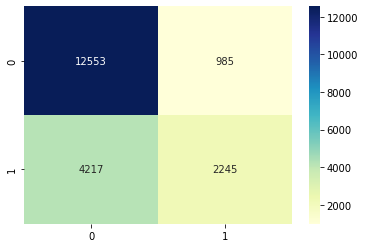

In [ ]:
# min-max
rnd_clf.fit(X_train, y_train)
y_pred_stack = rnd_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7549
정밀도: 0.6682
재현율: 0.4791
AUC: 0.6828
F1: 0.5581


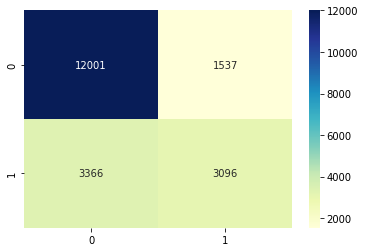

In [ ]:
# min-max
lgbm_clf.fit(X_train, y_train)
y_pred_stack = lgbm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7419
정밀도: 0.6939
재현율: 0.3596
AUC: 0.6420
F1: 0.4738


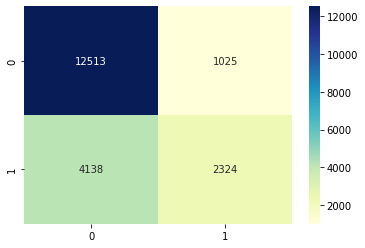

In [ ]:
# min-max
xgb_clf.fit(X_train, y_train)
y_pred_stack = xgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7309
정밀도: 0.6743
재현율: 0.3233
AUC: 0.6244
F1: 0.4370


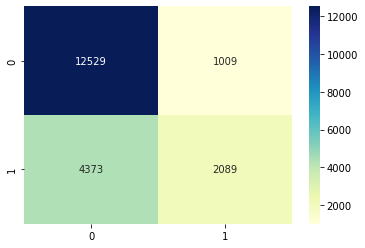

In [ ]:
# min-max
rid_clf.fit(X_train, y_train)
y_pred_stack = rid_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.6668
정밀도: 0.4850
재현율: 0.5070
AUC: 0.6250
F1: 0.4958


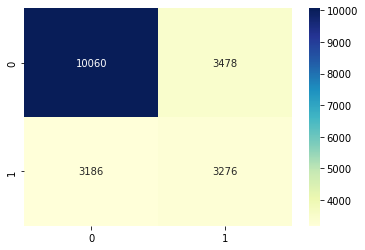

In [ ]:
# min-max
dtc_clf.fit(X_train, y_train)
y_pred_stack = dtc_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7305
정밀도: 0.7049
재현율: 0.2851
AUC: 0.6141
F1: 0.4060


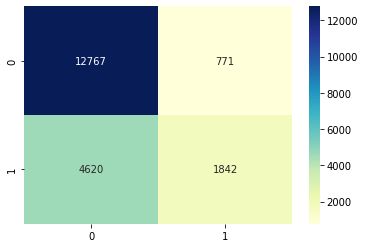

In [ ]:
# min-max
svm_clf.fit(X_train, y_train)
y_pred_stack = svm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7401
정밀도: 0.6773
재현율: 0.3739
AUC: 0.6444
F1: 0.4818


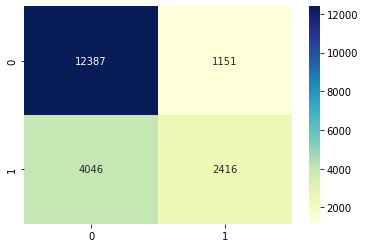

In [ ]:
# min-max
ada_clf.fit(X_train, y_train)
y_pred_stack = ada_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7427
정밀도: 0.6919
재현율: 0.3669
AUC: 0.6445
F1: 0.4795


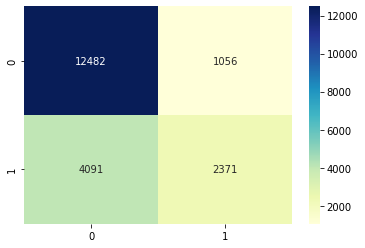

In [ ]:
# min-max
gbc_clf.fit(X_train, y_train)
y_pred_stack = gbc_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7298
정밀도: 0.6192
재현율: 0.4249
AUC: 0.6501
F1: 0.5040


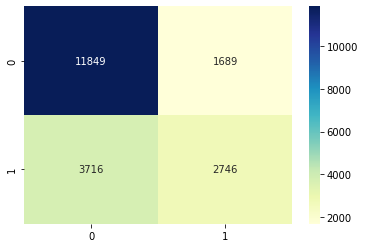

In [ ]:
# min-max
bag_clf.fit(X_train, y_train)
y_pred_stack = bag_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7227
정밀도: 0.6598
재현율: 0.2923
AUC: 0.6102
F1: 0.4051


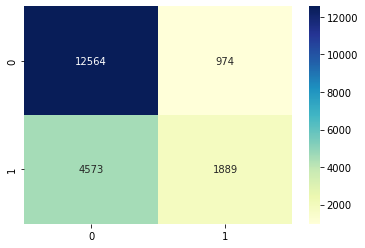

In [ ]:
# min-max
ext_clf.fit(X_train, y_train)
y_pred_stack = ext_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.6519
정밀도: 0.4356
재현율: 0.2686
AUC: 0.5515
F1: 0.3323


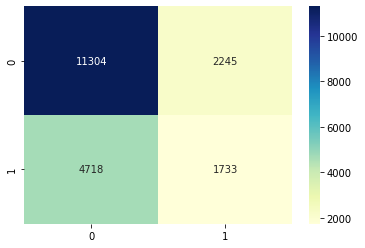

In [ ]:
# min-max
knn_clf.fit(X_train, y_train)
y_pred_stack = knn_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7549
정밀도: 0.6696
재현율: 0.4762
AUC: 0.6820
F1: 0.5566


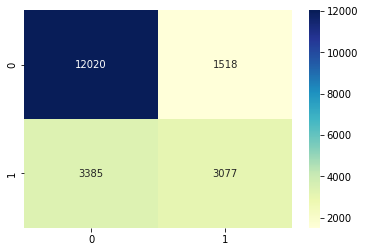

In [ ]:
# min-max
hgb_clf.fit(X_train, y_train)
y_pred_stack = hgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7340
정밀도: 0.6689
재현율: 0.3502
AUC: 0.6337
F1: 0.4597


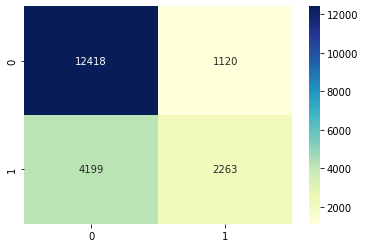

In [ ]:
# min-max
lr_clf.fit(X_train, y_train)
y_pred_stack = lr_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7359
정밀도: 0.6875
재현율: 0.3435
AUC: 0.6342
F1: 0.4581


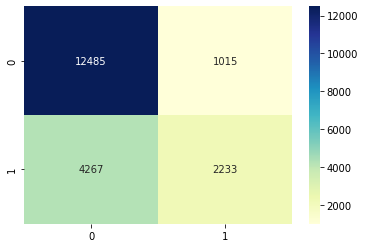

In [ ]:
# z
rnd_clf.fit(X_train, y_train)
y_pred_stack = rnd_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7527
정밀도: 0.6632
재현율: 0.4855
AUC: 0.6834
F1: 0.5606


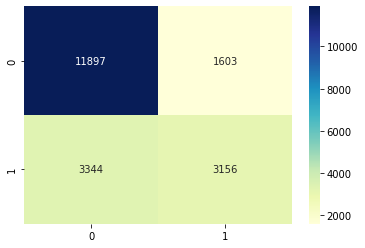

In [ ]:
# z
lgbm_clf.fit(X_train, y_train)
y_pred_stack = lgbm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7379
정밀도: 0.6818
재현율: 0.3632
AUC: 0.6408
F1: 0.4740


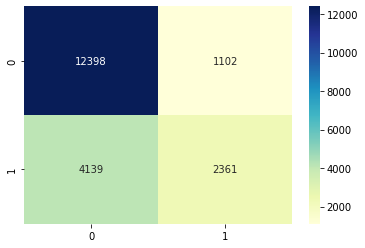

In [ ]:
# z
xgb_clf.fit(X_train, y_train)
y_pred_stack = xgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7268
정밀도: 0.6561
재현율: 0.3346
AUC: 0.6251
F1: 0.4432


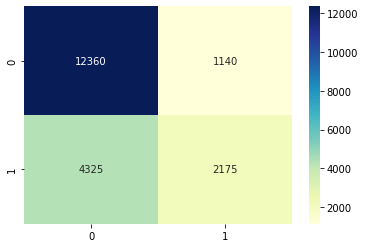

In [ ]:
# z
rid_clf.fit(X_train, y_train)
y_pred_stack = rid_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.6725
정밀도: 0.4963
재현율: 0.5143
AUC: 0.6315
F1: 0.5051


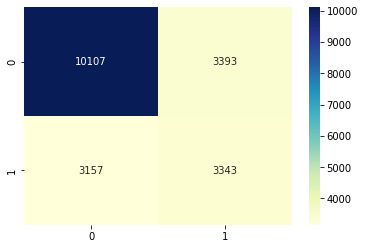

In [ ]:
# z
dtc_clf.fit(X_train, y_train)
y_pred_stack = dtc_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7359
정밀도: 0.6833
재현율: 0.3489
AUC: 0.6355
F1: 0.4620


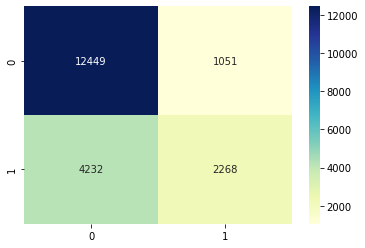

In [ ]:
# z
svm_clf.fit(X_train, y_train)
y_pred_stack = svm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7339
정밀도: 0.6634
재현율: 0.3682
AUC: 0.6391
F1: 0.4735


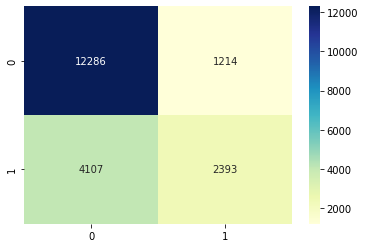

In [ ]:
# z
ada_clf.fit(X_train, y_train)
y_pred_stack = ada_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7376
정밀도: 0.6790
재현율: 0.3651
AUC: 0.6410
F1: 0.4748


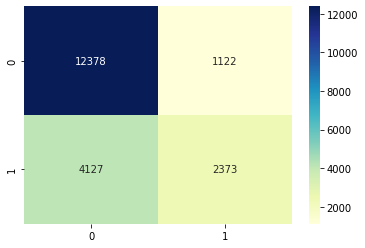

In [ ]:
# z
gbc_clf.fit(X_train, y_train)
y_pred_stack = gbc_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7266
정밀도: 0.6157
재현율: 0.4220
AUC: 0.6476
F1: 0.5008


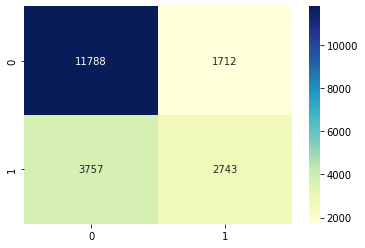

In [ ]:
# z
bag_clf.fit(X_train, y_train)
y_pred_stack = bag_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7160
정밀도: 0.6399
재현율: 0.2889
AUC: 0.6053
F1: 0.3981


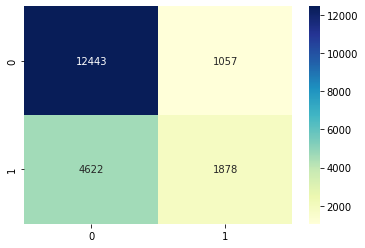

In [ ]:
# z
ext_clf.fit(X_train, y_train)
y_pred_stack = ext_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.6601
정밀도: 0.4625
재현율: 0.2834
AUC: 0.5624
F1: 0.3514


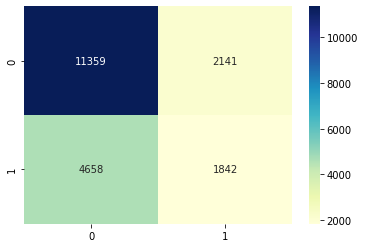

In [ ]:
# z
knn_clf.fit(X_train, y_train)
y_pred_stack = knn_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7529
정밀도: 0.6625
재현율: 0.4883
AUC: 0.6843
F1: 0.5622


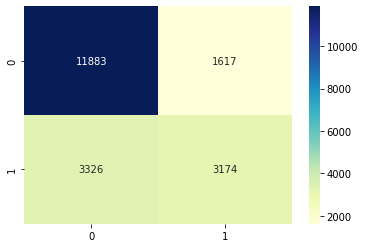

In [ ]:
# z
hgb_clf.fit(X_train, y_train)
y_pred_stack = hgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7285
정밀도: 0.6484
재현율: 0.3597
AUC: 0.6329
F1: 0.4627


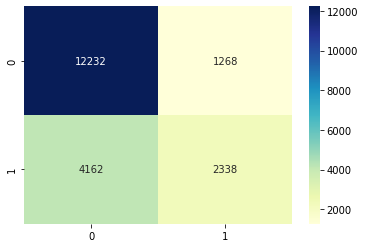

In [ ]:
# z
lr_clf.fit(X_train, y_train)
y_pred_stack = lr_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)

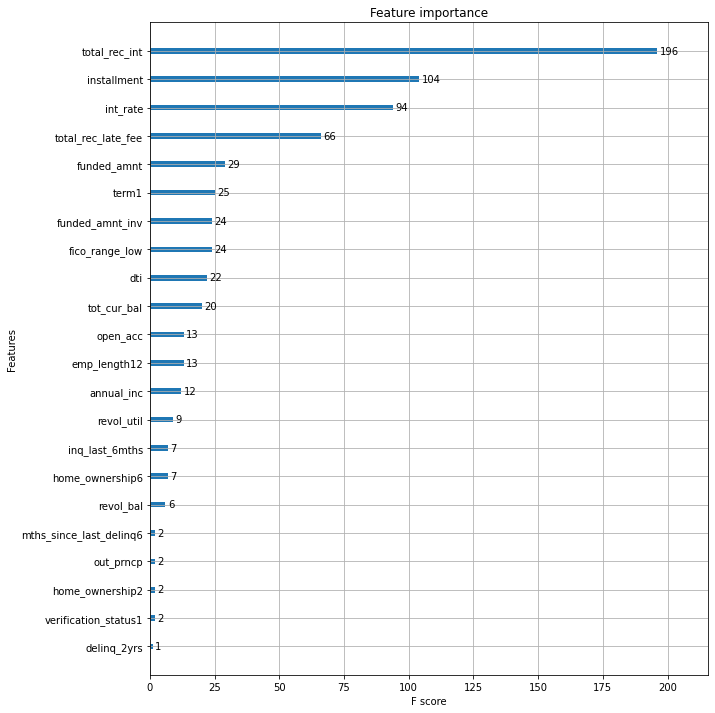

In [ ]:
# Raw 데이터 기준
from xgboost import plot_importance

xgb_clf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)

< importance 20 이상의 feature >

total_rec_int, installment, int_rate, total_rec_late_fee, funded_amnt, term1, funded_amnt_inv, fico_range_low, dti, tot_cur_bal

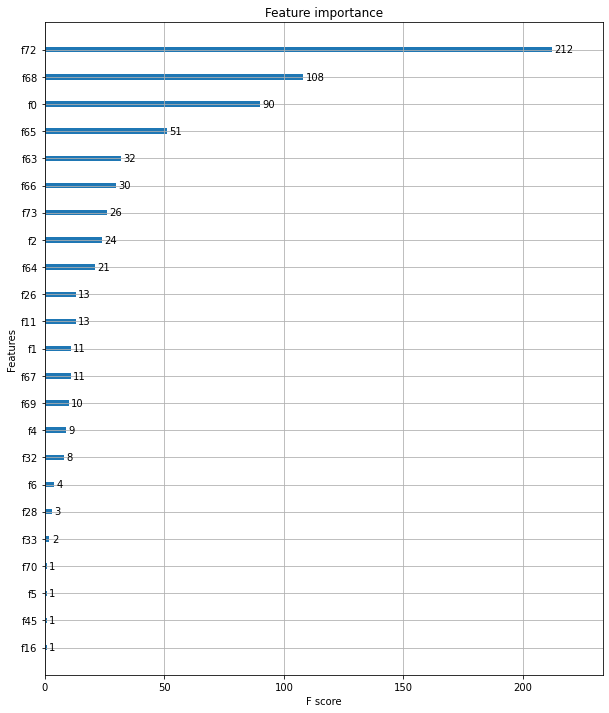

In [ ]:
# Data binning + min-max 데이터 기준
from xgboost import plot_importance

xgb_clf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)

In [ ]:
# 하이퍼 파라미터 튜닝
xgb_clf = xgboost.XGBClassifier()

param_test1 = {
    'max_depth':range(3,10,3),
    # 'min_child_weight':range(1,6,2)
    }

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5, 
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=-1, 
                                                  scale_pos_weight=1, seed=2019),
                        param_grid = param_test1, scoring='f1',n_jobs=-1, cv=5, verbose=10)

xgb_results1 = gsearch1.fit(X_train, y_train)

xgb_results1.cv_results_, xgb_results1.best_params_, xgb_results1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


({'mean_fit_time': array([170.26976762, 324.58525863, 485.52571654]),
  'mean_score_time': array([0.67758741, 1.59392266, 2.97353854]),
  'mean_test_score': array([0.56122135, 0.56750721, 0.55921463]),
  'param_max_depth': masked_array(data=[3, 6, 9],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 3}, {'max_depth': 6}, {'max_depth': 9}],
  'rank_test_score': array([2, 1, 3], dtype=int32),
  'split0_test_score': array([0.56139571, 0.56590737, 0.56497418]),
  'split1_test_score': array([0.56176504, 0.56763181, 0.55957654]),
  'split2_test_score': array([0.56644206, 0.57788347, 0.56526453]),
  'split3_test_score': array([0.55561754, 0.56318236, 0.55357531]),
  'split4_test_score': array([0.56088643, 0.56293103, 0.55268261]),
  'std_fit_time': array([ 1.0481201 ,  1.8413533 , 57.24440126]),
  'std_score_time': array([0.02424582, 0.02633323, 0.32354979]),
  'std_test_score': array([0.00343793, 0.00547517, 0.0053735

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=6, 
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=-1, 
                                                  scale_pos_weight=1, seed=2019),
                        param_grid = param_test2, scoring='accuracy',n_jobs=-1, cv=5, verbose=10)

xgb_results2 = gsearch2.fit(X_train, y_train)

xgb_results2.cv_results_, xgb_results2.best_params_, xgb_results2.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'mean_fit_time': array([331.46064038, 332.67606277, 329.25648313, 339.67537789,
         306.4204308 ]),
  'mean_score_time': array([1.61475916, 1.60471172, 1.59508348, 1.63728123, 1.52419724]),
  'mean_test_score': array([0.7496875, 0.748775 , 0.748875 , 0.7507   , 0.7504   ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 5, 4, 1, 2], dtype=int32),
  'split0_test_score': array([0.7486875, 0.7501875, 0.747875 , 0.7495625, 0.7495625]),
  'split1_test_score': array([0.749875 , 0.7495   , 0.7514375, 0.7499375, 0.7496875]),
  'split2_test_score': array([0.7559375, 0.748875 , 0.752875 , 0.75475  , 0.7544375]),
  'split3_test_score': array([0.7474375, 0.748875 , 0.7450625, 0.750875 , 0.7500625]),
  'split4_test_score': array([0.7

In [ ]:
xgb_clf = xgboost.XGBClassifier(learning_rate = 0.01,
                                n_estimators = 350,
                                max_depth = 9,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree = 0.8,
                                objective="binary:logistic",
                                nthread= -1,
                                scale_pos_weight = 1,
                                seed=220205,
                                # tree_method='gpu_hist',
                                # predictor='gpu_predictor'
                                )

xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=9,
              n_estimators=350, nthread=-1, seed=220205, subsample=0.8)

[[0.65101314 0.3489869 ]
 [0.86693835 0.13306162]
 [0.8302572  0.16974284]
 ...
 [0.5344924  0.46550766]
 [0.82314605 0.17685395]
 [0.8024571  0.19754292]]

정확도: 0.7381
정밀도: 0.5905
재현율: 0.6404
AUC: 0.7129
F1: 0.6144


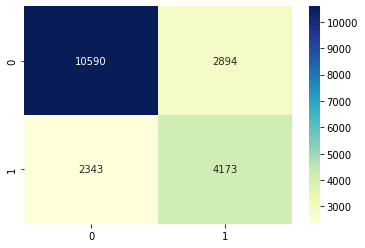

In [ ]:
y_pred_stack = xgb_clf.predict_proba(X_valid)
print(y_pred_stack)

get_clf_eval(y_valid, y_pred_stack[:,1]>0.38)

# 4. 모델 학습

In [ ]:
# hgb_clf, lgbm_clf, bag_clf, dtc_clf

lgbm_clf = LGBMClassifier(random_state=42)  # 0.5594 - 4초
xgb_clf = XGBClassifier(random_state=42)  # 0.4732 - 16초
cbt_clf = CatBoostClassifier()  # 0.5634 - 29초
# dtc_clf = DecisionTreeClassifier(random_state=42)  # 0.4963 - 4초
bag_clf = BaggingClassifier(random_state=42)  # 0.5018 - 17초
hgb_clf = HistGradientBoostingClassifier(random_state=42)  # 0.5532 - 10초


정확도: 0.7531
정밀도: 0.6592
재현율: 0.4858
AUC: 0.6831
F1: 0.5594


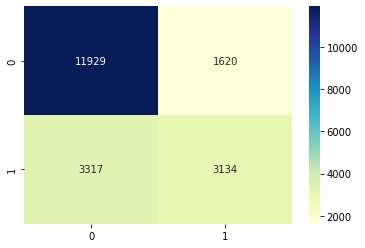

In [ ]:
lgbm_clf.fit(X_train, y_train)
y_pred_stack = lgbm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7382
정밀도: 0.6741
재현율: 0.3646
AUC: 0.6403
F1: 0.4732


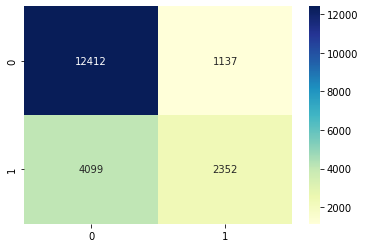

In [ ]:
xgb_clf.fit(X_train, y_train)
y_pred_stack = xgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)

Learning rate set to 0.06692
0:	learn: 0.6754339	total: 77ms	remaining: 1m 16s
1:	learn: 0.6602936	total: 110ms	remaining: 55.1s
2:	learn: 0.6461948	total: 137ms	remaining: 45.5s
3:	learn: 0.6357672	total: 163ms	remaining: 40.7s
4:	learn: 0.6257794	total: 194ms	remaining: 38.7s
5:	learn: 0.6171637	total: 221ms	remaining: 36.7s
6:	learn: 0.6096640	total: 247ms	remaining: 35s
7:	learn: 0.6030464	total: 281ms	remaining: 34.8s
8:	learn: 0.5973362	total: 315ms	remaining: 34.7s
9:	learn: 0.5921589	total: 342ms	remaining: 33.8s
10:	learn: 0.5880092	total: 368ms	remaining: 33.1s
11:	learn: 0.5836214	total: 402ms	remaining: 33.1s
12:	learn: 0.5795925	total: 431ms	remaining: 32.7s
13:	learn: 0.5760729	total: 459ms	remaining: 32.3s
14:	learn: 0.5728207	total: 487ms	remaining: 32s
15:	learn: 0.5701688	total: 513ms	remaining: 31.5s
16:	learn: 0.5678296	total: 541ms	remaining: 31.3s
17:	learn: 0.5653757	total: 574ms	remaining: 31.3s
18:	learn: 0.5633737	total: 600ms	remaining: 31s
19:	learn: 0.56122

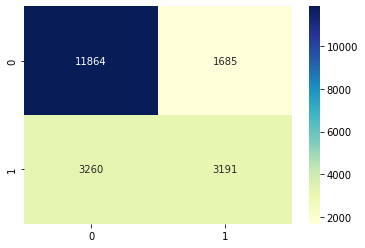

In [ ]:
cbt_clf.fit(X_train, y_train)
y_pred_stack = cbt_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7301
정밀도: 0.6203
재현율: 0.4213
AUC: 0.6493
F1: 0.5018


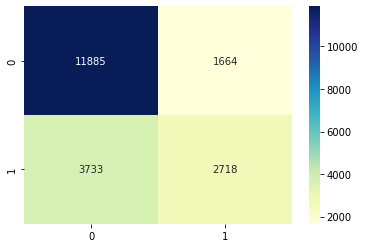

In [ ]:
bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_stack = bag_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7501
정밀도: 0.6537
재현율: 0.4793
AUC: 0.6792
F1: 0.5531


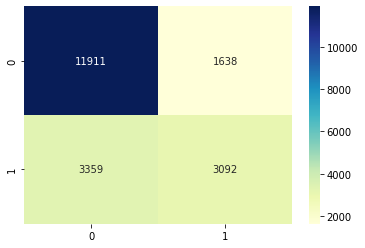

In [ ]:
hgb_clf.fit(X_train, y_train)
y_pred_stack = hgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7510
정밀도: 0.6546
재현율: 0.4827
AUC: 0.6807
F1: 0.5557


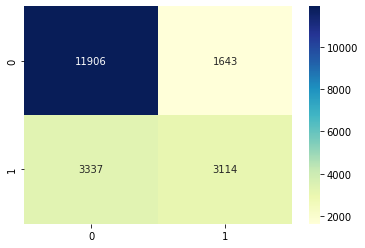

In [ ]:
# z
lgbm_clf.fit(X_train, y_train)
y_pred_stack = lgbm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7382
정밀도: 0.6741
재현율: 0.3646
AUC: 0.6403
F1: 0.4732


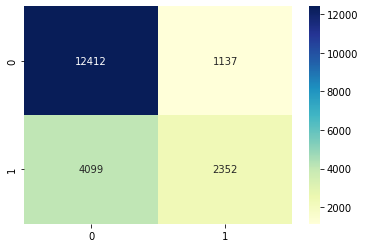

In [ ]:
# z
xgb_clf.fit(X_train, y_train)
y_pred_stack = xgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)

Learning rate set to 0.06692
0:	learn: 0.6754448	total: 26.2ms	remaining: 26.1s
1:	learn: 0.6602745	total: 53.7ms	remaining: 26.8s
2:	learn: 0.6461418	total: 80ms	remaining: 26.6s
3:	learn: 0.6357018	total: 106ms	remaining: 26.4s
4:	learn: 0.6257134	total: 133ms	remaining: 26.5s
5:	learn: 0.6171081	total: 160ms	remaining: 26.5s
6:	learn: 0.6096071	total: 189ms	remaining: 26.8s
7:	learn: 0.6029989	total: 215ms	remaining: 26.7s
8:	learn: 0.5972961	total: 240ms	remaining: 26.5s
9:	learn: 0.5921115	total: 266ms	remaining: 26.3s
10:	learn: 0.5879706	total: 291ms	remaining: 26.2s
11:	learn: 0.5835818	total: 321ms	remaining: 26.5s
12:	learn: 0.5795591	total: 347ms	remaining: 26.4s
13:	learn: 0.5760423	total: 374ms	remaining: 26.3s
14:	learn: 0.5727948	total: 408ms	remaining: 26.8s
15:	learn: 0.5701731	total: 435ms	remaining: 26.8s
16:	learn: 0.5679775	total: 462ms	remaining: 26.7s
17:	learn: 0.5656956	total: 487ms	remaining: 26.6s
18:	learn: 0.5636344	total: 513ms	remaining: 26.5s
19:	learn: 

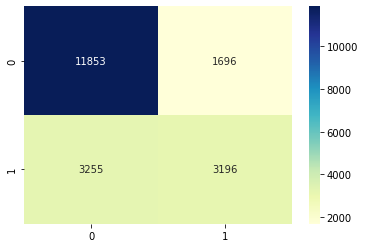

In [ ]:
# z
cbt_clf.fit(X_train, y_train)
y_pred_stack = cbt_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7299
정밀도: 0.6200
재현율: 0.4206
AUC: 0.6489
F1: 0.5012


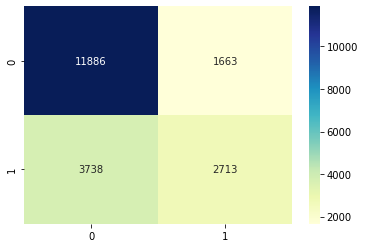

In [ ]:
# z
bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_stack = bag_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7501
정밀도: 0.6537
재현율: 0.4793
AUC: 0.6792
F1: 0.5531


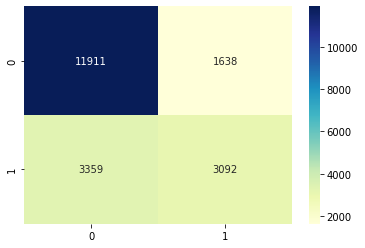

In [ ]:
# z
hgb_clf.fit(X_train, y_train)
y_pred_stack = hgb_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)

## 4.1 베이지안 최적화를 통한 하이퍼파라미터 탐색

In [42]:
def sum_acc_and_f1(y_real, y_pred):
    return accuracy_score(y_real, y_pred) + f1_score(y_real, y_pred)

In [43]:
rnd_clf = RandomForestClassifier()  # 0.4613 - 28초
lgbm_clf = LGBMClassifier()  # 0.5568 - 4초
xgb_clf = XGBClassifier()  # 0.4651 - 16초
rid_clf = RidgeClassifier()  # 0.4036 - 1초
dtc_clf = DecisionTreeClassifier()  # 0.4963 - 4초
svm_clf = SVC()  # 0.0000 / 정확도: 0.6779 - 28분
ada_clf = AdaBoostClassifier()  # 0.4749 - 10초
gbc_clf = GradientBoostingClassifier()  # 0.4749 / 정확도는 ada보다 조금 높음. - 41초
bag_clf = BaggingClassifier()  # 0.5088 - 17초
ext_clf = ExtraTreesClassifier()  # 0.3792 - 26초
knn_clf = KNeighborsClassifier()  # 0.2926 - 38초
hgb_clf = HistGradientBoostingClassifier()  # 0.5575 - 10초
lr_clf = LogisticRegression()
cb_clf = CatBoostClassifier()

In [ ]:
models = [rnd_clf, lgbm_clf, xgb_clf, rid_clf, dtc_clf, svm_clf, ada_clf, gbc_clf, bag_clf, ext_clf, knn_clf, hgb_clf, lr_clf, cb_clf]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = sum_acc_and_f1(y_valid, y_pred)
    print(model, '합산 점수: {:.4f}'.format(score))

RandomForestClassifier() 합산 점수: 1.2126
LGBMClassifier() 합산 점수: 1.3098
XGBClassifier() 합산 점수: 1.2112
RidgeClassifier() 합산 점수: 1.1598
DecisionTreeClassifier() 합산 점수: 1.1573
SVC() 합산 점수: 0.6774
AdaBoostClassifier() 합산 점수: 1.2021
GradientBoostingClassifier() 합산 점수: 1.2186
BaggingClassifier() 합산 점수: 1.2333
ExtraTreesClassifier() 합산 점수: 1.1562
KNeighborsClassifier() 합산 점수: 0.9951
HistGradientBoostingClassifier() 합산 점수: 1.3024
LogisticRegression() 합산 점수: 0.9063
Learning rate set to 0.06692
0:	learn: 0.6766162	total: 72.1ms	remaining: 1m 12s
1:	learn: 0.6608876	total: 94.7ms	remaining: 47.2s
2:	learn: 0.6486850	total: 116ms	remaining: 38.6s
3:	learn: 0.6370316	total: 138ms	remaining: 34.3s
4:	learn: 0.6260754	total: 160ms	remaining: 31.8s
5:	learn: 0.6176209	total: 181ms	remaining: 29.9s
6:	learn: 0.6092330	total: 215ms	remaining: 30.4s
7:	learn: 0.6026501	total: 239ms	remaining: 29.6s
8:	learn: 0.5967099	total: 268ms	remaining: 29.5s
9:	learn: 0.5920812	total: 291ms	remaining: 28.8s
10:	learn

RandomForestClassifier() 합산 점수: 1.2126

LGBMClassifier() 합산 점수: 1.3098

XGBClassifier() 합산 점수: 1.2112

RidgeClassifier() 합산 점수: 1.1598

DecisionTreeClassifier() 합산 점수: 1.1573

SVC() 합산 점수: 0.6774

AdaBoostClassifier() 합산 점수: 1.2021

GradientBoostingClassifier() 합산 점수: 1.2186

BaggingClassifier() 합산 점수: 1.2333

ExtraTreesClassifier() 합산 점수: 1.1562

KNeighborsClassifier() 합산 점수: 0.9951

HistGradientBoostingClassifier() 합산 점수: 1.3024

LogisticRegression() 합산 점수: 0.9063

catboost.core.CatBoostClassifier() 합산 점수: 1.3185

### 4.1.1 CatBoost

In [44]:
cb_clf = CatBoostClassifier()

In [ ]:
def objective_cb(trial: Trial) -> float:
    param = {
        "random_state":42,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        }

    X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

    cat_features = X_train.columns[X_train.dtypes == 'object'].to_list()  #[0,1,2,5,6,7,8,15,18]
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid,y_valid)],
            early_stopping_rounds=35, cat_features=cat_features,
            verbose=100)
    cat_pred = cat.predict_proba(X_valid)
    log_score = log_loss(y_valid, cat_pred)

    return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective_cb, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-02-07 13:56:22,667] A new study created in memory with name: cat_parameter_opt
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6882514	test: 0.6882720	test1: 0.6884505	best: 0.6884505 (0)	total: 213ms	remaining: 26m 54s
100:	learn: 0.5356396	test: 0.5356648	test1: 0.5547499	best: 0.5547499 (100)	total: 14.4s	remaining: 17m 47s
200:	learn: 0.5088306	test: 0.5088599	test1: 0.5418253	best: 0.5418253 (200)	total: 24.8s	remaining: 15m 12s
300:	learn: 0.4902904	test: 0.4903208	test1: 0.5333121	best: 0.5333121 (300)	total: 35.1s	remaining: 14m 9s
400:	learn: 0.4519124	test: 0.4519460	test1: 0.5200117	best: 0.5200117 (400)	total: 46s	remaining: 13m 44s
500:	learn: 0.3969149	test: 0.3969528	test1: 0.5094329	best: 0.5089865 (489)	total: 57.2s	remaining: 13m 29s


[I 2022-02-07 13:57:27,154] Trial 0 finished with value: 0.5088427354632142 and parameters: {'learning_rate': 0.03574712922600244, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.5088427354632142.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.5088427355
bestIteration = 521

Shrink model to first 522 iterations.
0:	learn: 0.6491181	test: 0.6491964	test1: 0.6509084	best: 0.6509084 (0)	total: 27.4ms	remaining: 1m 19s
100:	learn: 0.4858290	test: 0.4858658	test1: 0.5169939	best: 0.5169939 (100)	total: 2.87s	remaining: 1m 19s


[I 2022-02-07 13:57:31,440] Trial 1 finished with value: 0.5169938722887197 and parameters: {'learning_rate': 0.2708160864249968, 'bagging_temperature': 21.368329072358772, 'n_estimators': 2911, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.5088427354632142.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.5169938723
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.6859598	test: 0.6859713	test1: 0.6866365	best: 0.6866365 (0)	total: 1.26s	remaining: 1h 47m 14s
100:	learn: 0.5254981	test: 0.5255224	test1: 0.5595021	best: 0.5595021 (100)	total: 1m 38s	remaining: 1h 20m 56s
200:	learn: 0.4807234	test: 0.4807521	test1: 0.5450807	best: 0.5450807 (200)	total: 3m 16s	remaining: 1h 19m 53s
300:	learn: 0.4533117	test: 0.4533423	test1: 0.5399486	best: 0.5399390 (299)	total: 4m 52s	remaining: 1h 17m 50s
400:	learn: 0.4305497	test: 0.4305814	test1: 0.5377651	best: 0.5376318 (393)	total: 6m 25s	remaining: 1h 15m 17s
500:	learn: 0.3795741	test: 0.3796092	test1: 0.5341228	best: 0.5341193 (499)	total: 8m 9s	remaining: 1h 14m 59s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.5341193329
bestIteration = 499

Shrink model to first 500 iterations.


[I 2022-02-07 14:06:21,694] Trial 2 finished with value: 0.5341193328901592 and parameters: {'learning_rate': 0.027010527749605478, 'bagging_temperature': 0.2920433847181412, 'n_estimators': 5105, 'max_depth': 14, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.5088427354632142.


0:	learn: 0.6393346	test: 0.6394050	test1: 0.6395685	best: 0.6395685 (0)	total: 34.6ms	remaining: 4m 46s
100:	learn: 0.4731043	test: 0.4731426	test1: 0.5070199	best: 0.5070199 (100)	total: 3.73s	remaining: 5m 2s


[I 2022-02-07 14:06:27,196] Trial 3 finished with value: 0.5070198795296337 and parameters: {'learning_rate': 0.2521267904777921, 'bagging_temperature': 72.86653737491046, 'n_estimators': 8276, 'max_depth': 7, 'random_strength': 9, 'colsample_bylevel': 0.8105398159072941, 'l2_leaf_reg': 1.3210173287250643e-05, 'min_child_samples': 16, 'max_bin': 349, 'od_type': 'Iter'}. Best is trial 3 with value: 0.5070198795296337.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.5070198795
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.6893469	test: 0.6893427	test1: 0.6893848	best: 0.6893848 (0)	total: 79.6ms	remaining: 5m 2s
100:	learn: 0.5729833	test: 0.5730021	test1: 0.5776773	best: 0.5776773 (100)	total: 8.48s	remaining: 5m 11s
200:	learn: 0.5554837	test: 0.5555067	test1: 0.5647501	best: 0.5647501 (200)	total: 16.2s	remaining: 4m 50s
300:	learn: 0.5382899	test: 0.5383174	test1: 0.5547233	best: 0.5547233 (300)	total: 24.1s	remaining: 4m 40s
400:	learn: 0.5276679	test: 0.5276970	test1: 0.5494365	best: 0.5494078 (398)	total: 31.9s	remaining: 4m 30s
500:	learn: 0.5172735	test: 0.5173032	test1: 0.5444062	best: 0.5444062 (500)	total: 40s	remaining: 4m 23s
600:	learn: 0.4977661	test: 0.4977967	test1: 0.5322706	best: 0.5322706 (600)	total: 48.3s	remaining: 4m 17s
700:	learn: 0.4684910	test: 0.4685247	test1: 0.5143732	best: 0.5143732 (700)	total: 56.8s	remaining: 4m 11s
800:

[I 2022-02-07 14:07:49,305] Trial 4 finished with value: 0.5046699549024667 and parameters: {'learning_rate': 0.024112898115291985, 'bagging_temperature': 4.467752817973908, 'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.5046699549024667.


0:	learn: 0.6629103	test: 0.6629468	test1: 0.6634991	best: 0.6634991 (0)	total: 21.2ms	remaining: 58.6s
100:	learn: 0.5119418	test: 0.5119750	test1: 0.5190408	best: 0.5190408 (100)	total: 2.23s	remaining: 58.7s
200:	learn: 0.4903568	test: 0.4903939	test1: 0.5077234	best: 0.5077234 (200)	total: 4.46s	remaining: 56.9s
300:	learn: 0.4770364	test: 0.4770759	test1: 0.5038001	best: 0.5037535 (298)	total: 6.72s	remaining: 55s


[I 2022-02-07 14:07:57,357] Trial 5 finished with value: 0.5036526775478923 and parameters: {'learning_rate': 0.22999586428143728, 'bagging_temperature': 0.022592797420156956, 'n_estimators': 2764, 'max_depth': 4, 'random_strength': 32, 'colsample_bylevel': 0.6332063738136893, 'l2_leaf_reg': 8.147757462899138e-06, 'min_child_samples': 84, 'max_bin': 307, 'od_type': 'Iter'}. Best is trial 5 with value: 0.5036526775478923.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.5036526775
bestIteration = 305

Shrink model to first 306 iterations.
0:	learn: 0.6900580	test: 0.6900543	test1: 0.6905731	best: 0.6905731 (0)	total: 4.83s	remaining: 2h 14m 35s
100:	learn: 0.5614039	test: 0.5614253	test1: 0.5896814	best: 0.5896814 (100)	total: 5m 18s	remaining: 1h 22m 37s
200:	learn: 0.5159768	test: 0.5160008	test1: 0.5709879	best: 0.5709879 (200)	total: 9m 54s	remaining: 1h 12m 24s
300:	learn: 0.4871931	test: 0.4872200	test1: 0.5634070	best: 0.5634070 (300)	total: 14m 46s	remaining: 1h 7m 16s
400:	learn: 0.4624443	test: 0.4624733	test1: 0.5593604	best: 0.5593604 (400)	total: 19m 54s	remaining: 1h 3m 2s
500:	learn: 0.4450401	test: 0.4450703	test1: 0.5569475	best: 0.5569475 (500)	total: 24m 30s	remaining: 57m 14s
600:	learn: 0.4228897	test: 0.4229204	test1: 0.5554821	best: 0.5554821 (600)	total: 29m 43s	remaining: 52m 55s
700:	learn: 0.4093859	test: 0.4094175	test1: 0.5545443	best: 0.5545443 (700)	tota

In [45]:
def objective_cb(trial: Trial) -> float:
    param = {
        "random_state":42,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y[train_idx], y[test_idx]

        cat_features = X_train.columns[X_train.dtypes == 'object'].to_list()

        model = CatBoostClassifier(**param)
        model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=30, cat_features=cat_features,
            verbose=100)
        preds = model.predict_proba(X_valid)
        cv_scores[idx] = log_loss(y_valid, preds)

    return np.mean(cv_scores)

In [46]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective_cb, n_trials=5)

[I 2022-02-07 23:55:46,622] A new study created in memory with name: cat_parameter_opt


0:	learn: 0.6882518	test: 0.6882850	test1: 0.6883899	best: 0.6883899 (0)	total: 198ms	remaining: 25m
100:	learn: 0.5370480	test: 0.5370733	test1: 0.5580302	best: 0.5580302 (100)	total: 11.1s	remaining: 13m 43s
200:	learn: 0.5093000	test: 0.5093303	test1: 0.5453057	best: 0.5453057 (200)	total: 22.4s	remaining: 13m 41s
300:	learn: 0.4872302	test: 0.4872610	test1: 0.5386241	best: 0.5386241 (300)	total: 33.8s	remaining: 13m 38s
400:	learn: 0.4485799	test: 0.4486133	test1: 0.5274006	best: 0.5274006 (400)	total: 46s	remaining: 13m 43s
500:	learn: 0.3944359	test: 0.3944743	test1: 0.5167555	best: 0.5164990 (497)	total: 58.3s	remaining: 13m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5161258181
bestIteration = 513

Shrink model to first 514 iterations.
0:	learn: 0.6883042	test: 0.6882906	test1: 0.6884459	best: 0.6884459 (0)	total: 120ms	remaining: 15m 10s
100:	learn: 0.5374888	test: 0.5375143	test1: 0.5589917	best: 0.5589177 (99)	total: 12.7s	remaining: 15m 41s
200:	

[I 2022-02-08 00:01:10,063] Trial 0 finished with value: 0.5165185990623187 and parameters: {'learning_rate': 0.03574712922600244, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.5165185990623187.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5121895206
bestIteration = 511

Shrink model to first 512 iterations.
0:	learn: 0.6498266	test: 0.6498625	test1: 0.6494377	best: 0.6494377 (0)	total: 26.5ms	remaining: 1m 17s
100:	learn: 0.4874441	test: 0.4874816	test1: 0.5118703	best: 0.5118250 (95)	total: 2.93s	remaining: 1m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5107341221
bestIteration = 126

Shrink model to first 127 iterations.
0:	learn: 0.6492217	test: 0.6492548	test1: 0.6503837	best: 0.6503837 (0)	total: 27.5ms	remaining: 1m 20s
100:	learn: 0.4865389	test: 0.4865764	test1: 0.5099414	best: 0.5098862 (97)	total: 3s	remaining: 1m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5089388461
bestIteration = 110

Shrink model to first 111 iterations.
0:	learn: 0.6498380	test: 0.6499203	test1: 0.6493949	best: 0.6493949 (0)	total: 27.7ms	remaining: 1m 20s
100:	learn: 0.4871551	test: 0.4871928	test1: 0.5076134	best:

[I 2022-02-08 00:01:34,908] Trial 1 finished with value: 0.5082993090658487 and parameters: {'learning_rate': 0.2708160864249968, 'bagging_temperature': 21.368329072358772, 'n_estimators': 2911, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5082993090658487.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5035105139
bestIteration = 122

Shrink model to first 123 iterations.
0:	learn: 0.6858852	test: 0.6858959	test1: 0.6865872	best: 0.6865872 (0)	total: 1.38s	remaining: 1h 57m 15s
100:	learn: 0.5214509	test: 0.5214753	test1: 0.5630789	best: 0.5630789 (100)	total: 1m 38s	remaining: 1h 21m 40s
200:	learn: 0.4817582	test: 0.4817879	test1: 0.5492952	best: 0.5492952 (200)	total: 3m 10s	remaining: 1h 17m 34s
300:	learn: 0.4533240	test: 0.4533554	test1: 0.5428465	best: 0.5428084 (299)	total: 4m 57s	remaining: 1h 19m 14s
400:	learn: 0.4284576	test: 0.4284897	test1: 0.5395025	best: 0.5395025 (400)	total: 6m 37s	remaining: 1h 17m 47s
500:	learn: 0.3789971	test: 0.3790315	test1: 0.5363807	best: 0.5357831 (495)	total: 8m 20s	remaining: 1h 16m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5357830592
bestIteration = 495

Shrink model to first 496 iterations.
0:	learn: 0.6860144	test: 0.6860297	test1: 0.686631

[I 2022-02-08 00:47:51,674] Trial 2 finished with value: 0.5373029168046461 and parameters: {'learning_rate': 0.027010527749605478, 'bagging_temperature': 0.2920433847181412, 'n_estimators': 5105, 'max_depth': 14, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5082993090658487.


0:	learn: 0.6390178	test: 0.6390681	test1: 0.6393192	best: 0.6393192 (0)	total: 35.1ms	remaining: 4m 50s
100:	learn: 0.4728847	test: 0.4729237	test1: 0.5097115	best: 0.5087348 (86)	total: 3.91s	remaining: 5m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5087347596
bestIteration = 86

Shrink model to first 87 iterations.
0:	learn: 0.6388104	test: 0.6388712	test1: 0.6405364	best: 0.6405364 (0)	total: 36.2ms	remaining: 4m 59s
100:	learn: 0.4726711	test: 0.4727097	test1: 0.5155057	best: 0.5124556 (90)	total: 3.89s	remaining: 5m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5124555755
bestIteration = 90

Shrink model to first 91 iterations.
0:	learn: 0.6391736	test: 0.6392119	test1: 0.6393192	best: 0.6393192 (0)	total: 36ms	remaining: 4m 58s
100:	learn: 0.4727061	test: 0.4727438	test1: 0.5125503	best: 0.5113957 (97)	total: 3.93s	remaining: 5m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5113957386
bestIteration =

[I 2022-02-08 00:48:17,057] Trial 3 finished with value: 0.5111984336976239 and parameters: {'learning_rate': 0.2521267904777921, 'bagging_temperature': 72.86653737491046, 'n_estimators': 8276, 'max_depth': 7, 'random_strength': 9, 'colsample_bylevel': 0.8105398159072941, 'l2_leaf_reg': 1.3210173287250643e-05, 'min_child_samples': 16, 'max_bin': 349, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5082993090658487.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5083903087
bestIteration = 87

Shrink model to first 88 iterations.
0:	learn: 0.6892492	test: 0.6892801	test1: 0.6894190	best: 0.6894190 (0)	total: 79.3ms	remaining: 5m 1s
100:	learn: 0.5730779	test: 0.5730936	test1: 0.5819723	best: 0.5819723 (100)	total: 8.37s	remaining: 5m 6s
200:	learn: 0.5496222	test: 0.5496447	test1: 0.5649761	best: 0.5649761 (200)	total: 16.6s	remaining: 4m 56s
300:	learn: 0.5361116	test: 0.5361379	test1: 0.5575296	best: 0.5575296 (300)	total: 24.9s	remaining: 4m 50s
400:	learn: 0.5257260	test: 0.5257538	test1: 0.5527703	best: 0.5527703 (400)	total: 33.4s	remaining: 4m 43s
500:	learn: 0.5164966	test: 0.5165257	test1: 0.5482647	best: 0.5482647 (500)	total: 41.3s	remaining: 4m 32s
600:	learn: 0.4953244	test: 0.4953548	test1: 0.5349045	best: 0.5349045 (600)	total: 50s	remaining: 4m 26s
700:	learn: 0.4666404	test: 0.4666742	test1: 0.5180808	best: 0.5180808 (700)	total: 59s	remaining: 4m 21s
800:	lear

[I 2022-02-08 00:55:09,293] Trial 4 finished with value: 0.5059310352284125 and parameters: {'learning_rate': 0.024112898115291985, 'bagging_temperature': 4.467752817973908, 'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.5059310352284125.


In [47]:
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

Best Score: 0.5059310352284125
Best trial {'learning_rate': 0.024112898115291985, 'bagging_temperature': 4.467752817973908, 'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'}


In [92]:
cb_best_params = {'learning_rate': 0.024112898115291985, 
                  'bagging_temperature': 4.467752817973908, 
                  'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 
                  'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 
                  'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'
                  }

In [95]:
cb_clf = CatBoostClassifier(**cb_best_params)
cb_clf.fit(X_train, y_train)
y_pred_stack = cb_clf.predict(X_valid)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6887230	total: 76.3ms	remaining: 4m 50s
1:	learn: 0.6843479	total: 158ms	remaining: 4m 59s
2:	learn: 0.6808811	total: 240ms	remaining: 5m 4s
3:	learn: 0.6776961	total: 328ms	remaining: 5m 11s
4:	learn: 0.6746381	total: 415ms	remaining: 5m 15s
5:	learn: 0.6717687	total: 514ms	remaining: 5m 25s
6:	learn: 0.6688911	total: 612ms	remaining: 5m 32s
7:	learn: 0.6658686	total: 705ms	remaining: 5m 34s
8:	learn: 0.6637339	total: 797ms	remaining: 5m 36s
9:	learn: 0.6606554	total: 876ms	remaining: 5m 32s
10:	learn: 0.6564992	total: 959ms	remaining: 5m 30s
11:	learn: 0.6544426	total: 1.04s	remaining: 5m 28s
12:	learn: 0.6515804	total: 1.12s	remaining: 5m 27s
13:	learn: 0.6499007	total: 1.21s	remaining: 5m 28s
14:	learn: 0.6482615	total: 1.3s	remaining: 5m 28s
15:	learn: 0.6463106	total: 1.37s	remaining: 5m 25s
16:	learn: 0.6442847	total: 1.44s	remaining: 5m 21s
17:	learn: 0.6430201	total: 1.47s	remaining: 5m 9s
18:	learn: 0.6413251	total: 1.56s	remaining: 5m 10s
19:	learn: 0.6398008	tot


정확도: 0.7452
정밀도: 0.6571
재현율: 0.4393
AUC: 0.6651
F1: 0.5266


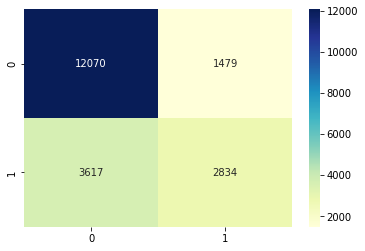

In [96]:
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7417
정밀도: 0.6108
재현율: 0.5489
AUC: 0.6912
F1: 0.5782


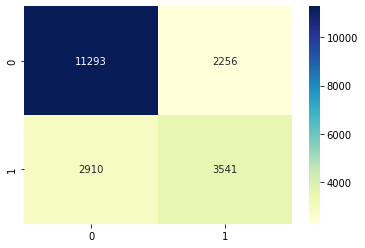

In [98]:
# threshold
y_pred_prob = cb_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_pred_prob[:, 1]>0.38)

### 4.1.2 LGBM

In [ ]:
lgbm_clf = LGBMClassifier()

In [122]:
def objective_lgbm(trial: Trial) -> float:
    param = {
        "random_state":42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y[train_idx], y[test_idx]

        model = LGBMClassifier(**param)
        model.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid,y_valid)],
                    eval_metric="binary_logloss",
                    early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_valid)
        cv_scores[idx] = log_loss(y_valid, preds)

    return np.mean(cv_scores)

In [123]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'lgbm_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective_lgbm, n_trials=5)

[I 2022-02-08 02:35:18,123] A new study created in memory with name: lgbm_parameter_opt
[W 2022-02-08 02:35:18,304] Trial 0 failed because of the following error: LightGBMError('Number of classes should be specified and greater than 1 for multiclass training')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 791, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 855, in __init_from_np2d
    ctypes.byref(self.handle)

LightGBMError: ignored

### 앙상블 모델 로테이션 돌리면서 체크

In [102]:
lgbm_clf = LGBMClassifier()  # 0.5568 - 4초
gbc_clf = GradientBoostingClassifier()  # 0.4749 / 정확도는 ada보다 조금 높음. - 41초
bag_clf = BaggingClassifier()  # 0.5088 - 17초
hgb_clf = HistGradientBoostingClassifier()  # 0.5575 - 10초
# cb_clf = CatBoostClassifier()

stacking_clf = StackingClassifier(estimators=[ ('cb', cb_clf), ('bag', bag_clf), ('gbc', gbc_clf), ('lgbm', lgbm_clf)], final_estimator = HistGradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2610:	learn: 0.1202144	total: 3m 36s	remaining: 1m 39s
2611:	learn: 0.1201415	total: 3m 37s	remaining: 1m 39s
2612:	learn: 0.1201010	total: 3m 37s	remaining: 1m 39s
2613:	learn: 0.1200475	total: 3m 37s	remaining: 1m 38s
2614:	learn: 0.1200143	total: 3m 37s	remaining: 1m 38s
2615:	learn: 0.1199318	total: 3m 37s	remaining: 1m 38s
2616:	learn: 0.1198687	total: 3m 37s	remaining: 1m 38s
2617:	learn: 0.1197931	total: 3m 37s	remaining: 1m 38s
2618:	learn: 0.1197162	total: 3m 37s	remaining: 1m 38s
2619:	learn: 0.1196287	total: 3m 37s	remaining: 1m 38s
2620:	learn: 0.1195228	total: 3m 37s	remaining: 1m 38s
2621:	learn: 0.1194431	total: 3m 37s	remaining: 1m 38s
2622:	learn: 0.1193733	total: 3m 37s	remaining: 1m 38s
2623:	learn: 0.1193321	total: 3m 38s	remaining: 1m 38s
2624:	learn: 0.1192988	total: 3m 38s	remaining: 1m 38s
2625:	learn: 0.1192137	total: 3m 38s	remaining: 1m 37s
2626:	learn: 0.1191458	total: 3m 38s	remaining: 1m 37s
2627:	learn: 0.1190845	total:


정확도: 0.7528
정밀도: 0.6372
재현율: 0.5421
AUC: 0.6976
F1: 0.5858


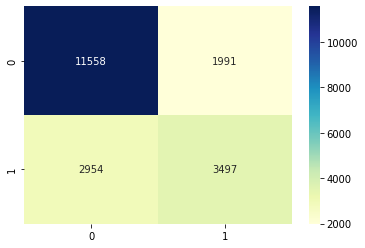

In [205]:
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7346
정밀도: 0.5854
재현율: 0.6075
AUC: 0.7013
F1: 0.5962


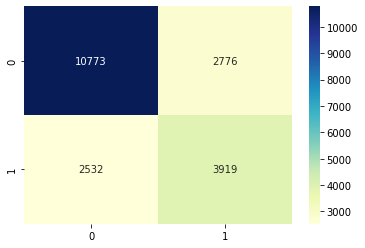

In [211]:
# threshold
y_pred_prob = cb_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_pred_prob[:, 1]>0.315)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
10:	learn: 0.5945526	total: 245ms	remaining: 22s
11:	learn: 0.5902174	total: 266ms	remaining: 21.9s
12:	learn: 0.5858754	total: 286ms	remaining: 21.7s
13:	learn: 0.5824280	total: 306ms	remaining: 21.6s
14:	learn: 0.5787262	total: 326ms	remaining: 21.4s
15:	learn: 0.5759925	total: 345ms	remaining: 21.2s
16:	learn: 0.5737572	total: 363ms	remaining: 21s
17:	learn: 0.5715661	total: 383ms	remaining: 20.9s
18:	learn: 0.5697039	total: 407ms	remaining: 21s
19:	learn: 0.5675204	total: 428ms	remaining: 21s
20:	learn: 0.5653563	total: 447ms	remaining: 20.9s
21:	learn: 0.5635874	total: 468ms	remaining: 20.8s
22:	learn: 0.5617183	total: 491ms	remaining: 20.9s
23:	learn: 0.5603127	total: 512ms	remaining: 20.8s
24:	learn: 0.5590975	total: 532ms	remaining: 20.7s
25:	learn: 0.5578282	total: 551ms	remaining: 20.6s
26:	learn: 0.5565625	total: 573ms	remaining: 20.6s
27:	learn: 0.5552174	total: 595ms	remaining: 20.7s
28:	learn: 0.5542213	total: 620ms	remaining: 20.8s
29:

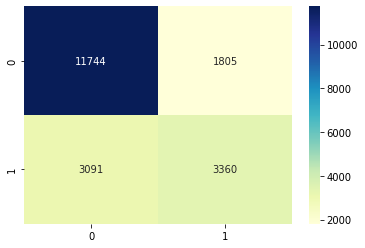

In [ ]:
lgbm_clf = LGBMClassifier()  # 0.5568 - 4초
gbc_clf = GradientBoostingClassifier()  # 0.4749 / 정확도는 ada보다 조금 높음. - 41초
bag_clf = BaggingClassifier()  # 0.5088 - 17초
hgb_clf = HistGradientBoostingClassifier()  # 0.5575 - 10초
cb_clf = CatBoostClassifier()

stacking_clf = StackingClassifier(estimators=[ ('cb', cb_clf), ('bag', bag_clf), ('hgb', hgb_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

## 4.2 교차 검증(StratifiedKFold)

In [ ]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
scores = cross_val_score(bag_clf, X_train, y_train, cv=rskfold)
scores, scores.mean()

(array([0.7264375, 0.72475  , 0.7300625, 0.7270625, 0.7175   , 0.7325625,
        0.731625 , 0.7286875, 0.732125 , 0.7236875, 0.729    , 0.7275625,
        0.726875 , 0.726    , 0.729    , 0.7289375, 0.7284375, 0.726125 ,
        0.7255   , 0.726375 , 0.7325   , 0.7261875, 0.7298125, 0.7259375,
        0.728625 ]), 0.727655)

In [ ]:
rskfold_lgbm = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
scores = cross_val_score(lgbm_clf, X_train, y_train, cv=rskfold)
scores, scores.mean()

(array([0.755125 , 0.749125 , 0.7541875, 0.75875  , 0.7485625, 0.755625 ,
        0.754    , 0.7518125, 0.758625 , 0.7463125, 0.753375 , 0.7529375,
        0.7486875, 0.756    , 0.7551875, 0.752625 , 0.755625 , 0.7473125,
        0.7530625, 0.7520625, 0.7543125, 0.75225  , 0.7510625, 0.75375  ,
        0.7534375]), 0.7529524999999999)


정확도: 0.7547
정밀도: 0.6700
재현율: 0.4836
AUC: 0.6844
F1: 0.5618


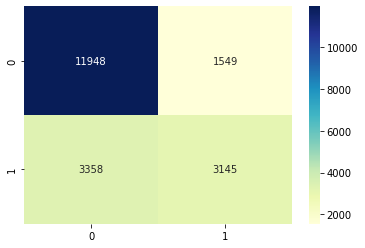

In [ ]:
y_pred_stack = lgbm_clf.predict(X_valid)

get_clf_eval(y_valid, y_pred_stack)

# 5. Ensemble(Stacking)

In [254]:
rnd_clf = RandomForestClassifier()  # 0.4613 - 28초
lgbm_clf = LGBMClassifier()  # 0.5568 - 4초
xgb_clf = XGBClassifier()  # 0.4651 - 16초
rid_clf = RidgeClassifier()  # 0.4036 - 1초
dtc_clf = DecisionTreeClassifier()  # 0.4963 - 4초
svm_clf = SVC()  # 0.0000 / 정확도: 0.6779 - 28분
ada_clf = AdaBoostClassifier()  # 0.4749 - 10초
gbc_clf = GradientBoostingClassifier()  # 0.4749 / 정확도는 ada보다 조금 높음. - 41초
bag_clf = BaggingClassifier()  # 0.5088 - 17초
ext_clf = ExtraTreesClassifier()  # 0.3792 - 26초
knn_clf = KNeighborsClassifier()  # 0.2926 - 38초
hgb_clf = HistGradientBoostingClassifier()  # 0.5575 - 10초
lr_clf = LogisticRegression()
cbt_clf = CatBoostClassifier()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
10:	learn: 0.5936777	total: 245ms	remaining: 22s
11:	learn: 0.5901878	total: 271ms	remaining: 22.3s
12:	learn: 0.5866526	total: 292ms	remaining: 22.2s
13:	learn: 0.5828732	total: 313ms	remaining: 22.1s
14:	learn: 0.5798294	total: 343ms	remaining: 22.5s
15:	learn: 0.5766075	total: 370ms	remaining: 22.7s
16:	learn: 0.5737727	total: 392ms	remaining: 22.6s
17:	learn: 0.5717374	total: 419ms	remaining: 22.8s
18:	learn: 0.5695479	total: 442ms	remaining: 22.8s
19:	learn: 0.5678971	total: 464ms	remaining: 22.7s
20:	learn: 0.5659256	total: 485ms	remaining: 22.6s
21:	learn: 0.5639146	total: 507ms	remaining: 22.5s
22:	learn: 0.5623443	total: 528ms	remaining: 22.4s
23:	learn: 0.5605172	total: 550ms	remaining: 22.4s
24:	learn: 0.5589965	total: 573ms	remaining: 22.4s
25:	learn: 0.5576900	total: 595ms	remaining: 22.3s
26:	learn: 0.5564817	total: 625ms	remaining: 22.5s
27:	learn: 0.5555687	total: 648ms	remaining: 22.5s
28:	learn: 0.5544127	total: 672ms	remaining: 22.

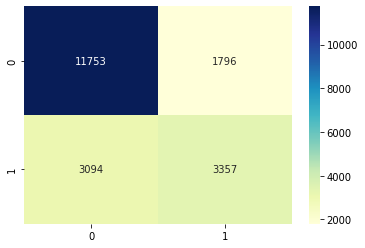

In [255]:
# stacking_clf = StackingClassifier(estimators=[ ('cbt', cbt_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = HistGradientBoostingClassifier())
stacking_clf = StackingClassifier(estimators=[ ('cbt', cbt_clf), ('bag', bag_clf), ('ada', ada_clf), ('lgbm', lgbm_clf)], final_estimator = HistGradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7378
정밀도: 0.5770
재현율: 0.7008
AUC: 0.7281
F1: 0.6329


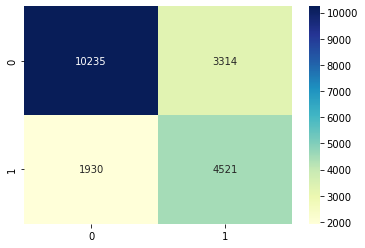

In [256]:
# threshold
y_pred_prob = stacking_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_pred_prob[:, 1]>0.38)


정확도: 0.7568
정밀도: 0.6649
재현율: 0.5144
AUC: 0.6944
F1: 0.5800


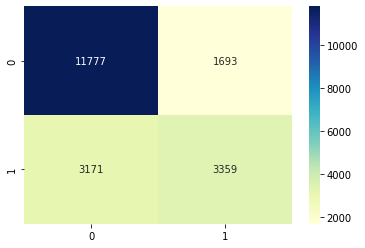

In [ ]:
# feature 처리 + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7399
정밀도: 0.5877
재현율: 0.6750
AUC: 0.7231
F1: 0.6283


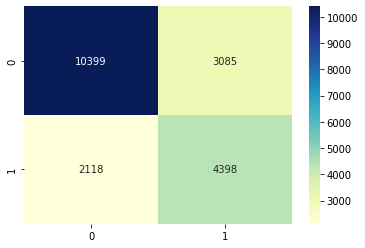

In [ ]:
# feature 처리 + min-max + threshold
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)

y_pred_prob = stacking_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_pred_prob[:, 1]>0.38)


정확도: 0.7540
정밀도: 0.6531
재현율: 0.5188
AUC: 0.6931
F1: 0.5782


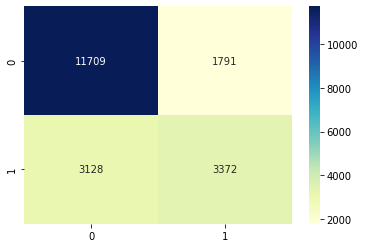

In [ ]:
# feature 처리 + z
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7533
정밀도: 0.6596
재현율: 0.5073
AUC: 0.6900
F1: 0.5735


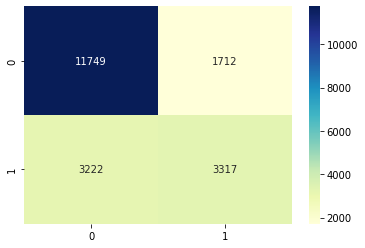

In [ ]:
# Data binning + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7524
정밀도: 0.6576
재현율: 0.5098
AUC: 0.6902
F1: 0.5743


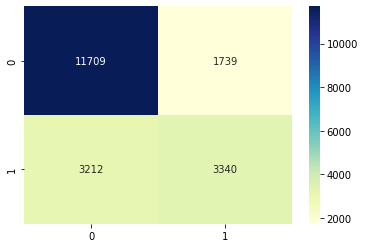

In [ ]:
# Data binning + z + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7622
정밀도: 0.6721
재현율: 0.5428
AUC: 0.7063
F1: 0.6005


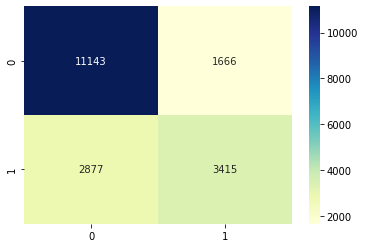

In [ ]:
# 이상치 제거 + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7380
정밀도: 0.6417
재현율: 0.4535
AUC: 0.6651
F1: 0.5314


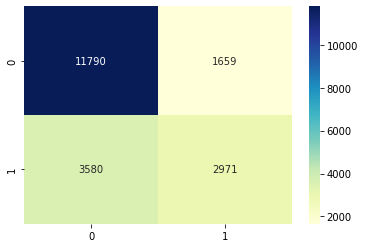

In [ ]:
# feature 제거 + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7615
정밀도: 0.6729
재현율: 0.5391
AUC: 0.7051
F1: 0.5986


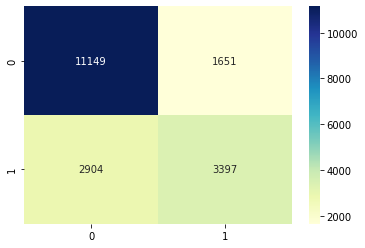

In [ ]:
# 이상치 및 feature 제거 + min-max
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7496
정밀도: 0.6380
재현율: 0.5699
AUC: 0.7045
F1: 0.6020


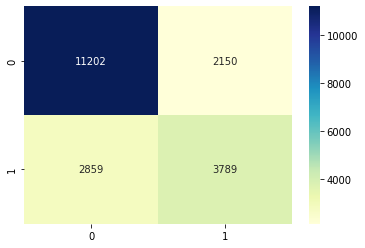

In [ ]:
# min-max + SMOTE
stacking_clf = StackingClassifier(estimators=[ ('hgb', hgb_clf), ('bag', bag_clf), ('lgbm', lgbm_clf)], final_estimator = GradientBoostingClassifier())
stacking_clf.fit(X_train_over, y_train_over)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
!pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(stacking_clf, scoring = "f1", random_state = 42).fit(X_valid, y_valid)
eli5.show_weights(perm, top = 80, feature_names = X_valid.columns.tolist())

     |████████████████████████████████| 106 kB 22.9 MB/s 


In [ ]:
# feature 처리 및 min-max
perm = PermutationImportance(stacking_clf, scoring = "f1", random_state = 42).fit(X_valid, y_valid)
eli5.show_weights(perm, top = 80, feature_names = df.columns.tolist()[:-1])

In [ ]:
# purpose4, home_ownership4, purpose14, purpose11, home_ownership1, acc_now_delinq, home_ownership3, purpose1

# Submission

In [257]:
def feat_engineering(test_df):
    test_df['annual_inc'] = np.log1p(test_df['annual_inc'])
    test_df['revol_bal'] = np.log1p(test_df['revol_bal'])
    test_df['total_acc'] = np.log1p(test_df['total_acc'])
    # test_df.tot_coll_amt[test_df['tot_coll_amt'] > 3000] = 3000
    test_df['tot_cur_bal'] = np.log1p(test_df['tot_cur_bal'])
    test_df.delinq_amnt[test_df['delinq_amnt'] > 700] = 700
    test_df.total_rec_late_fee[test_df['total_rec_late_fee'] > 50] = 50
    test_df.out_prncp[test_df['out_prncp'] > 0] = 1
    test_df.out_prncp[test_df['out_prncp_inv'] > 0] = 1
    
    to_change_cols = ['emp_length', 'mths_since_last_delinq']
    to_change_length = [12, 11]

    for i in range(len(to_change_cols)):
        test_df = inverse_encoding(test_df, to_change_cols[i], to_change_length[i])

    return test_df

In [258]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220126(모의캐글 베이스 라인)/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220126(모의캐글 베이스 라인)/test.csv')
# submit['answer'] = stacking_clf.predict(df_test.drop('ID', axis=1))
# submit['answer'] = xgb_clf.predict(df_test.drop('ID', axis=1))

df_test = feat_engineering(df_test)

# df_test.drop(['delinq_2yrs', 'inq_last_6mths', 'collections_12_mths_ex_med', 'tot_coll_amt', 
#          'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'total_rec_late_fee'], axis=1, inplace=True)
df_test.drop(['purpose4', 'home_ownership4', 'purpose14', 'purpose11', 'home_ownership1', 'acc_now_delinq', 'home_ownership3', 'purpose1'],
        axis = 1, inplace=True)
# df_test_minmax = minmax_scaler.fit_transform(df_test.drop('ID', axis=1))
# df_test_std = std_scaler.fit_transform(df_test.drop('ID', axis=1))
# df_test_minmax = minmax_scaler.fit_transform(df_test_std)
# submit['answer'] = stacking_clf.predict(df_test_std)

# threshold 적용
# submit['answer'] = (cb_clf.predict_proba(df_test.drop('ID', axis=1))[:,1]>0.38).astype(np.int64)
# submit['answer'] = (stacking_clf.predict_proba(df_test_std)[:,1]>0.38).astype(np.int64)
submit['answer'] = stacking_clf.predict(df_test.drop('ID', axis=1))

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220126(모의캐글 베이스 라인)/prediction.csv', index=False)

In [259]:
submit['answer']

0        1
1        1
2        1
3        1
4        1
        ..
35811    0
35812    0
35813    0
35814    0
35815    0
Name: answer, Length: 35816, dtype: int64